In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
weight_bit_width = 4
act_bit_width = 4
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='int',
                         scaling_impl_type='const',
                         bit_width=act_bit_width,
                         min_val=-8.0,
                         max_val=7.0, 
                         return_quant_tensor=True
                     )
        
        self.conv0 = qnn.QuantConv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = qnn.QuantConv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = qnn.QuantLinear(
                         input_length, 
                         hidden_0, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(
                         hidden_0, 
                         output_length, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )

    def forward(self, x):
        out = self.input(x)
        out = self.pool0(self.drop0(self.act0(self.bn0(self.conv0(out)))))
        out = self.pool1(self.drop1(self.act1(self.bn1(self.conv1(out)))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  return F.conv2d(input, weight, bias, self.stride,
/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9649 | Val Loss: 0.0498, Acc: 0.9848


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9838 | Val Loss: 0.0437, Acc: 0.9875


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.0529, Acc: 0.9840


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 0.0453, Acc: 0.9865


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0445, Acc: 0.9869


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0394, Acc: 0.9896


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0415, Acc: 0.9878


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0510, Acc: 0.9874


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0468, Acc: 0.9875


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0566, Acc: 0.9872


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0471, Acc: 0.9889


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0499, Acc: 0.9885


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.0434, Acc: 0.9909


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0463, Acc: 0.9897


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0558, Acc: 0.9872


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0501, Acc: 0.9897


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0457, Acc: 0.9907


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0474, Acc: 0.9902


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0548, Acc: 0.9886


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0519, Acc: 0.9904


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0574, Acc: 0.9884


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0545, Acc: 0.9894


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0584, Acc: 0.9895


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0621, Acc: 0.9891


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0594, Acc: 0.9892


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0716, Acc: 0.9875


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0570, Acc: 0.9908


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0602, Acc: 0.9885


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0573, Acc: 0.9911


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0471, Acc: 0.9918


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0573, Acc: 0.9914


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0612, Acc: 0.9908


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0691, Acc: 0.9891


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0606, Acc: 0.9900


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0629, Acc: 0.9902


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0638, Acc: 0.9910


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0684, Acc: 0.9897


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0627, Acc: 0.9899


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0651, Acc: 0.9898


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0695, Acc: 0.9899


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0598, Acc: 0.9910


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0586, Acc: 0.9912


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0677, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0747, Acc: 0.9897


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0658, Acc: 0.9902


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0655, Acc: 0.9908


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0755, Acc: 0.9898


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0727, Acc: 0.9908


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0829, Acc: 0.9891


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0625, Acc: 0.9912


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0632, Acc: 0.9909


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0672, Acc: 0.9912


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0796, Acc: 0.9888


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.0851, Acc: 0.9880


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0707, Acc: 0.9913


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0733, Acc: 0.9897


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0766, Acc: 0.9908


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0727, Acc: 0.9908


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0852, Acc: 0.9911


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0652, Acc: 0.9917


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0679, Acc: 0.9914


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0641, Acc: 0.9912


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0822, Acc: 0.9893


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0803, Acc: 0.9913


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0773, Acc: 0.9907


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0761, Acc: 0.9908


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0721, Acc: 0.9903


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0763, Acc: 0.9907


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0765, Acc: 0.9904


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0912, Acc: 0.9899


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0804, Acc: 0.9906


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9989 | Val Loss: 0.0796, Acc: 0.9910


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0747, Acc: 0.9925


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0713, Acc: 0.9920


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0894, Acc: 0.9908


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0793, Acc: 0.9915


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0862, Acc: 0.9903


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0856, Acc: 0.9905


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.0872, Acc: 0.9911


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0970, Acc: 0.9902


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0960, Acc: 0.9907


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.0857, Acc: 0.9915


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0918, Acc: 0.9903


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.0899, Acc: 0.9914


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0887, Acc: 0.9917


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0925, Acc: 0.9902


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0850, Acc: 0.9891


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0889, Acc: 0.9912


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0878, Acc: 0.9899


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0987, Acc: 0.9909


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0852, Acc: 0.9924


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.1023, Acc: 0.9897


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.1044, Acc: 0.9905


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1075, Acc: 0.9899


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1014, Acc: 0.9903


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0939, Acc: 0.9905


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1044, Acc: 0.9900


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9987 | Val Loss: 0.1042, Acc: 0.9908


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0947, Acc: 0.9904


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0940, Acc: 0.9908


Final Test Loss: 0.1013 Accuracy: 0.9890


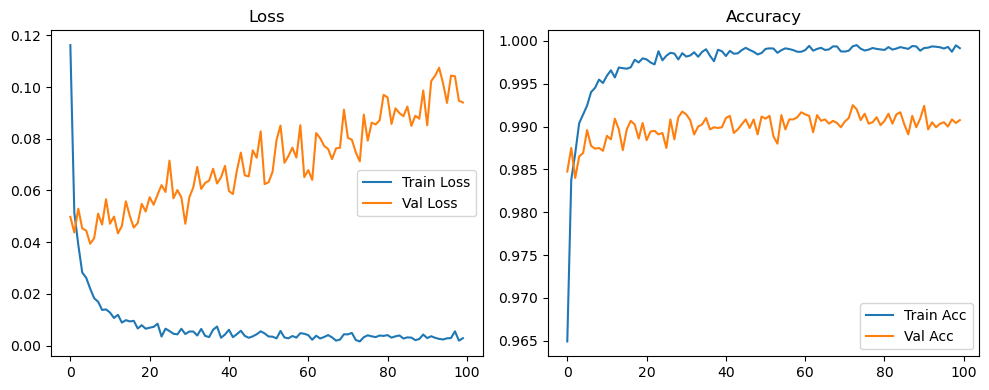

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1443, Acc: 0.9575 | Val Loss: 0.1472, Acc: 0.9556


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9778 | Val Loss: 0.0647, Acc: 0.9802


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9819 | Val Loss: 0.0704, Acc: 0.9785


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.0496, Acc: 0.9851


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.0586, Acc: 0.9829


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.0410, Acc: 0.9874


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9884 | Val Loss: 0.0481, Acc: 0.9864


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9881 | Val Loss: 0.0487, Acc: 0.9858


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.0445, Acc: 0.9876


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0452, Acc: 0.9867


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0436, Acc: 0.9879


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9913 | Val Loss: 0.0394, Acc: 0.9891


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.0545, Acc: 0.9857


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0504, Acc: 0.9861


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.0549, Acc: 0.9850


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0521, Acc: 0.9851


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.0411, Acc: 0.9874


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9933 | Val Loss: 0.0496, Acc: 0.9863


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0589, Acc: 0.9852


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0379, Acc: 0.9891


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0394, Acc: 0.9888


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0473, Acc: 0.9872


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.0403, Acc: 0.9882


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0454, Acc: 0.9870


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9939 | Val Loss: 0.0582, Acc: 0.9844


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0503, Acc: 0.9872


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0477, Acc: 0.9871


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0488, Acc: 0.9868


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.0430, Acc: 0.9879


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0336, Acc: 0.9892


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0522, Acc: 0.9858


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0590, Acc: 0.9838


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0423, Acc: 0.9886


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0517, Acc: 0.9868


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0481, Acc: 0.9868


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0587, Acc: 0.9844


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0563, Acc: 0.9847


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0388, Acc: 0.9898


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0516, Acc: 0.9858


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0486, Acc: 0.9875


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0453, Acc: 0.9875


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0408, Acc: 0.9890


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0502, Acc: 0.9862


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0583, Acc: 0.9849


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0448, Acc: 0.9878


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0438, Acc: 0.9887


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0564, Acc: 0.9848


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0398, Acc: 0.9893


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0550, Acc: 0.9848


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0458, Acc: 0.9867


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0403, Acc: 0.9883


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0463, Acc: 0.9872


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0563, Acc: 0.9835


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0514, Acc: 0.9852


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0576, Acc: 0.9838


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0522, Acc: 0.9879


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0510, Acc: 0.9858


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0491, Acc: 0.9872


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.0534, Acc: 0.9848


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0560, Acc: 0.9851


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0477, Acc: 0.9867


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0482, Acc: 0.9869


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0457, Acc: 0.9876


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0480, Acc: 0.9878


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0516, Acc: 0.9856


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0469, Acc: 0.9872


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0517, Acc: 0.9858


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0541, Acc: 0.9858


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0516, Acc: 0.9870


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0481, Acc: 0.9872


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0479, Acc: 0.9868


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0560, Acc: 0.9860


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0405, Acc: 0.9896


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0585, Acc: 0.9832


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0481, Acc: 0.9864


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0435, Acc: 0.9876


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0438, Acc: 0.9867


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0436, Acc: 0.9870


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0466, Acc: 0.9868


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0554, Acc: 0.9839


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0555, Acc: 0.9829


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0456, Acc: 0.9878


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0486, Acc: 0.9851


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0465, Acc: 0.9872


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0577, Acc: 0.9832


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0529, Acc: 0.9842


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0497, Acc: 0.9864


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0541, Acc: 0.9841


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0629, Acc: 0.9828


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0494, Acc: 0.9875


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0542, Acc: 0.9861


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.0580, Acc: 0.9851


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0604, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0448, Acc: 0.9878


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0692, Acc: 0.9834


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0521, Acc: 0.9872


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0561, Acc: 0.9852


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0504, Acc: 0.9871


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0488, Acc: 0.9862


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0479, Acc: 0.9877


Final Test Loss: 0.0403 Accuracy: 0.9875


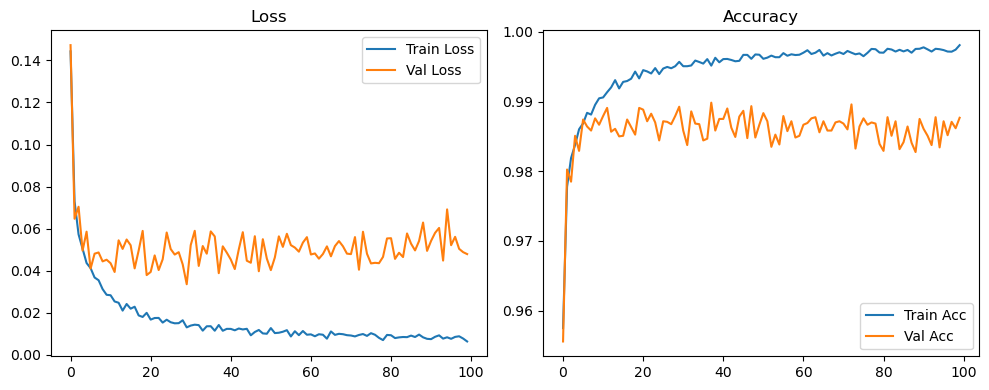

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2521, Acc: 0.9248 | Val Loss: 0.7363, Acc: 0.7465


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1408, Acc: 0.9589 | Val Loss: 0.3089, Acc: 0.9033


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9650 | Val Loss: 0.3452, Acc: 0.8798


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1059, Acc: 0.9682 | Val Loss: 0.2272, Acc: 0.9263


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1006, Acc: 0.9706 | Val Loss: 0.2211, Acc: 0.9278


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9720 | Val Loss: 0.2276, Acc: 0.9227


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9734 | Val Loss: 0.1485, Acc: 0.9618


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0919, Acc: 0.9725 | Val Loss: 0.3102, Acc: 0.8911


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9742 | Val Loss: 0.2003, Acc: 0.9405


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9762 | Val Loss: 0.2717, Acc: 0.9088


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9767 | Val Loss: 0.1820, Acc: 0.9437


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9768 | Val Loss: 0.1261, Acc: 0.9716


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9770 | Val Loss: 0.3822, Acc: 0.8573


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9780 | Val Loss: 0.1596, Acc: 0.9539


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9782 | Val Loss: 0.1480, Acc: 0.9563


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9797 | Val Loss: 0.1708, Acc: 0.9474


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9789 | Val Loss: 0.1535, Acc: 0.9533


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9808 | Val Loss: 0.1416, Acc: 0.9605


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9795 | Val Loss: 0.1407, Acc: 0.9581


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9812 | Val Loss: 0.1589, Acc: 0.9568


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9816 | Val Loss: 0.1728, Acc: 0.9483


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9820 | Val Loss: 0.1437, Acc: 0.9607


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9805 | Val Loss: 0.1286, Acc: 0.9637


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9820 | Val Loss: 0.1782, Acc: 0.9418


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9820 | Val Loss: 0.1489, Acc: 0.9645


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9816 | Val Loss: 0.1390, Acc: 0.9667


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9829 | Val Loss: 0.1565, Acc: 0.9654


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9829 | Val Loss: 0.1764, Acc: 0.9615


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9821 | Val Loss: 0.2254, Acc: 0.9470


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9825 | Val Loss: 0.1834, Acc: 0.9549


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9836 | Val Loss: 0.1676, Acc: 0.9657


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9834 | Val Loss: 0.1756, Acc: 0.9642


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9831 | Val Loss: 0.1685, Acc: 0.9673


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9835 | Val Loss: 0.1384, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9841 | Val Loss: 0.1414, Acc: 0.9671


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9843 | Val Loss: 0.1885, Acc: 0.9622


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9836 | Val Loss: 0.1507, Acc: 0.9705


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9848 | Val Loss: 0.1699, Acc: 0.9664


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9846 | Val Loss: 0.2081, Acc: 0.9665


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9839 | Val Loss: 0.1786, Acc: 0.9673


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9856 | Val Loss: 0.2514, Acc: 0.9478


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9855 | Val Loss: 0.1869, Acc: 0.9582


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9846 | Val Loss: 0.2358, Acc: 0.9608


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9848 | Val Loss: 0.1911, Acc: 0.9577


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 0.2652, Acc: 0.9533


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.1934, Acc: 0.9596


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.3373, Acc: 0.9057


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9847 | Val Loss: 0.1888, Acc: 0.9709


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9850 | Val Loss: 0.2305, Acc: 0.9472


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9860 | Val Loss: 0.2407, Acc: 0.9613


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.1804, Acc: 0.9644


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 0.1745, Acc: 0.9718


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9857 | Val Loss: 0.2498, Acc: 0.9473


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9853 | Val Loss: 0.1955, Acc: 0.9645


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9858 | Val Loss: 0.2742, Acc: 0.9335


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9856 | Val Loss: 0.2079, Acc: 0.9716


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9864 | Val Loss: 0.2392, Acc: 0.9580


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.2211, Acc: 0.9640


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9853 | Val Loss: 0.2744, Acc: 0.9511


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.3197, Acc: 0.9503


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9859 | Val Loss: 0.3246, Acc: 0.9307


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.2135, Acc: 0.9710


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 0.2658, Acc: 0.9593


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.2753, Acc: 0.9680


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.2754, Acc: 0.9613


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9863 | Val Loss: 0.2720, Acc: 0.9577


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.3258, Acc: 0.9487


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9866 | Val Loss: 0.3699, Acc: 0.9406


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9866 | Val Loss: 0.3719, Acc: 0.9194


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9872 | Val Loss: 0.3767, Acc: 0.9409


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9872 | Val Loss: 0.3485, Acc: 0.9476


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.3614, Acc: 0.9291


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.3227, Acc: 0.9380


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9868 | Val Loss: 0.4857, Acc: 0.9109


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9857 | Val Loss: 0.4444, Acc: 0.9305


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9877 | Val Loss: 0.3636, Acc: 0.9356


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9870 | Val Loss: 0.4053, Acc: 0.9231


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9867 | Val Loss: 0.3302, Acc: 0.9418


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.3170, Acc: 0.9392


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 0.2961, Acc: 0.9435


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.3033, Acc: 0.9541


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 0.2623, Acc: 0.9631


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.3926, Acc: 0.9259


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.4158, Acc: 0.9392


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 0.3963, Acc: 0.9478


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.4210, Acc: 0.9317


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9882 | Val Loss: 0.5694, Acc: 0.8689


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9873 | Val Loss: 0.4585, Acc: 0.9151


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9880 | Val Loss: 0.5391, Acc: 0.9032


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9872 | Val Loss: 0.6529, Acc: 0.8838


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.3940, Acc: 0.9358


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9875 | Val Loss: 0.5444, Acc: 0.9191


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.5579, Acc: 0.9037


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9880 | Val Loss: 0.5423, Acc: 0.9280


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.5838, Acc: 0.8720


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.5116, Acc: 0.9038


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9879 | Val Loss: 0.6575, Acc: 0.8791


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.7711, Acc: 0.8546


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.7036, Acc: 0.8487


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9884 | Val Loss: 0.6717, Acc: 0.8754


Final Test Loss: 0.6693 Accuracy: 0.8807


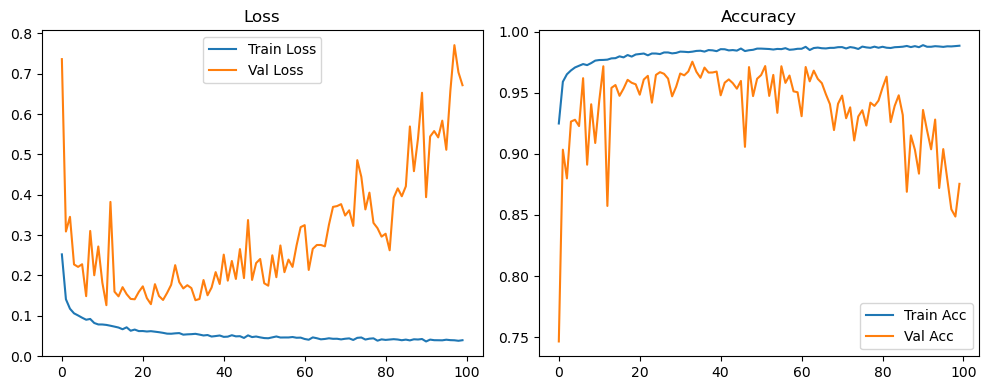

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9646 | Val Loss: 0.0554, Acc: 0.9832


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.0394, Acc: 0.9888


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.0474, Acc: 0.9854


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0455, Acc: 0.9862


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0467, Acc: 0.9864


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.0535, Acc: 0.9854


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.0447, Acc: 0.9883


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0455, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0452, Acc: 0.9879


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0489, Acc: 0.9883


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0398, Acc: 0.9898


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0489, Acc: 0.9873


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0529, Acc: 0.9875


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0479, Acc: 0.9891


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0512, Acc: 0.9896


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0531, Acc: 0.9895


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0651, Acc: 0.9869


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0484, Acc: 0.9892


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0539, Acc: 0.9881


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0465, Acc: 0.9899


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0594, Acc: 0.9895


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0559, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0623, Acc: 0.9888


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0507, Acc: 0.9904


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0617, Acc: 0.9879


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0589, Acc: 0.9888


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0544, Acc: 0.9901


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0539, Acc: 0.9893


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0551, Acc: 0.9903


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0506, Acc: 0.9912


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0627, Acc: 0.9893


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0563, Acc: 0.9906


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0654, Acc: 0.9884


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0562, Acc: 0.9902


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0579, Acc: 0.9905


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0579, Acc: 0.9896


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0698, Acc: 0.9891


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0579, Acc: 0.9914


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0613, Acc: 0.9910


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0744, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0592, Acc: 0.9906


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0659, Acc: 0.9903


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0780, Acc: 0.9881


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0678, Acc: 0.9905


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0691, Acc: 0.9897


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0818, Acc: 0.9894


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0752, Acc: 0.9896


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0737, Acc: 0.9891


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9882


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.0687, Acc: 0.9906


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0645, Acc: 0.9915


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0620, Acc: 0.9926


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0667, Acc: 0.9912


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0649, Acc: 0.9922


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0642, Acc: 0.9922


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0661, Acc: 0.9923


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0652, Acc: 0.9918


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0640, Acc: 0.9911


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0661, Acc: 0.9910


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0614, Acc: 0.9919


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0709, Acc: 0.9919


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0690, Acc: 0.9925


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0790, Acc: 0.9913


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0734, Acc: 0.9921


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0687, Acc: 0.9918


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0683, Acc: 0.9914


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0773, Acc: 0.9905


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0931, Acc: 0.9887


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0845, Acc: 0.9901


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0831, Acc: 0.9904


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0720, Acc: 0.9909


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0785, Acc: 0.9901


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0807, Acc: 0.9918


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0763, Acc: 0.9903


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0734, Acc: 0.9919


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0784, Acc: 0.9896


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0796, Acc: 0.9908


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0781, Acc: 0.9904


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0862, Acc: 0.9903


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0794, Acc: 0.9914


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0837, Acc: 0.9918


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0789, Acc: 0.9920


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0823, Acc: 0.9918


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0805, Acc: 0.9912


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0851, Acc: 0.9912


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0785, Acc: 0.9920


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0761, Acc: 0.9921


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0787, Acc: 0.9925


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0781, Acc: 0.9918


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0813, Acc: 0.9918


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0810, Acc: 0.9923


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0761, Acc: 0.9923


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0853, Acc: 0.9922


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0782, Acc: 0.9923


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0836, Acc: 0.9915


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0814, Acc: 0.9925


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0804, Acc: 0.9919


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0802, Acc: 0.9923


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0798, Acc: 0.9928


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0795, Acc: 0.9928


Final Test Loss: 0.0822 Accuracy: 0.9912


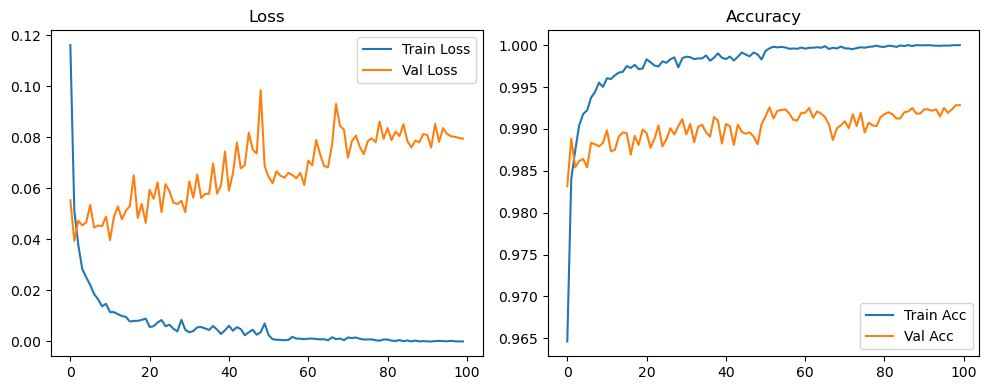

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1456, Acc: 0.9574 | Val Loss: 0.1115, Acc: 0.9653


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9773 | Val Loss: 0.0533, Acc: 0.9842


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9820 | Val Loss: 0.0702, Acc: 0.9785


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9848 | Val Loss: 0.0488, Acc: 0.9848


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0550, Acc: 0.9818


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.0409, Acc: 0.9870


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.0445, Acc: 0.9875


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9885 | Val Loss: 0.0405, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.0437, Acc: 0.9864


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9910 | Val Loss: 0.0542, Acc: 0.9842


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0503, Acc: 0.9853


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9922 | Val Loss: 0.0459, Acc: 0.9875


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.0773, Acc: 0.9797


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.0526, Acc: 0.9852


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0519, Acc: 0.9852


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.0557, Acc: 0.9845


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0597, Acc: 0.9839


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.0376, Acc: 0.9893


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0584, Acc: 0.9843


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0437, Acc: 0.9885


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0529, Acc: 0.9857


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.0406, Acc: 0.9883


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9943 | Val Loss: 0.0416, Acc: 0.9893


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0452, Acc: 0.9885


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.0491, Acc: 0.9848


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0520, Acc: 0.9867


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0422, Acc: 0.9886


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0502, Acc: 0.9863


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0651, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0540, Acc: 0.9870


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0528, Acc: 0.9858


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0508, Acc: 0.9882


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0429, Acc: 0.9889


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0553, Acc: 0.9860


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0396, Acc: 0.9894


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0627, Acc: 0.9832


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0579, Acc: 0.9842


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0497, Acc: 0.9868


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0554, Acc: 0.9855


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0603, Acc: 0.9842


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0507, Acc: 0.9868


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0442, Acc: 0.9880


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0724, Acc: 0.9803


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0601, Acc: 0.9856


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0599, Acc: 0.9820


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0465, Acc: 0.9887


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0658, Acc: 0.9828


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0488, Acc: 0.9880


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0612, Acc: 0.9832


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0429, Acc: 0.9879


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0449, Acc: 0.9876


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0456, Acc: 0.9890


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0512, Acc: 0.9877


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0452, Acc: 0.9875


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0446, Acc: 0.9882


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0456, Acc: 0.9885


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0622, Acc: 0.9844


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0511, Acc: 0.9882


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0600, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0485, Acc: 0.9872


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0534, Acc: 0.9872


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0451, Acc: 0.9888


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0394, Acc: 0.9896


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0414, Acc: 0.9893


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0428, Acc: 0.9881


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0454, Acc: 0.9884


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0384, Acc: 0.9903


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0484, Acc: 0.9870


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0472, Acc: 0.9882


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0447, Acc: 0.9883


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0424, Acc: 0.9892


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0531, Acc: 0.9881


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0567, Acc: 0.9866


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0513, Acc: 0.9867


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0423, Acc: 0.9890


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0465, Acc: 0.9878


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0512, Acc: 0.9864


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0487, Acc: 0.9876


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0497, Acc: 0.9878


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0471, Acc: 0.9879


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0454, Acc: 0.9887


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0391, Acc: 0.9907


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0407, Acc: 0.9895


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0392, Acc: 0.9898


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0453, Acc: 0.9886


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0547, Acc: 0.9857


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0429, Acc: 0.9887


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0435, Acc: 0.9894


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0482, Acc: 0.9885


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0445, Acc: 0.9891


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0487, Acc: 0.9900


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0439, Acc: 0.9899


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0439, Acc: 0.9900


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0404, Acc: 0.9896


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0448, Acc: 0.9897


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0469, Acc: 0.9890


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0467, Acc: 0.9893


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0518, Acc: 0.9869


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0469, Acc: 0.9881


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0426, Acc: 0.9900


Final Test Loss: 0.0351 Accuracy: 0.9903


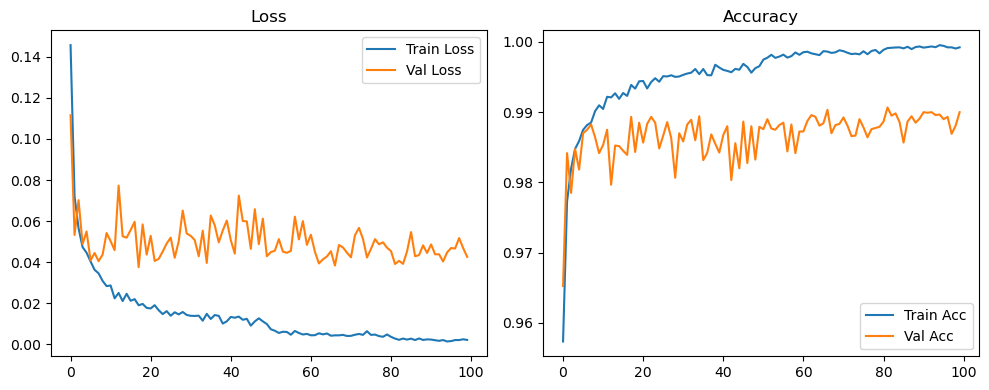

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2530, Acc: 0.9244 | Val Loss: 0.8090, Acc: 0.7014


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9584 | Val Loss: 0.3552, Acc: 0.8781


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1185, Acc: 0.9648 | Val Loss: 0.3270, Acc: 0.8924


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9683 | Val Loss: 0.2116, Acc: 0.9378


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9705 | Val Loss: 0.1991, Acc: 0.9356


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0967, Acc: 0.9712 | Val Loss: 0.3158, Acc: 0.8890


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9734 | Val Loss: 0.1894, Acc: 0.9413


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9734 | Val Loss: 0.1819, Acc: 0.9395


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0829, Acc: 0.9747 | Val Loss: 0.2267, Acc: 0.9289


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9768 | Val Loss: 0.2695, Acc: 0.9117


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9777 | Val Loss: 0.1823, Acc: 0.9457


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9769 | Val Loss: 0.1043, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9781 | Val Loss: 0.1886, Acc: 0.9403


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9784 | Val Loss: 0.1382, Acc: 0.9595


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9790 | Val Loss: 0.1605, Acc: 0.9502


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9799 | Val Loss: 0.1467, Acc: 0.9616


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9798 | Val Loss: 0.1227, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9793 | Val Loss: 0.2803, Acc: 0.9069


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9803 | Val Loss: 0.0943, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9821 | Val Loss: 0.1632, Acc: 0.9527


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9808 | Val Loss: 0.1664, Acc: 0.9536


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9818 | Val Loss: 0.1269, Acc: 0.9662


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9820 | Val Loss: 0.1383, Acc: 0.9675


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9808 | Val Loss: 0.1860, Acc: 0.9423


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9819 | Val Loss: 0.1803, Acc: 0.9484


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9821 | Val Loss: 0.1775, Acc: 0.9564


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9826 | Val Loss: 0.1512, Acc: 0.9637


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9826 | Val Loss: 0.1953, Acc: 0.9447


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9825 | Val Loss: 0.1480, Acc: 0.9701


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9828 | Val Loss: 0.1532, Acc: 0.9661


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9833 | Val Loss: 0.1703, Acc: 0.9659


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9842 | Val Loss: 0.1469, Acc: 0.9663


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9840 | Val Loss: 0.1289, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.1623, Acc: 0.9596


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9836 | Val Loss: 0.1340, Acc: 0.9793


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9843 | Val Loss: 0.2142, Acc: 0.9476


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9842 | Val Loss: 0.1565, Acc: 0.9649


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9844 | Val Loss: 0.1889, Acc: 0.9528


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9843 | Val Loss: 0.2087, Acc: 0.9623


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9850 | Val Loss: 0.2148, Acc: 0.9510


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9845 | Val Loss: 0.2099, Acc: 0.9517


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9856 | Val Loss: 0.1747, Acc: 0.9672


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9848 | Val Loss: 0.2036, Acc: 0.9622


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9843 | Val Loss: 0.2872, Acc: 0.9057


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9840 | Val Loss: 0.1676, Acc: 0.9588


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 0.1524, Acc: 0.9683


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.1878, Acc: 0.9483


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9852 | Val Loss: 0.1818, Acc: 0.9655


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9865 | Val Loss: 0.1478, Acc: 0.9603


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9854 | Val Loss: 0.2204, Acc: 0.9450


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.1777, Acc: 0.9593


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1387, Acc: 0.9757


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.2017, Acc: 0.9500


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.2338, Acc: 0.9507


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9888 | Val Loss: 0.1827, Acc: 0.9536


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9891 | Val Loss: 0.1636, Acc: 0.9670


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9882 | Val Loss: 0.2152, Acc: 0.9552


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.2172, Acc: 0.9576


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9884 | Val Loss: 0.1879, Acc: 0.9542


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9887 | Val Loss: 0.2113, Acc: 0.9644


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.2336, Acc: 0.9426


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.1915, Acc: 0.9681


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9884 | Val Loss: 0.2475, Acc: 0.9508


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.2752, Acc: 0.9470


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.2314, Acc: 0.9600


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9900 | Val Loss: 0.2084, Acc: 0.9598


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.2896, Acc: 0.9487


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.2422, Acc: 0.9562


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.2579, Acc: 0.9541


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.2292, Acc: 0.9581


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9900 | Val Loss: 0.1968, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.2298, Acc: 0.9546


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.2794, Acc: 0.9344


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 0.2168, Acc: 0.9658


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.2363, Acc: 0.9576


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.2531, Acc: 0.9587


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.2191, Acc: 0.9586


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.2066, Acc: 0.9598


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.2549, Acc: 0.9526


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.2274, Acc: 0.9601


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.2474, Acc: 0.9509


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9910 | Val Loss: 0.2248, Acc: 0.9671


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.2706, Acc: 0.9482


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.2620, Acc: 0.9627


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.2477, Acc: 0.9617


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9917 | Val Loss: 0.3003, Acc: 0.9486


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.2768, Acc: 0.9653


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.2775, Acc: 0.9587


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.2425, Acc: 0.9675


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.3312, Acc: 0.9574


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9917 | Val Loss: 0.2771, Acc: 0.9618


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9922 | Val Loss: 0.2569, Acc: 0.9654


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.2618, Acc: 0.9627


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.3243, Acc: 0.9443


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.2862, Acc: 0.9487


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9914 | Val Loss: 0.3008, Acc: 0.9588


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.3369, Acc: 0.9533


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.3045, Acc: 0.9541


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.3383, Acc: 0.9448


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.2869, Acc: 0.9607


Final Test Loss: 0.2790 Accuracy: 0.9659


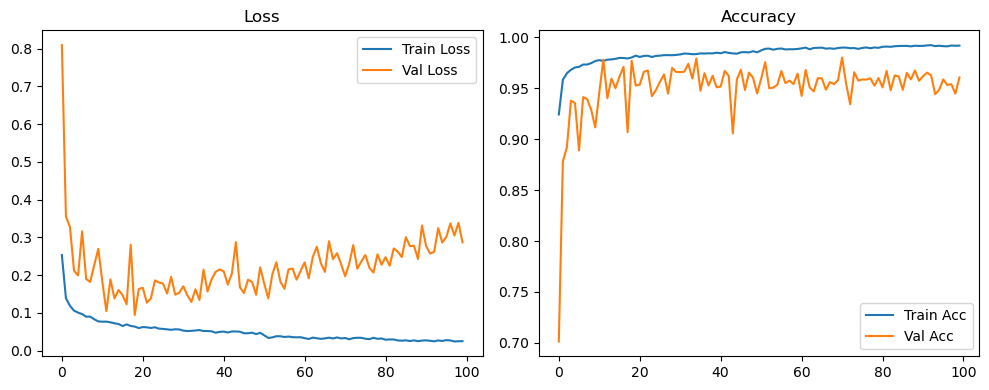

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1166, Acc: 0.9648 | Val Loss: 0.0624, Acc: 0.9820


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 0.0400, Acc: 0.9877


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 0.0453, Acc: 0.9866


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.0427, Acc: 0.9888


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9914 | Val Loss: 0.0492, Acc: 0.9854


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.0499, Acc: 0.9856


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9945 | Val Loss: 0.0459, Acc: 0.9871


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0543, Acc: 0.9867


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9942 | Val Loss: 0.0457, Acc: 0.9882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0542, Acc: 0.9881


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0463, Acc: 0.9891


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0518, Acc: 0.9881


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0531, Acc: 0.9890


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0600, Acc: 0.9876


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0491, Acc: 0.9897


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0569, Acc: 0.9892


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0595, Acc: 0.9886


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0733, Acc: 0.9865


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0540, Acc: 0.9894


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0561, Acc: 0.9887


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0548, Acc: 0.9894


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0696, Acc: 0.9873


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0582, Acc: 0.9894


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0605, Acc: 0.9885


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0623, Acc: 0.9887


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0558, Acc: 0.9911


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0707, Acc: 0.9884


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0677, Acc: 0.9892


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0689, Acc: 0.9893


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0808, Acc: 0.9878


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0662, Acc: 0.9902


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0705, Acc: 0.9889


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0661, Acc: 0.9887


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0730, Acc: 0.9891


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0749, Acc: 0.9886


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0692, Acc: 0.9902


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0608, Acc: 0.9898


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0592, Acc: 0.9899


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0674, Acc: 0.9903


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0882, Acc: 0.9878


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.0653, Acc: 0.9909


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0975, Acc: 0.9873


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0732, Acc: 0.9899


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0786, Acc: 0.9891


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0861, Acc: 0.9872


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0588, Acc: 0.9908


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0686, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0651, Acc: 0.9904


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0803, Acc: 0.9885


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0679, Acc: 0.9898


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0589, Acc: 0.9921


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0593, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0638, Acc: 0.9917


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0654, Acc: 0.9919


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0622, Acc: 0.9921


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0635, Acc: 0.9913


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0753, Acc: 0.9901


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0636, Acc: 0.9916


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0667, Acc: 0.9911


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0702, Acc: 0.9916


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0727, Acc: 0.9914


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0760, Acc: 0.9922


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0726, Acc: 0.9911


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0718, Acc: 0.9928


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0806, Acc: 0.9910


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0895, Acc: 0.9905


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0938, Acc: 0.9902


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0800, Acc: 0.9914


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0981, Acc: 0.9897


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0908, Acc: 0.9896


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0899, Acc: 0.9908


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0862, Acc: 0.9907


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0869, Acc: 0.9912


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0914, Acc: 0.9902


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0858, Acc: 0.9920


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0860, Acc: 0.9905


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0825, Acc: 0.9917


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0801, Acc: 0.9918


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0791, Acc: 0.9910


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0831, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0794, Acc: 0.9921


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0813, Acc: 0.9921


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0798, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0804, Acc: 0.9916


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0839, Acc: 0.9920


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0810, Acc: 0.9922


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0798, Acc: 0.9925


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0822, Acc: 0.9921


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0838, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0871, Acc: 0.9920


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0936, Acc: 0.9915


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0851, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0878, Acc: 0.9923


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0867, Acc: 0.9918


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0872, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0852, Acc: 0.9919


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0835, Acc: 0.9923


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0799, Acc: 0.9922


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0825, Acc: 0.9924


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0812, Acc: 0.9927


Final Test Loss: 0.0831 Accuracy: 0.9917


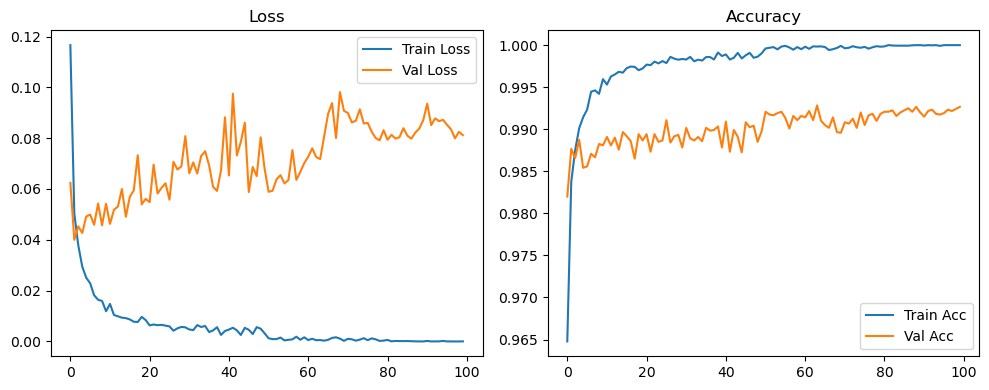

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1449, Acc: 0.9574 | Val Loss: 0.1191, Acc: 0.9633


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9776 | Val Loss: 0.0582, Acc: 0.9832


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9823 | Val Loss: 0.0566, Acc: 0.9836


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9842 | Val Loss: 0.0445, Acc: 0.9862


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9859 | Val Loss: 0.0552, Acc: 0.9822


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.0465, Acc: 0.9858


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9889 | Val Loss: 0.0454, Acc: 0.9865


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0564, Acc: 0.9839


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.0509, Acc: 0.9860


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.0537, Acc: 0.9835


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.0624, Acc: 0.9824


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0423, Acc: 0.9879


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0386, Acc: 0.9882


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.0443, Acc: 0.9873


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0384, Acc: 0.9889


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0566, Acc: 0.9849


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0511, Acc: 0.9847


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0488, Acc: 0.9862


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0430, Acc: 0.9875


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0434, Acc: 0.9874


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0554, Acc: 0.9847


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9941 | Val Loss: 0.0521, Acc: 0.9842


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0512, Acc: 0.9858


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0421, Acc: 0.9878


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0443, Acc: 0.9872


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0447, Acc: 0.9884


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.0516, Acc: 0.9859


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0496, Acc: 0.9861


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0465, Acc: 0.9877


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0371, Acc: 0.9895


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0447, Acc: 0.9884


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.0531, Acc: 0.9859


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0443, Acc: 0.9882


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0472, Acc: 0.9874


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0434, Acc: 0.9871


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0419, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0506, Acc: 0.9860


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0473, Acc: 0.9879


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0511, Acc: 0.9848


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0383, Acc: 0.9891


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0460, Acc: 0.9873


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0449, Acc: 0.9874


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0418, Acc: 0.9894


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0471, Acc: 0.9867


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0493, Acc: 0.9876


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0420, Acc: 0.9896


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0672, Acc: 0.9818


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0448, Acc: 0.9877


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0394, Acc: 0.9886


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0446, Acc: 0.9882


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0401, Acc: 0.9896


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0386, Acc: 0.9898


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0405, Acc: 0.9897


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0427, Acc: 0.9896


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0437, Acc: 0.9892


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0428, Acc: 0.9895


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0411, Acc: 0.9897


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0374, Acc: 0.9901


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0456, Acc: 0.9870


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0423, Acc: 0.9889


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0430, Acc: 0.9888


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0491, Acc: 0.9874


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0366, Acc: 0.9902


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0451, Acc: 0.9893


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0435, Acc: 0.9897


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0389, Acc: 0.9898


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.0396, Acc: 0.9889


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0413, Acc: 0.9887


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0399, Acc: 0.9896


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0439, Acc: 0.9890


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0424, Acc: 0.9892


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0454, Acc: 0.9882


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0379, Acc: 0.9902


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0415, Acc: 0.9889


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0414, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0354, Acc: 0.9906


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0488, Acc: 0.9864


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0397, Acc: 0.9901


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0470, Acc: 0.9877


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0381, Acc: 0.9897


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0393, Acc: 0.9903


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0372, Acc: 0.9907


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0401, Acc: 0.9891


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0369, Acc: 0.9903


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0371, Acc: 0.9911


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0366, Acc: 0.9908


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0356, Acc: 0.9907


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0378, Acc: 0.9907


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0393, Acc: 0.9902


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0385, Acc: 0.9903


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0451, Acc: 0.9876


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0381, Acc: 0.9905


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0402, Acc: 0.9897


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0365, Acc: 0.9909


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0427, Acc: 0.9892


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0445, Acc: 0.9888


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0407, Acc: 0.9897


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0405, Acc: 0.9897


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0373, Acc: 0.9906


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0375, Acc: 0.9902


Final Test Loss: 0.0392 Accuracy: 0.9898


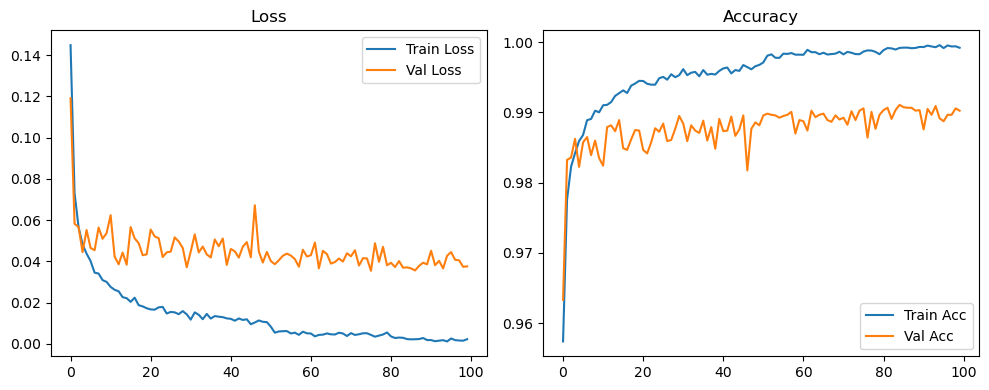

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2516, Acc: 0.9249 | Val Loss: 0.9914, Acc: 0.6368


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9580 | Val Loss: 0.2348, Acc: 0.9313


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1185, Acc: 0.9651 | Val Loss: 0.2123, Acc: 0.9363


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9678 | Val Loss: 0.2428, Acc: 0.9233


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1027, Acc: 0.9700 | Val Loss: 0.2144, Acc: 0.9323


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9717 | Val Loss: 0.2401, Acc: 0.9201


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9732 | Val Loss: 0.1386, Acc: 0.9626


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9737 | Val Loss: 0.2218, Acc: 0.9324


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9754 | Val Loss: 0.2469, Acc: 0.9191


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9767 | Val Loss: 0.2306, Acc: 0.9243


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9770 | Val Loss: 0.1534, Acc: 0.9510


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9777 | Val Loss: 0.1391, Acc: 0.9660


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9771 | Val Loss: 0.1881, Acc: 0.9411


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9774 | Val Loss: 0.1836, Acc: 0.9403


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9784 | Val Loss: 0.1853, Acc: 0.9401


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9799 | Val Loss: 0.1243, Acc: 0.9668


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9791 | Val Loss: 0.1827, Acc: 0.9407


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9803 | Val Loss: 0.1449, Acc: 0.9553


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9806 | Val Loss: 0.1593, Acc: 0.9556


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9812 | Val Loss: 0.1821, Acc: 0.9434


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.2011, Acc: 0.9381


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9825 | Val Loss: 0.1137, Acc: 0.9713


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9813 | Val Loss: 0.1101, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9811 | Val Loss: 0.1319, Acc: 0.9684


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9820 | Val Loss: 0.1435, Acc: 0.9608


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9825 | Val Loss: 0.1544, Acc: 0.9675


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9836 | Val Loss: 0.1386, Acc: 0.9727


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9825 | Val Loss: 0.1431, Acc: 0.9686


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9821 | Val Loss: 0.1757, Acc: 0.9621


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9822 | Val Loss: 0.1757, Acc: 0.9562


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9832 | Val Loss: 0.1833, Acc: 0.9612


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9837 | Val Loss: 0.1866, Acc: 0.9681


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9830 | Val Loss: 0.1732, Acc: 0.9696


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9834 | Val Loss: 0.1817, Acc: 0.9589


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9834 | Val Loss: 0.1612, Acc: 0.9739


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9839 | Val Loss: 0.2003, Acc: 0.9533


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9839 | Val Loss: 0.2103, Acc: 0.9492


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9846 | Val Loss: 0.1317, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9861 | Val Loss: 0.1917, Acc: 0.9600


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9839 | Val Loss: 0.2108, Acc: 0.9643


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9841 | Val Loss: 0.2561, Acc: 0.9614


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.2053, Acc: 0.9673


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9840 | Val Loss: 0.2158, Acc: 0.9591


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.2785, Acc: 0.9491


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9849 | Val Loss: 0.2585, Acc: 0.9641


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9860 | Val Loss: 0.2122, Acc: 0.9656


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9856 | Val Loss: 0.2865, Acc: 0.9284


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.2264, Acc: 0.9554


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.3055, Acc: 0.9250


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 0.2847, Acc: 0.9565


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.2568, Acc: 0.9613


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9877 | Val Loss: 0.2417, Acc: 0.9663


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9890 | Val Loss: 0.2574, Acc: 0.9444


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9877 | Val Loss: 0.2860, Acc: 0.9617


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.2650, Acc: 0.9518


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.2028, Acc: 0.9705


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.2486, Acc: 0.9427


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.1926, Acc: 0.9616


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.2599, Acc: 0.9341


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9885 | Val Loss: 0.1900, Acc: 0.9618


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.2062, Acc: 0.9613


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.1838, Acc: 0.9701


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1872, Acc: 0.9617


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9895 | Val Loss: 0.2117, Acc: 0.9688


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.1997, Acc: 0.9673


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.2169, Acc: 0.9537


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.3103, Acc: 0.9337


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.2170, Acc: 0.9577


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.2570, Acc: 0.9687


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9898 | Val Loss: 0.2563, Acc: 0.9538


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9892 | Val Loss: 0.2562, Acc: 0.9590


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9903 | Val Loss: 0.2739, Acc: 0.9411


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.2707, Acc: 0.9411


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.2904, Acc: 0.9508


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.2967, Acc: 0.9633


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.2784, Acc: 0.9593


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9891 | Val Loss: 0.2979, Acc: 0.9482


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.2164, Acc: 0.9686


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9905 | Val Loss: 0.1863, Acc: 0.9762


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.2801, Acc: 0.9458


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.2671, Acc: 0.9586


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.2570, Acc: 0.9567


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9913 | Val Loss: 0.2711, Acc: 0.9593


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.2682, Acc: 0.9547


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.2348, Acc: 0.9616


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.2669, Acc: 0.9566


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.3040, Acc: 0.9552


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.2746, Acc: 0.9519


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.3059, Acc: 0.9539


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.3356, Acc: 0.9464


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.2963, Acc: 0.9556


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.2773, Acc: 0.9634


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.2638, Acc: 0.9656


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9924 | Val Loss: 0.2510, Acc: 0.9583


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9922 | Val Loss: 0.2741, Acc: 0.9463


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9921 | Val Loss: 0.2909, Acc: 0.9524


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.2757, Acc: 0.9643


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9923 | Val Loss: 0.3328, Acc: 0.9545


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.3393, Acc: 0.9499


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9927 | Val Loss: 0.3338, Acc: 0.9671


Final Test Loss: 0.3308 Accuracy: 0.9691


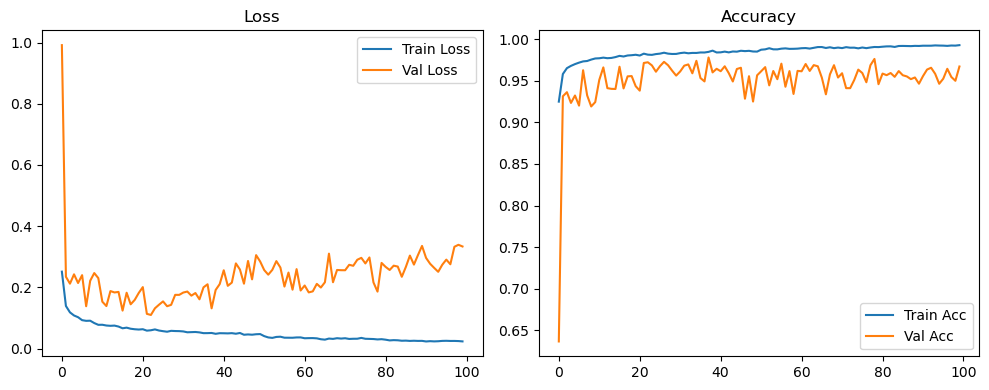

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1157, Acc: 0.9651 | Val Loss: 0.0622, Acc: 0.9819


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9841 | Val Loss: 0.0459, Acc: 0.9867


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9877 | Val Loss: 0.0448, Acc: 0.9868


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0370, Acc: 0.9888


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.0404, Acc: 0.9886


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.0414, Acc: 0.9890


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0475, Acc: 0.9872


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0509, Acc: 0.9867


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0536, Acc: 0.9857


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0531, Acc: 0.9875


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.0458, Acc: 0.9888


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0473, Acc: 0.9881


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0579, Acc: 0.9863


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0533, Acc: 0.9884


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0436, Acc: 0.9911


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0492, Acc: 0.9903


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0550, Acc: 0.9890


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0602, Acc: 0.9879


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0554, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0638, Acc: 0.9888


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0649, Acc: 0.9885


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0505, Acc: 0.9902


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0592, Acc: 0.9908


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0606, Acc: 0.9894


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0572, Acc: 0.9888


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0535, Acc: 0.9910


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0636, Acc: 0.9884


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0641, Acc: 0.9892


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0547, Acc: 0.9898


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0505, Acc: 0.9908


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0580, Acc: 0.9902


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0721, Acc: 0.9889


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0559, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0572, Acc: 0.9902


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0712, Acc: 0.9875


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0560, Acc: 0.9898


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0631, Acc: 0.9900


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0728, Acc: 0.9898


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0690, Acc: 0.9899


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0754, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0812, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0765, Acc: 0.9888


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0758, Acc: 0.9883


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0707, Acc: 0.9893


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0716, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0663, Acc: 0.9896


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0701, Acc: 0.9903


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0663, Acc: 0.9902


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0669, Acc: 0.9902


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0776, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0674, Acc: 0.9907


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0613, Acc: 0.9916


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0638, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0610, Acc: 0.9916


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0614, Acc: 0.9924


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0589, Acc: 0.9925


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0606, Acc: 0.9918


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0615, Acc: 0.9928


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9917


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0654, Acc: 0.9919


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0686, Acc: 0.9914


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0731, Acc: 0.9912


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9919


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0632, Acc: 0.9928


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0649, Acc: 0.9922


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0621, Acc: 0.9919


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0619, Acc: 0.9923


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0690, Acc: 0.9919


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9922


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9928


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0638, Acc: 0.9920


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9918


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0649, Acc: 0.9927


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0665, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0703, Acc: 0.9920


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9919


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0748, Acc: 0.9918


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0713, Acc: 0.9915


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0706, Acc: 0.9917


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0738, Acc: 0.9922


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0733, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0761, Acc: 0.9913


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0731, Acc: 0.9920


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0711, Acc: 0.9925


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0735, Acc: 0.9921


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0712, Acc: 0.9923


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9926


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0700, Acc: 0.9919


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0698, Acc: 0.9926


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0704, Acc: 0.9919


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0718, Acc: 0.9920


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0693, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0669, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9919


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0694, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0714, Acc: 0.9920


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0697, Acc: 0.9922


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0713, Acc: 0.9924


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0701, Acc: 0.9918


Final Test Loss: 0.0724 Accuracy: 0.9918


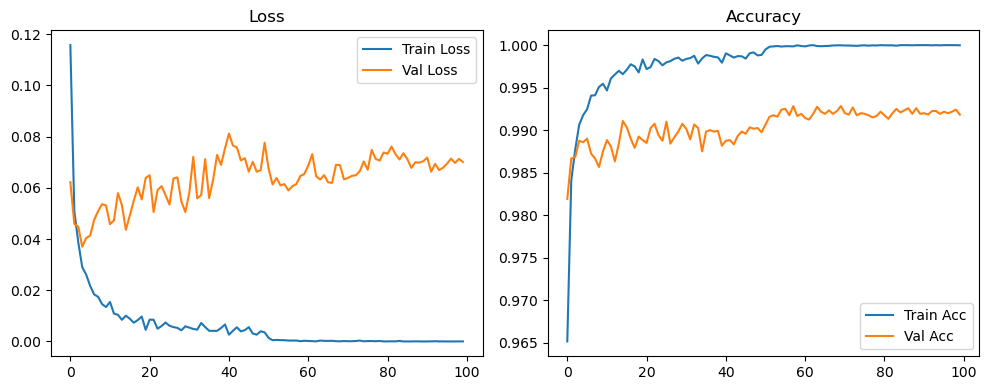

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1463, Acc: 0.9564 | Val Loss: 0.1324, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9784 | Val Loss: 0.1050, Acc: 0.9684


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9822 | Val Loss: 0.0625, Acc: 0.9798


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9840 | Val Loss: 0.0579, Acc: 0.9818


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9860 | Val Loss: 0.0607, Acc: 0.9819


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.0527, Acc: 0.9838


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 0.0470, Acc: 0.9865


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9891 | Val Loss: 0.0383, Acc: 0.9886


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0431, Acc: 0.9878


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.0453, Acc: 0.9867


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0428, Acc: 0.9871


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0371, Acc: 0.9892


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0466, Acc: 0.9858


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.0404, Acc: 0.9888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.0470, Acc: 0.9872


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0347, Acc: 0.9900


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0472, Acc: 0.9866


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9928 | Val Loss: 0.0445, Acc: 0.9867


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0385, Acc: 0.9900


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9945 | Val Loss: 0.0359, Acc: 0.9895


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0378, Acc: 0.9893


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0361, Acc: 0.9894


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0454, Acc: 0.9889


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0454, Acc: 0.9862


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0544, Acc: 0.9837


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0449, Acc: 0.9873


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0430, Acc: 0.9886


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0397, Acc: 0.9894


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0459, Acc: 0.9872


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0443, Acc: 0.9868


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0417, Acc: 0.9891


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0544, Acc: 0.9868


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0441, Acc: 0.9880


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0424, Acc: 0.9878


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0397, Acc: 0.9879


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0489, Acc: 0.9858


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0445, Acc: 0.9874


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0430, Acc: 0.9885


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.0470, Acc: 0.9878


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0448, Acc: 0.9883


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0400, Acc: 0.9894


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0459, Acc: 0.9868


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0447, Acc: 0.9878


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0457, Acc: 0.9873


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0422, Acc: 0.9892


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0471, Acc: 0.9883


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0450, Acc: 0.9872


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0419, Acc: 0.9887


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0725, Acc: 0.9800


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0431, Acc: 0.9880


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0434, Acc: 0.9868


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0459, Acc: 0.9874


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0429, Acc: 0.9885


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0365, Acc: 0.9905


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0444, Acc: 0.9888


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0348, Acc: 0.9915


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0420, Acc: 0.9897


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0383, Acc: 0.9904


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0376, Acc: 0.9898


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0418, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0396, Acc: 0.9905


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0407, Acc: 0.9898


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9987 | Val Loss: 0.0357, Acc: 0.9916


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0371, Acc: 0.9914


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0413, Acc: 0.9898


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0385, Acc: 0.9904


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0387, Acc: 0.9899


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0417, Acc: 0.9903


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0425, Acc: 0.9899


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0353, Acc: 0.9921


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0375, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0378, Acc: 0.9907


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0344, Acc: 0.9913


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0377, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0402, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0328, Acc: 0.9925


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0360, Acc: 0.9910


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0375, Acc: 0.9903


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0403, Acc: 0.9898


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0390, Acc: 0.9896


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0383, Acc: 0.9905


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0341, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0404, Acc: 0.9902


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0367, Acc: 0.9916


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0402, Acc: 0.9908


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0372, Acc: 0.9903


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0349, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0358, Acc: 0.9924


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0381, Acc: 0.9912


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0393, Acc: 0.9900


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0378, Acc: 0.9906


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0339, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0342, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0307, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0366, Acc: 0.9907


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0377, Acc: 0.9909


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0340, Acc: 0.9919


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0357, Acc: 0.9917


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0354, Acc: 0.9917


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0338, Acc: 0.9922


Final Test Loss: 0.0335 Accuracy: 0.9909


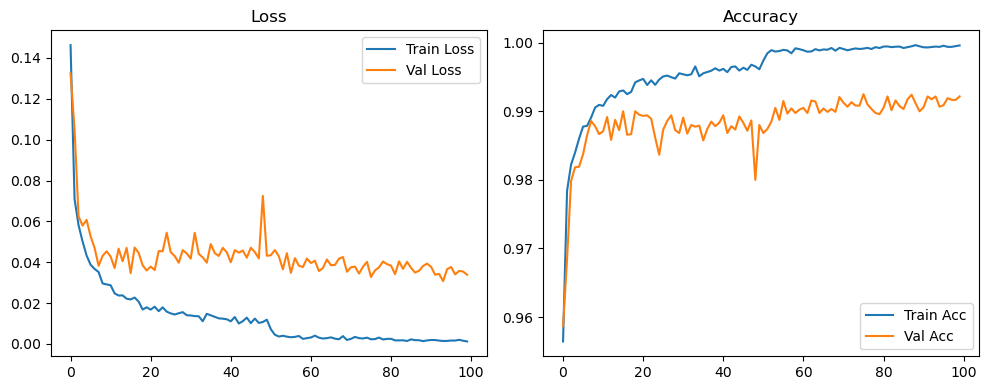

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2528, Acc: 0.9246 | Val Loss: 0.7063, Acc: 0.7588


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1412, Acc: 0.9588 | Val Loss: 0.4030, Acc: 0.8742


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1169, Acc: 0.9663 | Val Loss: 0.3495, Acc: 0.8771


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9685 | Val Loss: 0.2640, Acc: 0.9173


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1009, Acc: 0.9698 | Val Loss: 0.2226, Acc: 0.9265


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9712 | Val Loss: 0.1873, Acc: 0.9423


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9744 | Val Loss: 0.1201, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9725 | Val Loss: 0.1419, Acc: 0.9641


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9762 | Val Loss: 0.2588, Acc: 0.9167


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9768 | Val Loss: 0.2884, Acc: 0.9046


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9770 | Val Loss: 0.1788, Acc: 0.9417


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9769 | Val Loss: 0.1582, Acc: 0.9578


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9772 | Val Loss: 0.2148, Acc: 0.9327


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9780 | Val Loss: 0.1417, Acc: 0.9577


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9787 | Val Loss: 0.1400, Acc: 0.9577


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9791 | Val Loss: 0.1693, Acc: 0.9537


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9793 | Val Loss: 0.1426, Acc: 0.9560


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9805 | Val Loss: 0.1683, Acc: 0.9485


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9803 | Val Loss: 0.1296, Acc: 0.9647


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9815 | Val Loss: 0.1633, Acc: 0.9511


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9812 | Val Loss: 0.1648, Acc: 0.9471


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9824 | Val Loss: 0.1414, Acc: 0.9616


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9812 | Val Loss: 0.1280, Acc: 0.9751


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9818 | Val Loss: 0.1325, Acc: 0.9724


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9812 | Val Loss: 0.1427, Acc: 0.9605


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9823 | Val Loss: 0.1398, Acc: 0.9683


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9823 | Val Loss: 0.1349, Acc: 0.9665


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9827 | Val Loss: 0.1387, Acc: 0.9677


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9829 | Val Loss: 0.1716, Acc: 0.9681


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9825 | Val Loss: 0.1524, Acc: 0.9646


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9832 | Val Loss: 0.1277, Acc: 0.9760


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9843 | Val Loss: 0.1684, Acc: 0.9675


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9836 | Val Loss: 0.1490, Acc: 0.9726


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9836 | Val Loss: 0.1810, Acc: 0.9544


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9844 | Val Loss: 0.1312, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9835 | Val Loss: 0.1815, Acc: 0.9577


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 0.1240, Acc: 0.9696


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0921, Acc: 0.9743


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9850 | Val Loss: 0.1164, Acc: 0.9802


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9848 | Val Loss: 0.1481, Acc: 0.9758


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9841 | Val Loss: 0.1822, Acc: 0.9543


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9850 | Val Loss: 0.1493, Acc: 0.9712


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9849 | Val Loss: 0.2101, Acc: 0.9589


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.1955, Acc: 0.9480


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9853 | Val Loss: 0.1413, Acc: 0.9697


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.1487, Acc: 0.9688


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9852 | Val Loss: 0.2721, Acc: 0.9239


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9858 | Val Loss: 0.1407, Acc: 0.9660


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9850 | Val Loss: 0.2628, Acc: 0.9613


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9855 | Val Loss: 0.3260, Acc: 0.9141


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.2550, Acc: 0.9464


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.2418, Acc: 0.9542


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9890 | Val Loss: 0.2519, Acc: 0.9553


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.2628, Acc: 0.9599


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.2055, Acc: 0.9570


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.1927, Acc: 0.9746


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9900 | Val Loss: 0.2137, Acc: 0.9633


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.1877, Acc: 0.9692


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.1725, Acc: 0.9717


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.1949, Acc: 0.9642


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.2082, Acc: 0.9642


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.1824, Acc: 0.9690


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.1989, Acc: 0.9656


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9901 | Val Loss: 0.1987, Acc: 0.9683


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.1805, Acc: 0.9740


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.2163, Acc: 0.9652


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9911 | Val Loss: 0.2087, Acc: 0.9673


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.1608, Acc: 0.9741


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.1857, Acc: 0.9732


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.1668, Acc: 0.9742


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.1914, Acc: 0.9713


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.2304, Acc: 0.9595


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.2510, Acc: 0.9619


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9911 | Val Loss: 0.2043, Acc: 0.9739


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.2292, Acc: 0.9651


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.2039, Acc: 0.9691


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9912 | Val Loss: 0.1968, Acc: 0.9702


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.1989, Acc: 0.9667


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9921 | Val Loss: 0.1944, Acc: 0.9719


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9917 | Val Loss: 0.1923, Acc: 0.9716


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1719, Acc: 0.9724


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.1880, Acc: 0.9708


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9917 | Val Loss: 0.2028, Acc: 0.9680


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.2064, Acc: 0.9723


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9923 | Val Loss: 0.1761, Acc: 0.9728


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1978, Acc: 0.9702


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.2165, Acc: 0.9728


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9921 | Val Loss: 0.2075, Acc: 0.9662


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.1987, Acc: 0.9743


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.2236, Acc: 0.9742


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.2176, Acc: 0.9728


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.2232, Acc: 0.9705


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.2151, Acc: 0.9677


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.2183, Acc: 0.9672


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.2258, Acc: 0.9673


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9920 | Val Loss: 0.2084, Acc: 0.9731


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.2370, Acc: 0.9702


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9923 | Val Loss: 0.2259, Acc: 0.9694


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.2220, Acc: 0.9656


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9922 | Val Loss: 0.2082, Acc: 0.9733


Final Test Loss: 0.2046 Accuracy: 0.9711


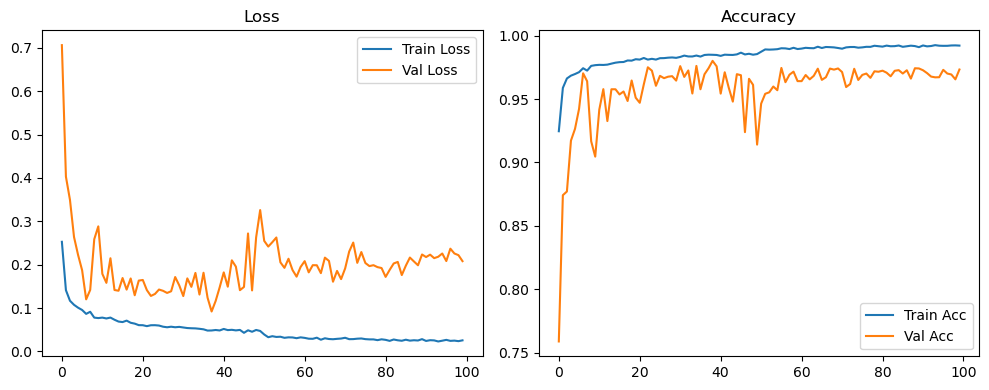

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1161, Acc: 0.9669 | Val Loss: 0.0543, Acc: 0.9832


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9856 | Val Loss: 0.0422, Acc: 0.9884


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0503, Acc: 0.9846


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.0392, Acc: 0.9888


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0463, Acc: 0.9866


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0376, Acc: 0.9891


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0532, Acc: 0.9852


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0419, Acc: 0.9876


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0345, Acc: 0.9901


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0398, Acc: 0.9902


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0491, Acc: 0.9891


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0461, Acc: 0.9895


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0466, Acc: 0.9878


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0465, Acc: 0.9898


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9966 | Val Loss: 0.0503, Acc: 0.9897


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0479, Acc: 0.9902


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0495, Acc: 0.9892


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0410, Acc: 0.9910


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0440, Acc: 0.9900


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0486, Acc: 0.9898


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0464, Acc: 0.9899


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.0428, Acc: 0.9897


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0412, Acc: 0.9912


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0526, Acc: 0.9892


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0706, Acc: 0.9875


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0531, Acc: 0.9902


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0562, Acc: 0.9908


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0701, Acc: 0.9872


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0570, Acc: 0.9895


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0469, Acc: 0.9909


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0543, Acc: 0.9908


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0493, Acc: 0.9908


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0503, Acc: 0.9908


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0553, Acc: 0.9910


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0540, Acc: 0.9908


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0520, Acc: 0.9908


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0685, Acc: 0.9884


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0530, Acc: 0.9905


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0508, Acc: 0.9912


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0630, Acc: 0.9879


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0703, Acc: 0.9894


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0668, Acc: 0.9902


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0595, Acc: 0.9900


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0560, Acc: 0.9915


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0639, Acc: 0.9902


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0538, Acc: 0.9909


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0606, Acc: 0.9909


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0688, Acc: 0.9898


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0590, Acc: 0.9906


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0641, Acc: 0.9899


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0631, Acc: 0.9904


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0588, Acc: 0.9901


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0550, Acc: 0.9911


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0661, Acc: 0.9888


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0674, Acc: 0.9908


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0708, Acc: 0.9912


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0695, Acc: 0.9905


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0695, Acc: 0.9898


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0688, Acc: 0.9902


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0718, Acc: 0.9902


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0648, Acc: 0.9903


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0556, Acc: 0.9925


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0625, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0670, Acc: 0.9909


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0672, Acc: 0.9900


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0639, Acc: 0.9904


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0634, Acc: 0.9898


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0584, Acc: 0.9914


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0588, Acc: 0.9908


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0640, Acc: 0.9903


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0666, Acc: 0.9899


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0800, Acc: 0.9893


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0690, Acc: 0.9901


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0649, Acc: 0.9908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0705, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0719, Acc: 0.9905


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0696, Acc: 0.9907


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0651, Acc: 0.9905


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0651, Acc: 0.9913


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0839, Acc: 0.9894


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0747, Acc: 0.9897


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0643, Acc: 0.9908


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0649, Acc: 0.9918


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0698, Acc: 0.9902


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0822, Acc: 0.9892


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0697, Acc: 0.9912


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0701, Acc: 0.9898


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0746, Acc: 0.9896


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0816, Acc: 0.9896


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0729, Acc: 0.9903


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0812, Acc: 0.9900


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0719, Acc: 0.9906


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0839, Acc: 0.9894


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0740, Acc: 0.9904


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0811, Acc: 0.9891


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0840, Acc: 0.9899


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0665, Acc: 0.9918


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0754, Acc: 0.9899


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0630, Acc: 0.9906


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0644, Acc: 0.9921


Final Test Loss: 0.0877 Accuracy: 0.9890


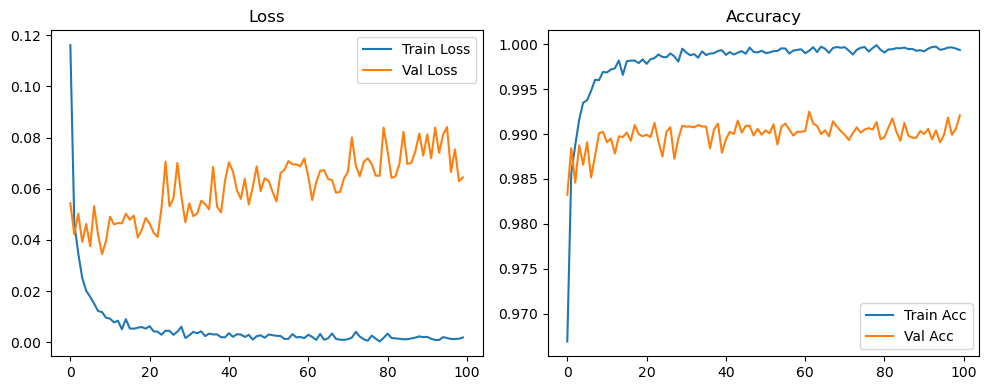

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1443, Acc: 0.9606 | Val Loss: 0.1096, Acc: 0.9650


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0678, Acc: 0.9795 | Val Loss: 0.0533, Acc: 0.9838


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 0.0651, Acc: 0.9808


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9850 | Val Loss: 0.0519, Acc: 0.9827


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.0464, Acc: 0.9855


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.0557, Acc: 0.9832


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 0.0544, Acc: 0.9844


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9904 | Val Loss: 0.0425, Acc: 0.9882


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0527, Acc: 0.9838


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.0430, Acc: 0.9872


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0595, Acc: 0.9817


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0436, Acc: 0.9882


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0527, Acc: 0.9842


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.0359, Acc: 0.9897


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0503, Acc: 0.9859


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.0450, Acc: 0.9877


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0465, Acc: 0.9878


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0428, Acc: 0.9880


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.0410, Acc: 0.9891


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0468, Acc: 0.9873


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0376, Acc: 0.9895


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0435, Acc: 0.9878


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0394, Acc: 0.9894


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0426, Acc: 0.9878


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0415, Acc: 0.9887


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0399, Acc: 0.9888


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0427, Acc: 0.9883


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0414, Acc: 0.9884


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0564, Acc: 0.9843


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0491, Acc: 0.9873


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0438, Acc: 0.9888


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0389, Acc: 0.9898


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0354, Acc: 0.9902


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0389, Acc: 0.9901


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0457, Acc: 0.9886


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0421, Acc: 0.9880


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0460, Acc: 0.9876


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0427, Acc: 0.9888


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0450, Acc: 0.9884


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0415, Acc: 0.9889


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0496, Acc: 0.9865


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0468, Acc: 0.9872


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0476, Acc: 0.9870


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0403, Acc: 0.9902


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0542, Acc: 0.9846


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0374, Acc: 0.9901


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0425, Acc: 0.9883


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0402, Acc: 0.9890


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0473, Acc: 0.9874


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0367, Acc: 0.9908


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0384, Acc: 0.9892


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0448, Acc: 0.9883


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0434, Acc: 0.9887


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0446, Acc: 0.9891


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0455, Acc: 0.9880


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0427, Acc: 0.9882


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0421, Acc: 0.9892


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0409, Acc: 0.9889


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0481, Acc: 0.9870


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0438, Acc: 0.9885


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0439, Acc: 0.9890


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0420, Acc: 0.9867


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0425, Acc: 0.9888


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0384, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0437, Acc: 0.9882


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0462, Acc: 0.9874


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0428, Acc: 0.9892


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0471, Acc: 0.9861


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0501, Acc: 0.9873


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0530, Acc: 0.9870


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0460, Acc: 0.9886


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0595, Acc: 0.9831


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0451, Acc: 0.9879


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0431, Acc: 0.9883


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0455, Acc: 0.9882


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0394, Acc: 0.9892


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0488, Acc: 0.9872


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0423, Acc: 0.9882


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0373, Acc: 0.9895


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0470, Acc: 0.9875


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0501, Acc: 0.9866


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0472, Acc: 0.9879


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0423, Acc: 0.9888


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0465, Acc: 0.9872


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0454, Acc: 0.9874


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0448, Acc: 0.9882


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0447, Acc: 0.9883


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.0422, Acc: 0.9895


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0443, Acc: 0.9884


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0454, Acc: 0.9878


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0404, Acc: 0.9900


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0431, Acc: 0.9878


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0506, Acc: 0.9860


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0398, Acc: 0.9890


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0413, Acc: 0.9896


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0384, Acc: 0.9893


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0386, Acc: 0.9898


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0539, Acc: 0.9857


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0380, Acc: 0.9902


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0528, Acc: 0.9849


Final Test Loss: 0.0504 Accuracy: 0.9845


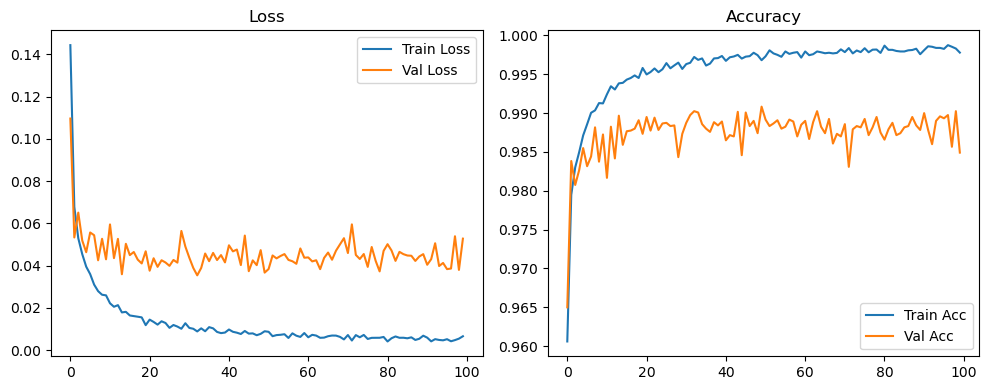

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2448, Acc: 0.9303 | Val Loss: 0.7048, Acc: 0.7434


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1324, Acc: 0.9617 | Val Loss: 0.3723, Acc: 0.8728


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1085, Acc: 0.9682 | Val Loss: 0.4372, Acc: 0.8400


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1016, Acc: 0.9695 | Val Loss: 0.1908, Acc: 0.9449


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0917, Acc: 0.9735 | Val Loss: 0.2152, Acc: 0.9305


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0858, Acc: 0.9737 | Val Loss: 0.2584, Acc: 0.9113


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0779, Acc: 0.9765 | Val Loss: 0.1284, Acc: 0.9643


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9760 | Val Loss: 0.1449, Acc: 0.9588


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0744, Acc: 0.9780 | Val Loss: 0.1308, Acc: 0.9651


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9777 | Val Loss: 0.1570, Acc: 0.9534


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9790 | Val Loss: 0.1143, Acc: 0.9714


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9792 | Val Loss: 0.1192, Acc: 0.9694


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9797 | Val Loss: 0.1449, Acc: 0.9587


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0660, Acc: 0.9807 | Val Loss: 0.1205, Acc: 0.9693


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9816 | Val Loss: 0.1317, Acc: 0.9668


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9819 | Val Loss: 0.1143, Acc: 0.9753


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9812 | Val Loss: 0.1295, Acc: 0.9677


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9822 | Val Loss: 0.1664, Acc: 0.9518


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9831 | Val Loss: 0.1303, Acc: 0.9641


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9832 | Val Loss: 0.1761, Acc: 0.9530


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9826 | Val Loss: 0.1208, Acc: 0.9774


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9834 | Val Loss: 0.1135, Acc: 0.9758


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 0.1049, Acc: 0.9828


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9834 | Val Loss: 0.1184, Acc: 0.9792


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9834 | Val Loss: 0.1957, Acc: 0.9450


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9844 | Val Loss: 0.1573, Acc: 0.9634


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9850 | Val Loss: 0.1745, Acc: 0.9537


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9847 | Val Loss: 0.1909, Acc: 0.9559


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9846 | Val Loss: 0.1514, Acc: 0.9702


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9849 | Val Loss: 0.1954, Acc: 0.9517


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9854 | Val Loss: 0.1618, Acc: 0.9609


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9857 | Val Loss: 0.2052, Acc: 0.9478


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9846 | Val Loss: 0.1872, Acc: 0.9633


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9855 | Val Loss: 0.1672, Acc: 0.9613


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9861 | Val Loss: 0.1483, Acc: 0.9725


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.1441, Acc: 0.9675


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1908, Acc: 0.9665


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.1859, Acc: 0.9558


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9866 | Val Loss: 0.2046, Acc: 0.9595


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9856 | Val Loss: 0.1992, Acc: 0.9589


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9860 | Val Loss: 0.2126, Acc: 0.9683


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 0.2067, Acc: 0.9609


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9868 | Val Loss: 0.2147, Acc: 0.9523


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.1771, Acc: 0.9749


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9870 | Val Loss: 0.2405, Acc: 0.9417


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.1615, Acc: 0.9792


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9862 | Val Loss: 0.1842, Acc: 0.9697


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.1933, Acc: 0.9725


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.2241, Acc: 0.9462


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9874 | Val Loss: 0.2057, Acc: 0.9677


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9874 | Val Loss: 0.2046, Acc: 0.9577


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.2002, Acc: 0.9644


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.2390, Acc: 0.9664


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.2152, Acc: 0.9711


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.2405, Acc: 0.9633


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.2535, Acc: 0.9597


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 0.2556, Acc: 0.9541


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9878 | Val Loss: 0.1734, Acc: 0.9758


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.2057, Acc: 0.9595


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.2483, Acc: 0.9630


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 0.3032, Acc: 0.9489


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9891 | Val Loss: 0.2858, Acc: 0.9608


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.2402, Acc: 0.9674


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.3091, Acc: 0.9317


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9892 | Val Loss: 0.2562, Acc: 0.9490


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.2057, Acc: 0.9557


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9885 | Val Loss: 0.3244, Acc: 0.9397


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9886 | Val Loss: 0.3065, Acc: 0.9581


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.2690, Acc: 0.9549


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.2766, Acc: 0.9404


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.2784, Acc: 0.9468


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.4417, Acc: 0.9137


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9896 | Val Loss: 0.2969, Acc: 0.9424


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9888 | Val Loss: 0.3008, Acc: 0.9437


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9884 | Val Loss: 0.2493, Acc: 0.9708


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9891 | Val Loss: 0.3375, Acc: 0.9434


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.2929, Acc: 0.9443


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9893 | Val Loss: 0.2724, Acc: 0.9660


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.3771, Acc: 0.9431


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.3115, Acc: 0.9538


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.3750, Acc: 0.9478


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.3237, Acc: 0.9496


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.3470, Acc: 0.9483


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9898 | Val Loss: 0.2936, Acc: 0.9538


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.3327, Acc: 0.9543


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.2580, Acc: 0.9702


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.3391, Acc: 0.9647


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9897 | Val Loss: 0.3945, Acc: 0.9017


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 0.3638, Acc: 0.9515


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.4414, Acc: 0.9363


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 0.3750, Acc: 0.9481


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.4413, Acc: 0.9464


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.5160, Acc: 0.9068


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.5276, Acc: 0.9326


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9901 | Val Loss: 0.4868, Acc: 0.9009


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.6279, Acc: 0.9187


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.4781, Acc: 0.9221


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.5180, Acc: 0.9281


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9890 | Val Loss: 0.5685, Acc: 0.9332


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9901 | Val Loss: 0.5529, Acc: 0.9360


Final Test Loss: 0.5559 Accuracy: 0.9361


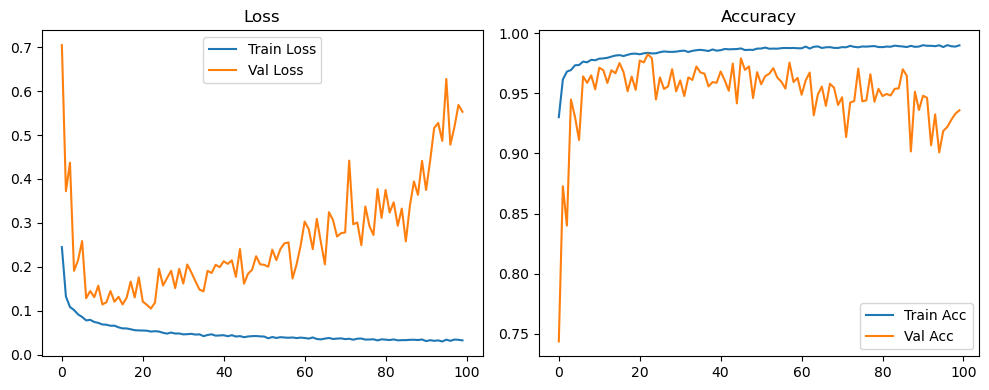

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1147, Acc: 0.9672 | Val Loss: 0.0556, Acc: 0.9823


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9856 | Val Loss: 0.0425, Acc: 0.9880


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.0517, Acc: 0.9852


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0422, Acc: 0.9882


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9929 | Val Loss: 0.0455, Acc: 0.9871


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.0406, Acc: 0.9882


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0401, Acc: 0.9892


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0464, Acc: 0.9872


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0446, Acc: 0.9886


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9959 | Val Loss: 0.0441, Acc: 0.9892


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0507, Acc: 0.9883


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0427, Acc: 0.9898


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0493, Acc: 0.9892


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0484, Acc: 0.9881


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0632, Acc: 0.9859


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.0580, Acc: 0.9869


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0566, Acc: 0.9874


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0503, Acc: 0.9899


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0547, Acc: 0.9882


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0481, Acc: 0.9901


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0540, Acc: 0.9897


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0481, Acc: 0.9904


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0427, Acc: 0.9909


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0431, Acc: 0.9908


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0515, Acc: 0.9898


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0505, Acc: 0.9902


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0530, Acc: 0.9897


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0537, Acc: 0.9904


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0451, Acc: 0.9911


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0557, Acc: 0.9895


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0512, Acc: 0.9918


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0530, Acc: 0.9908


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0557, Acc: 0.9898


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0490, Acc: 0.9907


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0535, Acc: 0.9897


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0538, Acc: 0.9905


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0545, Acc: 0.9899


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0585, Acc: 0.9898


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0628, Acc: 0.9905


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0499, Acc: 0.9913


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0514, Acc: 0.9911


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0595, Acc: 0.9911


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0625, Acc: 0.9897


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0565, Acc: 0.9908


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0620, Acc: 0.9891


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0542, Acc: 0.9907


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0552, Acc: 0.9908


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0585, Acc: 0.9911


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0589, Acc: 0.9898


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0550, Acc: 0.9919


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0501, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0504, Acc: 0.9916


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0458, Acc: 0.9929


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9931


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0464, Acc: 0.9931


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9924


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0489, Acc: 0.9921


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0495, Acc: 0.9923


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9919


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0540, Acc: 0.9920


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0530, Acc: 0.9910


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0547, Acc: 0.9919


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9923


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9927


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0569, Acc: 0.9920


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0598, Acc: 0.9917


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0583, Acc: 0.9913


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9918


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9913


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9911


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0602, Acc: 0.9914


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0580, Acc: 0.9920


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0671, Acc: 0.9919


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0617, Acc: 0.9919


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0666, Acc: 0.9909


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0617, Acc: 0.9912


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0592, Acc: 0.9919


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9922


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0564, Acc: 0.9928


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9928


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9930


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9923


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9923


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0622, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9917


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9921


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9919


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9921


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0642, Acc: 0.9925


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9926


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9925


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9925


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9921


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9924


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9930


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9925


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0637, Acc: 0.9922


Final Test Loss: 0.0473 Accuracy: 0.9922


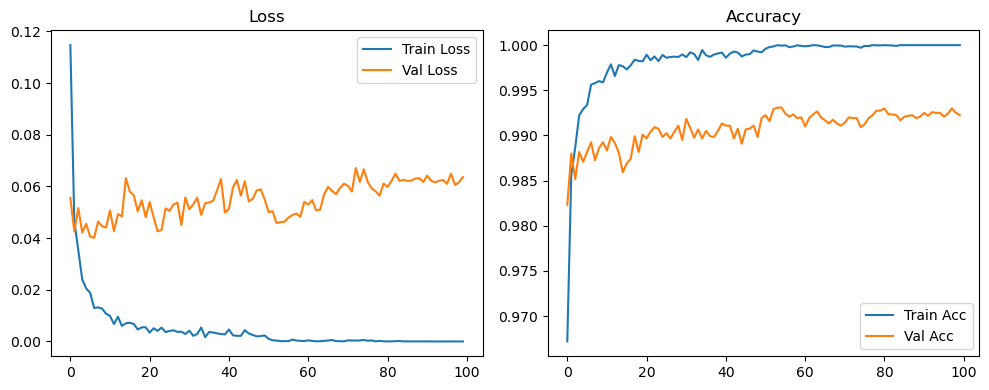

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1427, Acc: 0.9610 | Val Loss: 0.1462, Acc: 0.9551


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9789 | Val Loss: 0.0542, Acc: 0.9837


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9828 | Val Loss: 0.0491, Acc: 0.9851


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9848 | Val Loss: 0.0596, Acc: 0.9792


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0668, Acc: 0.9795


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0556, Acc: 0.9832


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0392, Acc: 0.9881


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0573, Acc: 0.9811


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0428, Acc: 0.9879


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0550, Acc: 0.9845


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0554, Acc: 0.9843


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0426, Acc: 0.9871


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0507, Acc: 0.9858


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0485, Acc: 0.9865


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.0434, Acc: 0.9883


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0442, Acc: 0.9883


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0454, Acc: 0.9877


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0468, Acc: 0.9884


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0465, Acc: 0.9870


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0411, Acc: 0.9886


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0423, Acc: 0.9875


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9951 | Val Loss: 0.0386, Acc: 0.9898


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9949 | Val Loss: 0.0381, Acc: 0.9887


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0346, Acc: 0.9900


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0565, Acc: 0.9844


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9958 | Val Loss: 0.0452, Acc: 0.9873


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0394, Acc: 0.9882


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0413, Acc: 0.9884


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0396, Acc: 0.9897


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0459, Acc: 0.9871


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0443, Acc: 0.9882


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0537, Acc: 0.9857


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0402, Acc: 0.9882


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0463, Acc: 0.9868


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0401, Acc: 0.9880


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0621, Acc: 0.9838


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0427, Acc: 0.9888


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0405, Acc: 0.9886


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.0421, Acc: 0.9888


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0373, Acc: 0.9893


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0400, Acc: 0.9898


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0379, Acc: 0.9885


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0409, Acc: 0.9886


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0478, Acc: 0.9871


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0437, Acc: 0.9868


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0312, Acc: 0.9911


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0407, Acc: 0.9879


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0331, Acc: 0.9912


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0406, Acc: 0.9883


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0390, Acc: 0.9902


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0359, Acc: 0.9911


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0413, Acc: 0.9887


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0334, Acc: 0.9922


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0331, Acc: 0.9922


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0375, Acc: 0.9895


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0344, Acc: 0.9909


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9895


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0341, Acc: 0.9910


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0341, Acc: 0.9908


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0364, Acc: 0.9911


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0379, Acc: 0.9906


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0384, Acc: 0.9908


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0361, Acc: 0.9902


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0337, Acc: 0.9909


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0386, Acc: 0.9902


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0355, Acc: 0.9907


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0332, Acc: 0.9915


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0376, Acc: 0.9904


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0382, Acc: 0.9908


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0378, Acc: 0.9901


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0428, Acc: 0.9888


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0391, Acc: 0.9892


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0392, Acc: 0.9892


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0378, Acc: 0.9892


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0421, Acc: 0.9893


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0357, Acc: 0.9902


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0399, Acc: 0.9897


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0385, Acc: 0.9903


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0364, Acc: 0.9911


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0362, Acc: 0.9900


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0347, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0360, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0338, Acc: 0.9919


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0346, Acc: 0.9902


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0343, Acc: 0.9911


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0374, Acc: 0.9890


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0336, Acc: 0.9908


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0360, Acc: 0.9906


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9992 | Val Loss: 0.0323, Acc: 0.9917


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0319, Acc: 0.9918


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0377, Acc: 0.9902


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0343, Acc: 0.9912


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0337, Acc: 0.9912


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0346, Acc: 0.9916


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0331, Acc: 0.9920


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0355, Acc: 0.9909


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0330, Acc: 0.9918


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0371, Acc: 0.9903


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0357, Acc: 0.9912


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0318, Acc: 0.9912


Final Test Loss: 0.0345 Accuracy: 0.9906


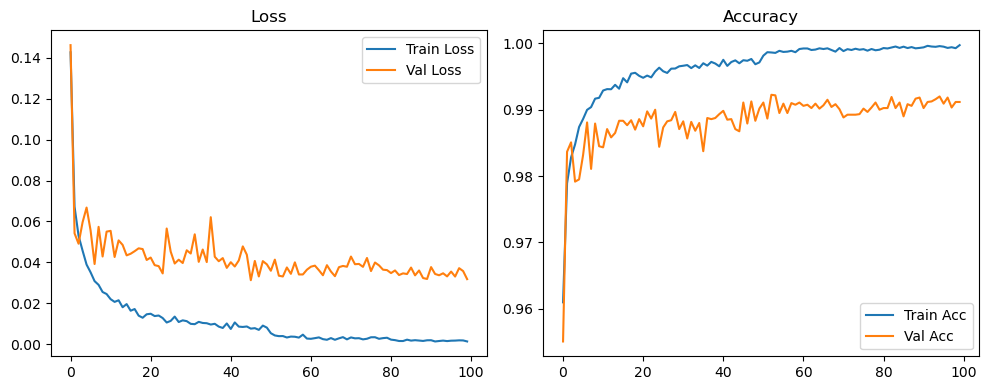

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2470, Acc: 0.9311 | Val Loss: 0.6273, Acc: 0.7737


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1322, Acc: 0.9621 | Val Loss: 0.3403, Acc: 0.8816


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1091, Acc: 0.9678 | Val Loss: 0.2766, Acc: 0.9089


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1002, Acc: 0.9699 | Val Loss: 0.2115, Acc: 0.9358


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9719 | Val Loss: 0.1642, Acc: 0.9527


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0862, Acc: 0.9745 | Val Loss: 0.1669, Acc: 0.9489


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9760 | Val Loss: 0.1277, Acc: 0.9683


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9757 | Val Loss: 0.1441, Acc: 0.9627


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0750, Acc: 0.9774 | Val Loss: 0.1898, Acc: 0.9439


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9786 | Val Loss: 0.2043, Acc: 0.9352


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9790 | Val Loss: 0.1466, Acc: 0.9623


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9786 | Val Loss: 0.1117, Acc: 0.9742


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9810 | Val Loss: 0.1480, Acc: 0.9611


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0666, Acc: 0.9801 | Val Loss: 0.1215, Acc: 0.9666


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9809 | Val Loss: 0.1325, Acc: 0.9672


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9812 | Val Loss: 0.1392, Acc: 0.9637


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0599, Acc: 0.9813 | Val Loss: 0.1289, Acc: 0.9688


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9819 | Val Loss: 0.1487, Acc: 0.9596


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9822 | Val Loss: 0.1397, Acc: 0.9603


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9832 | Val Loss: 0.1376, Acc: 0.9591


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9830 | Val Loss: 0.1453, Acc: 0.9616


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9834 | Val Loss: 0.1108, Acc: 0.9778


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9845 | Val Loss: 0.1514, Acc: 0.9673


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9831 | Val Loss: 0.1366, Acc: 0.9691


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9844 | Val Loss: 0.1564, Acc: 0.9609


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9841 | Val Loss: 0.1370, Acc: 0.9702


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9850 | Val Loss: 0.1615, Acc: 0.9574


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 0.1410, Acc: 0.9720


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9853 | Val Loss: 0.1783, Acc: 0.9647


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.1679, Acc: 0.9598


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.1850, Acc: 0.9547


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9854 | Val Loss: 0.1991, Acc: 0.9553


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9855 | Val Loss: 0.1728, Acc: 0.9615


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9856 | Val Loss: 0.1669, Acc: 0.9676


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9860 | Val Loss: 0.1475, Acc: 0.9662


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.1562, Acc: 0.9755


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9858 | Val Loss: 0.1502, Acc: 0.9699


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 0.1927, Acc: 0.9533


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9860 | Val Loss: 0.2080, Acc: 0.9622


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.1818, Acc: 0.9613


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9862 | Val Loss: 0.2308, Acc: 0.9583


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9866 | Val Loss: 0.1818, Acc: 0.9607


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 0.2436, Acc: 0.9539


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9860 | Val Loss: 0.2215, Acc: 0.9617


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.2735, Acc: 0.9547


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9876 | Val Loss: 0.2086, Acc: 0.9556


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.2336, Acc: 0.9464


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.2297, Acc: 0.9711


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.2382, Acc: 0.9539


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9872 | Val Loss: 0.2403, Acc: 0.9658


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9890 | Val Loss: 0.2094, Acc: 0.9698


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.2244, Acc: 0.9636


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9897 | Val Loss: 0.2586, Acc: 0.9598


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9889 | Val Loss: 0.2539, Acc: 0.9643


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.2130, Acc: 0.9636


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.1772, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.2486, Acc: 0.9646


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.2527, Acc: 0.9708


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.2703, Acc: 0.9663


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.2213, Acc: 0.9744


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.2273, Acc: 0.9685


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.1987, Acc: 0.9734


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.2322, Acc: 0.9728


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.2954, Acc: 0.9656


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.2581, Acc: 0.9557


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9901 | Val Loss: 0.2736, Acc: 0.9573


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9899 | Val Loss: 0.2552, Acc: 0.9646


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.2721, Acc: 0.9577


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.2475, Acc: 0.9680


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.2998, Acc: 0.9518


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9912 | Val Loss: 0.2844, Acc: 0.9634


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.2813, Acc: 0.9483


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.3476, Acc: 0.9414


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.2620, Acc: 0.9665


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.2642, Acc: 0.9703


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.3228, Acc: 0.9682


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9908 | Val Loss: 0.2756, Acc: 0.9637


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.3258, Acc: 0.9523


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.3045, Acc: 0.9597


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.2924, Acc: 0.9605


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.3012, Acc: 0.9718


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.3077, Acc: 0.9669


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.3185, Acc: 0.9729


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.3250, Acc: 0.9619


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.3003, Acc: 0.9671


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.3573, Acc: 0.9582


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.3612, Acc: 0.9596


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.3488, Acc: 0.9566


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.3702, Acc: 0.9512


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.3774, Acc: 0.9553


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.3505, Acc: 0.9618


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.3636, Acc: 0.9518


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9929 | Val Loss: 0.3444, Acc: 0.9673


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.3479, Acc: 0.9531


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.3076, Acc: 0.9596


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.3724, Acc: 0.9513


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.3652, Acc: 0.9547


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.3953, Acc: 0.9483


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.3902, Acc: 0.9492


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.3919, Acc: 0.9565


Final Test Loss: 0.3916 Accuracy: 0.9563


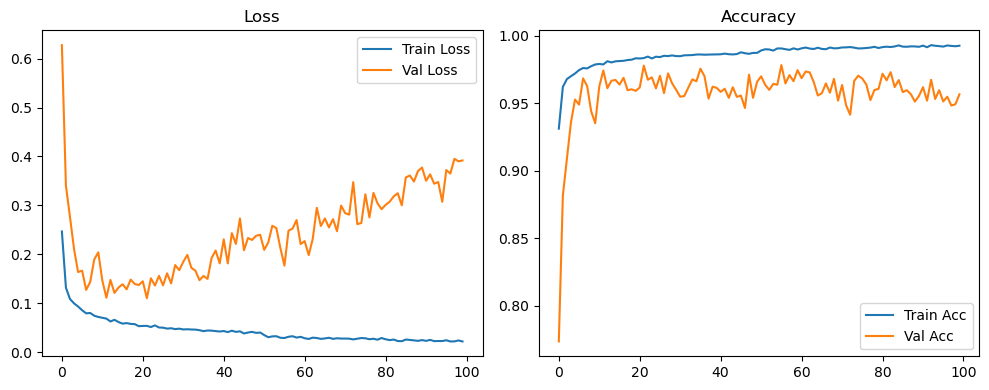

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1285, Acc: 0.9691 | Val Loss: 0.0527, Acc: 0.9833


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9864 | Val Loss: 0.0440, Acc: 0.9868


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.0371, Acc: 0.9898


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.0359, Acc: 0.9890


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0416, Acc: 0.9881


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0356, Acc: 0.9885


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0400, Acc: 0.9882


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0440, Acc: 0.9884


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0452, Acc: 0.9886


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0447, Acc: 0.9890


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0495, Acc: 0.9879


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0379, Acc: 0.9897


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0419, Acc: 0.9898


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0460, Acc: 0.9886


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0490, Acc: 0.9879


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0474, Acc: 0.9893


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0485, Acc: 0.9888


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0437, Acc: 0.9892


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0410, Acc: 0.9900


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0371, Acc: 0.9902


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0440, Acc: 0.9905


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0441, Acc: 0.9908


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0490, Acc: 0.9890


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0444, Acc: 0.9899


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0486, Acc: 0.9892


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0455, Acc: 0.9904


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0449, Acc: 0.9914


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0468, Acc: 0.9908


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0434, Acc: 0.9911


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0513, Acc: 0.9898


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0468, Acc: 0.9918


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0549, Acc: 0.9887


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0483, Acc: 0.9902


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0542, Acc: 0.9902


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0486, Acc: 0.9899


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0474, Acc: 0.9909


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0489, Acc: 0.9900


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0527, Acc: 0.9904


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0626, Acc: 0.9892


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0511, Acc: 0.9898


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0496, Acc: 0.9908


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0524, Acc: 0.9898


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0514, Acc: 0.9898


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0489, Acc: 0.9910


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0564, Acc: 0.9906


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0549, Acc: 0.9893


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0560, Acc: 0.9901


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0521, Acc: 0.9912


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0485, Acc: 0.9907


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0549, Acc: 0.9902


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0544, Acc: 0.9905


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0630, Acc: 0.9889


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0506, Acc: 0.9907


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0577, Acc: 0.9897


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0491, Acc: 0.9913


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0506, Acc: 0.9910


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0560, Acc: 0.9902


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0541, Acc: 0.9906


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0476, Acc: 0.9915


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0523, Acc: 0.9903


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0562, Acc: 0.9889


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0549, Acc: 0.9904


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0516, Acc: 0.9909


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0511, Acc: 0.9914


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0565, Acc: 0.9895


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0534, Acc: 0.9909


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0538, Acc: 0.9914


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0514, Acc: 0.9921


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0551, Acc: 0.9914


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0509, Acc: 0.9911


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0513, Acc: 0.9908


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0548, Acc: 0.9916


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0521, Acc: 0.9908


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0600, Acc: 0.9902


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0544, Acc: 0.9915


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0461, Acc: 0.9917


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9910


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0570, Acc: 0.9908


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0609, Acc: 0.9912


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0583, Acc: 0.9908


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0598, Acc: 0.9905


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0605, Acc: 0.9911


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0597, Acc: 0.9917


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0586, Acc: 0.9910


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0610, Acc: 0.9908


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0584, Acc: 0.9913


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0549, Acc: 0.9916


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0599, Acc: 0.9912


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0634, Acc: 0.9900


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0559, Acc: 0.9921


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0625, Acc: 0.9910


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0513, Acc: 0.9916


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0500, Acc: 0.9923


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0492, Acc: 0.9932


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0572, Acc: 0.9912


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0521, Acc: 0.9915


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0541, Acc: 0.9927


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0593, Acc: 0.9903


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0584, Acc: 0.9912


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0590, Acc: 0.9912


Final Test Loss: 0.0644 Accuracy: 0.9912


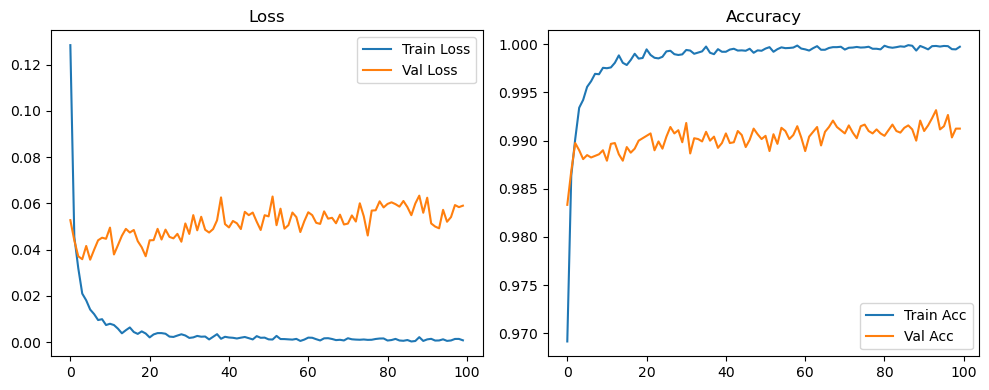

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1597, Acc: 0.9621 | Val Loss: 0.1349, Acc: 0.9580


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9800 | Val Loss: 0.0625, Acc: 0.9812


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9837 | Val Loss: 0.0692, Acc: 0.9789


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.0518, Acc: 0.9839


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9886 | Val Loss: 0.0480, Acc: 0.9848


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0515, Acc: 0.9845


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0599, Acc: 0.9824


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.0435, Acc: 0.9870


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.0349, Acc: 0.9892


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0453, Acc: 0.9864


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0535, Acc: 0.9840


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0436, Acc: 0.9874


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0503, Acc: 0.9845


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0442, Acc: 0.9869


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0393, Acc: 0.9893


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0370, Acc: 0.9892


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0395, Acc: 0.9888


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0445, Acc: 0.9878


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0443, Acc: 0.9868


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0332, Acc: 0.9902


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0404, Acc: 0.9882


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0429, Acc: 0.9872


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0368, Acc: 0.9896


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.0355, Acc: 0.9898


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9963 | Val Loss: 0.0640, Acc: 0.9829


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0429, Acc: 0.9882


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0453, Acc: 0.9877


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0442, Acc: 0.9871


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.0334, Acc: 0.9905


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0380, Acc: 0.9891


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0401, Acc: 0.9887


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.0443, Acc: 0.9883


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0359, Acc: 0.9896


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0356, Acc: 0.9898


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0342, Acc: 0.9914


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0438, Acc: 0.9879


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0368, Acc: 0.9895


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0386, Acc: 0.9903


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0434, Acc: 0.9887


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0353, Acc: 0.9902


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0383, Acc: 0.9899


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0356, Acc: 0.9902


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0340, Acc: 0.9912


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0463, Acc: 0.9889


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0431, Acc: 0.9878


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0353, Acc: 0.9901


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0436, Acc: 0.9878


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0358, Acc: 0.9916


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9976 | Val Loss: 0.0419, Acc: 0.9888


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0357, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0408, Acc: 0.9886


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0405, Acc: 0.9896


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0374, Acc: 0.9902


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0355, Acc: 0.9905


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0403, Acc: 0.9898


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0342, Acc: 0.9911


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0393, Acc: 0.9898


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9981 | Val Loss: 0.0322, Acc: 0.9900


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0333, Acc: 0.9903


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0377, Acc: 0.9893


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0461, Acc: 0.9874


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0399, Acc: 0.9887


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0335, Acc: 0.9914


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0360, Acc: 0.9913


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0400, Acc: 0.9896


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0386, Acc: 0.9902


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0463, Acc: 0.9886


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0363, Acc: 0.9899


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0433, Acc: 0.9882


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0383, Acc: 0.9913


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0372, Acc: 0.9902


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0404, Acc: 0.9889


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0413, Acc: 0.9887


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0408, Acc: 0.9891


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0373, Acc: 0.9898


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0341, Acc: 0.9908


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0408, Acc: 0.9880


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0375, Acc: 0.9890


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0369, Acc: 0.9897


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0431, Acc: 0.9882


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0353, Acc: 0.9901


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0371, Acc: 0.9897


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0376, Acc: 0.9891


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0328, Acc: 0.9906


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0394, Acc: 0.9896


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0407, Acc: 0.9882


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0409, Acc: 0.9883


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0390, Acc: 0.9891


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0410, Acc: 0.9892


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0428, Acc: 0.9879


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0528, Acc: 0.9851


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0380, Acc: 0.9894


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0369, Acc: 0.9902


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0415, Acc: 0.9905


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0360, Acc: 0.9902


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0383, Acc: 0.9903


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0398, Acc: 0.9889


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0417, Acc: 0.9882


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0418, Acc: 0.9888


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0346, Acc: 0.9901


Final Test Loss: 0.0364 Accuracy: 0.9890


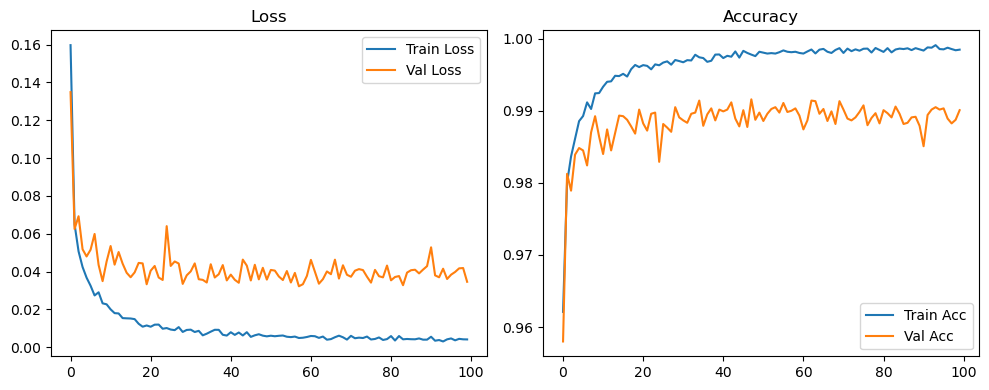

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2715, Acc: 0.9299 | Val Loss: 0.7253, Acc: 0.7270


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1313, Acc: 0.9617 | Val Loss: 0.3600, Acc: 0.8742


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1072, Acc: 0.9688 | Val Loss: 0.4000, Acc: 0.8540


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.2479, Acc: 0.9188


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0882, Acc: 0.9737 | Val Loss: 0.1590, Acc: 0.9528


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0845, Acc: 0.9750 | Val Loss: 0.1938, Acc: 0.9384


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0784, Acc: 0.9763 | Val Loss: 0.1126, Acc: 0.9711


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0778, Acc: 0.9765 | Val Loss: 0.1601, Acc: 0.9529


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0716, Acc: 0.9785 | Val Loss: 0.1279, Acc: 0.9643


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9785 | Val Loss: 0.1269, Acc: 0.9633


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9800 | Val Loss: 0.1143, Acc: 0.9693


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9812 | Val Loss: 0.1142, Acc: 0.9699


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9809 | Val Loss: 0.1458, Acc: 0.9549


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9815 | Val Loss: 0.1057, Acc: 0.9706


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0596, Acc: 0.9821 | Val Loss: 0.1096, Acc: 0.9710


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9824 | Val Loss: 0.1238, Acc: 0.9696


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9830 | Val Loss: 0.1354, Acc: 0.9615


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9836 | Val Loss: 0.1350, Acc: 0.9621


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0533, Acc: 0.9834 | Val Loss: 0.1289, Acc: 0.9645


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9846 | Val Loss: 0.1353, Acc: 0.9611


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.1156, Acc: 0.9718


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9849 | Val Loss: 0.1043, Acc: 0.9766


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9852 | Val Loss: 0.0940, Acc: 0.9790


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9845 | Val Loss: 0.1109, Acc: 0.9786


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.1385, Acc: 0.9681


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9854 | Val Loss: 0.1162, Acc: 0.9735


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9866 | Val Loss: 0.1212, Acc: 0.9738


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9859 | Val Loss: 0.1233, Acc: 0.9738


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9862 | Val Loss: 0.1184, Acc: 0.9786


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9861 | Val Loss: 0.1433, Acc: 0.9719


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 0.1714, Acc: 0.9593


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9871 | Val Loss: 0.1493, Acc: 0.9697


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9864 | Val Loss: 0.1272, Acc: 0.9752


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.1607, Acc: 0.9677


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.1739, Acc: 0.9700


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.1610, Acc: 0.9722


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9870 | Val Loss: 0.1465, Acc: 0.9748


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9870 | Val Loss: 0.1542, Acc: 0.9753


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9884 | Val Loss: 0.1797, Acc: 0.9762


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9872 | Val Loss: 0.1692, Acc: 0.9730


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9871 | Val Loss: 0.1826, Acc: 0.9705


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.1681, Acc: 0.9742


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9876 | Val Loss: 0.2057, Acc: 0.9740


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9885 | Val Loss: 0.1668, Acc: 0.9760


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.1747, Acc: 0.9677


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9897 | Val Loss: 0.1657, Acc: 0.9772


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 0.2188, Acc: 0.9633


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.2300, Acc: 0.9762


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.1922, Acc: 0.9707


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.1993, Acc: 0.9721


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9886 | Val Loss: 0.2314, Acc: 0.9677


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.1956, Acc: 0.9752


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9893 | Val Loss: 0.2055, Acc: 0.9646


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.2327, Acc: 0.9768


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9893 | Val Loss: 0.2429, Acc: 0.9647


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9892 | Val Loss: 0.2581, Acc: 0.9702


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.2539, Acc: 0.9652


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.2746, Acc: 0.9625


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.2716, Acc: 0.9633


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9877 | Val Loss: 0.2760, Acc: 0.9674


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.3105, Acc: 0.9623


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.2485, Acc: 0.9667


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9893 | Val Loss: 0.2781, Acc: 0.9740


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.2734, Acc: 0.9729


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.3092, Acc: 0.9492


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.2993, Acc: 0.9648


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.2869, Acc: 0.9664


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.3021, Acc: 0.9701


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.3347, Acc: 0.9647


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.3209, Acc: 0.9702


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.2991, Acc: 0.9726


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9901 | Val Loss: 0.3139, Acc: 0.9649


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.3466, Acc: 0.9579


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.3946, Acc: 0.9517


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.3294, Acc: 0.9649


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.4107, Acc: 0.9542


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.3943, Acc: 0.9591


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.3527, Acc: 0.9627


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.3990, Acc: 0.9618


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.4559, Acc: 0.9522


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9896 | Val Loss: 0.4618, Acc: 0.9506


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.4172, Acc: 0.9613


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.4743, Acc: 0.9454


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.6059, Acc: 0.9425


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.5025, Acc: 0.9373


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.5112, Acc: 0.9491


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.6388, Acc: 0.9223


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9906 | Val Loss: 0.5523, Acc: 0.9297


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.4239, Acc: 0.9575


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.5295, Acc: 0.9460


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9905 | Val Loss: 0.5875, Acc: 0.9403


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.4990, Acc: 0.9460


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.5479, Acc: 0.9497


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.5922, Acc: 0.9383


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.5636, Acc: 0.9354


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.5675, Acc: 0.9411


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.4133, Acc: 0.9613


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9901 | Val Loss: 0.5315, Acc: 0.9193


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.4993, Acc: 0.9342


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.6191, Acc: 0.9294


Final Test Loss: 0.6191 Accuracy: 0.9289


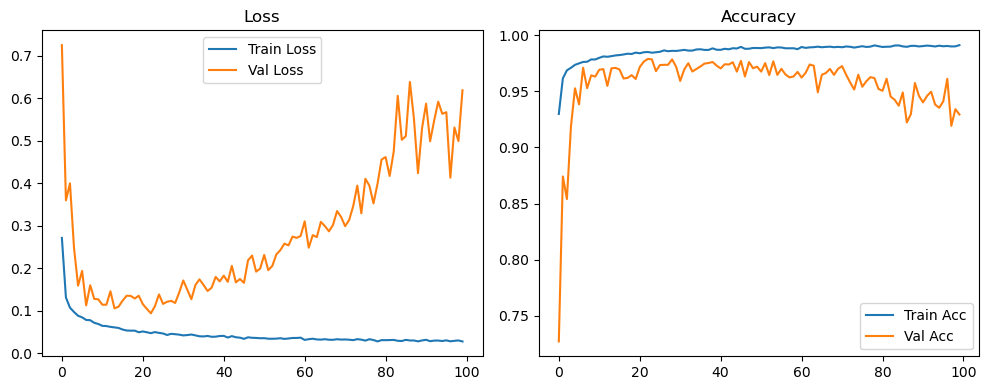

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1589, Acc: 0.9688 | Val Loss: 0.0563, Acc: 0.9848


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9861 | Val Loss: 0.0459, Acc: 0.9874


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9908 | Val Loss: 0.0412, Acc: 0.9881


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0388, Acc: 0.9884


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0411, Acc: 0.9878


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0387, Acc: 0.9872


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.0370, Acc: 0.9887


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0392, Acc: 0.9890


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0378, Acc: 0.9892


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0370, Acc: 0.9908


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0493, Acc: 0.9871


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0405, Acc: 0.9892


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0444, Acc: 0.9884


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0449, Acc: 0.9882


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0440, Acc: 0.9892


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0433, Acc: 0.9889


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0513, Acc: 0.9886


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0427, Acc: 0.9898


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0493, Acc: 0.9888


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0404, Acc: 0.9903


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0451, Acc: 0.9902


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0482, Acc: 0.9897


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0411, Acc: 0.9908


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.0459, Acc: 0.9896


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0578, Acc: 0.9865


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0410, Acc: 0.9910


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0489, Acc: 0.9902


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0510, Acc: 0.9892


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0549, Acc: 0.9874


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0396, Acc: 0.9916


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0458, Acc: 0.9895


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0559, Acc: 0.9887


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0427, Acc: 0.9914


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0440, Acc: 0.9902


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0556, Acc: 0.9883


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0462, Acc: 0.9902


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0498, Acc: 0.9891


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0451, Acc: 0.9912


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0544, Acc: 0.9893


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0520, Acc: 0.9891


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0452, Acc: 0.9912


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0511, Acc: 0.9892


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0495, Acc: 0.9898


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0528, Acc: 0.9894


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0502, Acc: 0.9897


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0468, Acc: 0.9902


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0570, Acc: 0.9887


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0509, Acc: 0.9902


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0471, Acc: 0.9897


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0545, Acc: 0.9884


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0488, Acc: 0.9902


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0500, Acc: 0.9906


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0477, Acc: 0.9915


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0480, Acc: 0.9910


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0618, Acc: 0.9884


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0558, Acc: 0.9892


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0520, Acc: 0.9902


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0437, Acc: 0.9914


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0471, Acc: 0.9908


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0508, Acc: 0.9900


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0543, Acc: 0.9895


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0549, Acc: 0.9905


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0524, Acc: 0.9904


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0564, Acc: 0.9893


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9901


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9899


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0615, Acc: 0.9888


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0688, Acc: 0.9878


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0524, Acc: 0.9902


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0498, Acc: 0.9902


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0509, Acc: 0.9902


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0520, Acc: 0.9910


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0516, Acc: 0.9908


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0516, Acc: 0.9911


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0573, Acc: 0.9902


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0546, Acc: 0.9909


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0598, Acc: 0.9894


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0496, Acc: 0.9908


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0531, Acc: 0.9907


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0497, Acc: 0.9915


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0502, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0535, Acc: 0.9901


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9909


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0592, Acc: 0.9897


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0467, Acc: 0.9922


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0502, Acc: 0.9899


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0503, Acc: 0.9904


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0612, Acc: 0.9884


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0543, Acc: 0.9903


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0561, Acc: 0.9893


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0548, Acc: 0.9905


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0541, Acc: 0.9900


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0537, Acc: 0.9908


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0578, Acc: 0.9908


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0582, Acc: 0.9901


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0521, Acc: 0.9908


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0599, Acc: 0.9897


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0501, Acc: 0.9903


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0477, Acc: 0.9914


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0502, Acc: 0.9905


Final Test Loss: 0.0507 Accuracy: 0.9895


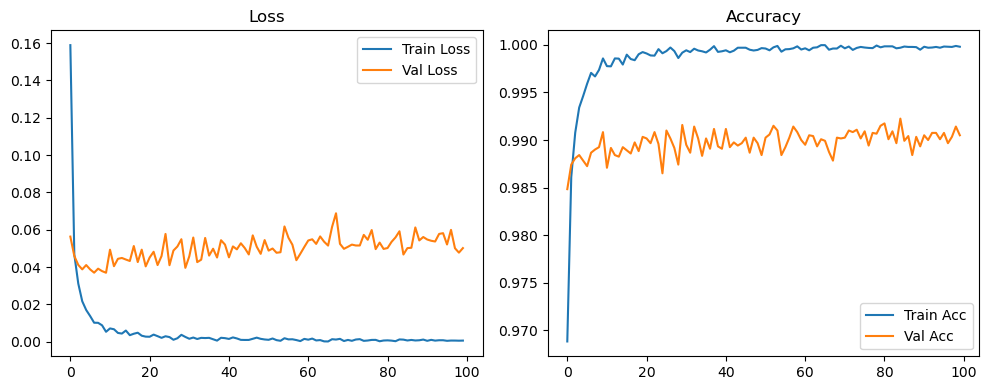

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1966, Acc: 0.9601 | Val Loss: 0.1557, Acc: 0.9544


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0669, Acc: 0.9799 | Val Loss: 0.0714, Acc: 0.9801


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9839 | Val Loss: 0.0721, Acc: 0.9782


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9859 | Val Loss: 0.0549, Acc: 0.9838


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.0565, Acc: 0.9831


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0570, Acc: 0.9827


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.0462, Acc: 0.9858


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.0438, Acc: 0.9873


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0472, Acc: 0.9858


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0429, Acc: 0.9862


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0585, Acc: 0.9838


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0392, Acc: 0.9890


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0589, Acc: 0.9829


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0438, Acc: 0.9878


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0418, Acc: 0.9890


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.0455, Acc: 0.9868


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0428, Acc: 0.9875


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0421, Acc: 0.9885


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0438, Acc: 0.9867


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0358, Acc: 0.9898


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0449, Acc: 0.9881


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0383, Acc: 0.9899


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0441, Acc: 0.9882


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0426, Acc: 0.9882


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0468, Acc: 0.9876


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0432, Acc: 0.9886


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0526, Acc: 0.9849


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.0376, Acc: 0.9908


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0414, Acc: 0.9891


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0465, Acc: 0.9871


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0473, Acc: 0.9873


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0464, Acc: 0.9866


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0396, Acc: 0.9888


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0415, Acc: 0.9897


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0466, Acc: 0.9881


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0367, Acc: 0.9912


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0464, Acc: 0.9875


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0439, Acc: 0.9896


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0432, Acc: 0.9897


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0373, Acc: 0.9899


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0439, Acc: 0.9885


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0387, Acc: 0.9902


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0458, Acc: 0.9885


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0482, Acc: 0.9874


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0485, Acc: 0.9881


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0434, Acc: 0.9898


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0550, Acc: 0.9858


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0435, Acc: 0.9891


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0479, Acc: 0.9883


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0398, Acc: 0.9902


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0405, Acc: 0.9900


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0432, Acc: 0.9902


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0463, Acc: 0.9884


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0421, Acc: 0.9888


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0449, Acc: 0.9884


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0401, Acc: 0.9898


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0461, Acc: 0.9880


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0381, Acc: 0.9908


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0450, Acc: 0.9888


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0442, Acc: 0.9888


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0422, Acc: 0.9897


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0364, Acc: 0.9916


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0397, Acc: 0.9902


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0353, Acc: 0.9918


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0360, Acc: 0.9916


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0415, Acc: 0.9888


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0380, Acc: 0.9908


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0380, Acc: 0.9901


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0376, Acc: 0.9906


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0427, Acc: 0.9893


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0394, Acc: 0.9905


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0430, Acc: 0.9894


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0401, Acc: 0.9895


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0407, Acc: 0.9887


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0387, Acc: 0.9907


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0395, Acc: 0.9898


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0385, Acc: 0.9906


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0329, Acc: 0.9904


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0315, Acc: 0.9912


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0388, Acc: 0.9893


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0362, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0348, Acc: 0.9910


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0409, Acc: 0.9898


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0385, Acc: 0.9903


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0405, Acc: 0.9896


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0355, Acc: 0.9910


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0358, Acc: 0.9899


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0401, Acc: 0.9905


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0418, Acc: 0.9897


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0398, Acc: 0.9909


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0396, Acc: 0.9897


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9895


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0398, Acc: 0.9903


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0387, Acc: 0.9907


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0400, Acc: 0.9894


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0344, Acc: 0.9916


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0371, Acc: 0.9910


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.0441, Acc: 0.9888


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0351, Acc: 0.9910


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0345, Acc: 0.9911


Final Test Loss: 0.0344 Accuracy: 0.9903


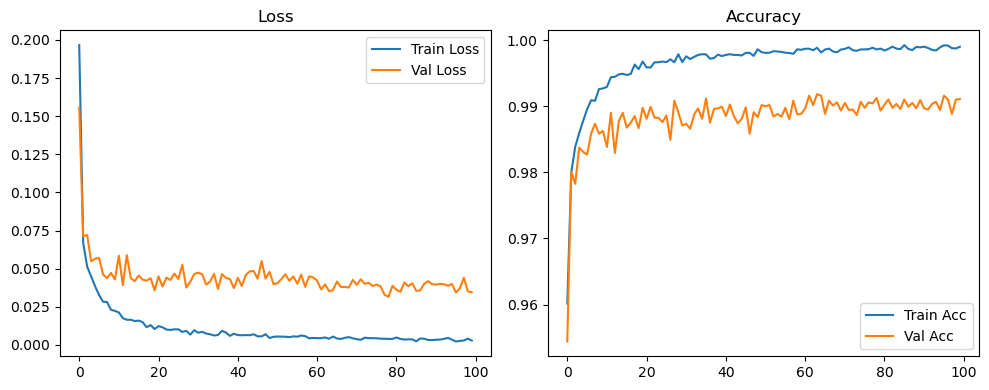

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3271, Acc: 0.9258 | Val Loss: 1.4294, Acc: 0.4704


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1377, Acc: 0.9604 | Val Loss: 0.7981, Acc: 0.6993


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1160, Acc: 0.9664 | Val Loss: 0.7741, Acc: 0.7195


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1003, Acc: 0.9715 | Val Loss: 0.3593, Acc: 0.8702


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0937, Acc: 0.9728 | Val Loss: 0.3757, Acc: 0.8583


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0880, Acc: 0.9738 | Val Loss: 0.3096, Acc: 0.8908


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0808, Acc: 0.9761 | Val Loss: 0.1881, Acc: 0.9387


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0819, Acc: 0.9756 | Val Loss: 0.2583, Acc: 0.9134


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9783 | Val Loss: 0.1736, Acc: 0.9492


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0711, Acc: 0.9781 | Val Loss: 0.1892, Acc: 0.9407


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0676, Acc: 0.9796 | Val Loss: 0.1563, Acc: 0.9527


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0666, Acc: 0.9801 | Val Loss: 0.1066, Acc: 0.9734


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9804 | Val Loss: 0.1963, Acc: 0.9373


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0644, Acc: 0.9810 | Val Loss: 0.1547, Acc: 0.9527


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9823 | Val Loss: 0.1197, Acc: 0.9657


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9814 | Val Loss: 0.1437, Acc: 0.9560


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0588, Acc: 0.9821 | Val Loss: 0.1255, Acc: 0.9629


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0541, Acc: 0.9831 | Val Loss: 0.1764, Acc: 0.9423


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9824 | Val Loss: 0.1086, Acc: 0.9699


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.1784, Acc: 0.9430


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9844 | Val Loss: 0.1480, Acc: 0.9557


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9844 | Val Loss: 0.0950, Acc: 0.9734


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9849 | Val Loss: 0.1005, Acc: 0.9723


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0521, Acc: 0.9831 | Val Loss: 0.1203, Acc: 0.9662


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9844 | Val Loss: 0.1186, Acc: 0.9676


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.1210, Acc: 0.9644


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9862 | Val Loss: 0.1091, Acc: 0.9685


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9854 | Val Loss: 0.1135, Acc: 0.9713


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9857 | Val Loss: 0.1028, Acc: 0.9763


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9861 | Val Loss: 0.1178, Acc: 0.9667


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9865 | Val Loss: 0.1106, Acc: 0.9706


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9864 | Val Loss: 0.0975, Acc: 0.9736


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0457, Acc: 0.9859 | Val Loss: 0.1486, Acc: 0.9595


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9870 | Val Loss: 0.1273, Acc: 0.9673


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.1181, Acc: 0.9679


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9881 | Val Loss: 0.1115, Acc: 0.9718


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 0.1173, Acc: 0.9717


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.1155, Acc: 0.9740


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1044, Acc: 0.9763


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.1067, Acc: 0.9734


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9873 | Val Loss: 0.1327, Acc: 0.9740


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9886 | Val Loss: 0.1274, Acc: 0.9698


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9876 | Val Loss: 0.1150, Acc: 0.9732


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.1182, Acc: 0.9768


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9880 | Val Loss: 0.1220, Acc: 0.9739


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.1055, Acc: 0.9790


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.1350, Acc: 0.9664


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.1355, Acc: 0.9709


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.1271, Acc: 0.9710


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.1332, Acc: 0.9781


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9884 | Val Loss: 0.1369, Acc: 0.9713


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.1351, Acc: 0.9765


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9881 | Val Loss: 0.1310, Acc: 0.9770


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9881 | Val Loss: 0.1439, Acc: 0.9773


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9897 | Val Loss: 0.1268, Acc: 0.9762


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.1233, Acc: 0.9785


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9879 | Val Loss: 0.1783, Acc: 0.9708


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.1652, Acc: 0.9770


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.1760, Acc: 0.9721


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.1532, Acc: 0.9709


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 0.1717, Acc: 0.9706


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.1374, Acc: 0.9737


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9899 | Val Loss: 0.1442, Acc: 0.9816


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.1625, Acc: 0.9698


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1431, Acc: 0.9788


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9904 | Val Loss: 0.1835, Acc: 0.9677


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.1855, Acc: 0.9719


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.1951, Acc: 0.9685


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1687, Acc: 0.9727


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.1589, Acc: 0.9742


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.2060, Acc: 0.9701


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.1693, Acc: 0.9746


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.1602, Acc: 0.9711


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.1643, Acc: 0.9746


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.1544, Acc: 0.9798


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.2100, Acc: 0.9673


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.1998, Acc: 0.9705


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.2111, Acc: 0.9712


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.1947, Acc: 0.9774


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.2178, Acc: 0.9697


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.2299, Acc: 0.9730


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9910 | Val Loss: 0.2366, Acc: 0.9668


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.1822, Acc: 0.9739


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9903 | Val Loss: 0.2187, Acc: 0.9712


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.2268, Acc: 0.9732


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.2535, Acc: 0.9704


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9910 | Val Loss: 0.2398, Acc: 0.9687


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.2985, Acc: 0.9384


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.2930, Acc: 0.9645


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.2603, Acc: 0.9666


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.3017, Acc: 0.9612


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.2964, Acc: 0.9589


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.3044, Acc: 0.9637


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.2350, Acc: 0.9697


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.2380, Acc: 0.9658


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.3152, Acc: 0.9553


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.2663, Acc: 0.9680


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.3470, Acc: 0.9460


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.3521, Acc: 0.9627


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9913 | Val Loss: 0.3570, Acc: 0.9528


Final Test Loss: 0.3539 Accuracy: 0.9549


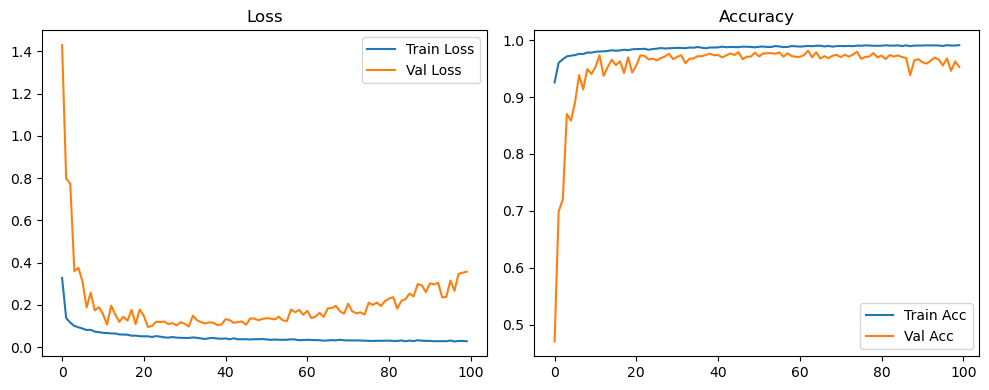

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9654 | Val Loss: 0.0644, Acc: 0.9805


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9854 | Val Loss: 0.0418, Acc: 0.9872


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.0598, Acc: 0.9830


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.0479, Acc: 0.9848


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0387, Acc: 0.9887


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0404, Acc: 0.9878


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0437, Acc: 0.9888


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0583, Acc: 0.9842


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0461, Acc: 0.9869


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0431, Acc: 0.9893


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0501, Acc: 0.9881


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0483, Acc: 0.9891


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0456, Acc: 0.9888


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0597, Acc: 0.9864


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0473, Acc: 0.9897


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0820, Acc: 0.9844


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0593, Acc: 0.9871


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0577, Acc: 0.9876


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0620, Acc: 0.9872


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0507, Acc: 0.9896


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0494, Acc: 0.9900


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0525, Acc: 0.9897


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0702, Acc: 0.9868


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0506, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0528, Acc: 0.9902


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0670, Acc: 0.9872


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0538, Acc: 0.9907


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0555, Acc: 0.9895


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0586, Acc: 0.9886


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0639, Acc: 0.9894


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0551, Acc: 0.9898


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0546, Acc: 0.9912


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0600, Acc: 0.9888


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0615, Acc: 0.9878


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0626, Acc: 0.9894


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0628, Acc: 0.9902


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0548, Acc: 0.9908


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0819, Acc: 0.9868


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0731, Acc: 0.9883


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0635, Acc: 0.9897


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0686, Acc: 0.9884


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0669, Acc: 0.9891


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0686, Acc: 0.9900


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0716, Acc: 0.9894


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0600, Acc: 0.9911


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0732, Acc: 0.9901


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0854, Acc: 0.9877


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0871, Acc: 0.9866


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0784, Acc: 0.9883


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0659, Acc: 0.9885


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0652, Acc: 0.9898


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0669, Acc: 0.9905


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0657, Acc: 0.9899


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0964, Acc: 0.9858


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0826, Acc: 0.9889


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0772, Acc: 0.9902


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0884, Acc: 0.9886


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.0779, Acc: 0.9895


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0749, Acc: 0.9904


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0737, Acc: 0.9906


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0896, Acc: 0.9891


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0831, Acc: 0.9889


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0766, Acc: 0.9900


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0874, Acc: 0.9882


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0806, Acc: 0.9897


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0821, Acc: 0.9895


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0890, Acc: 0.9893


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0736, Acc: 0.9908


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0752, Acc: 0.9908


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0691, Acc: 0.9909


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0752, Acc: 0.9900


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0939, Acc: 0.9872


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0832, Acc: 0.9899


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0818, Acc: 0.9899


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0856, Acc: 0.9909


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0961, Acc: 0.9890


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0814, Acc: 0.9912


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0922, Acc: 0.9905


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1090, Acc: 0.9875


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0985, Acc: 0.9877


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0959, Acc: 0.9887


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0831, Acc: 0.9905


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0798, Acc: 0.9905


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0878, Acc: 0.9892


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0900, Acc: 0.9894


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0806, Acc: 0.9898


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0907, Acc: 0.9891


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0886, Acc: 0.9893


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0883, Acc: 0.9897


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0948, Acc: 0.9890


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1068, Acc: 0.9890


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1025, Acc: 0.9896


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0984, Acc: 0.9883


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1037, Acc: 0.9888


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0855, Acc: 0.9907


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0835, Acc: 0.9907


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0862, Acc: 0.9902


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0798, Acc: 0.9916


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0806, Acc: 0.9912


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0842, Acc: 0.9916


Final Test Loss: 0.0759 Accuracy: 0.9915


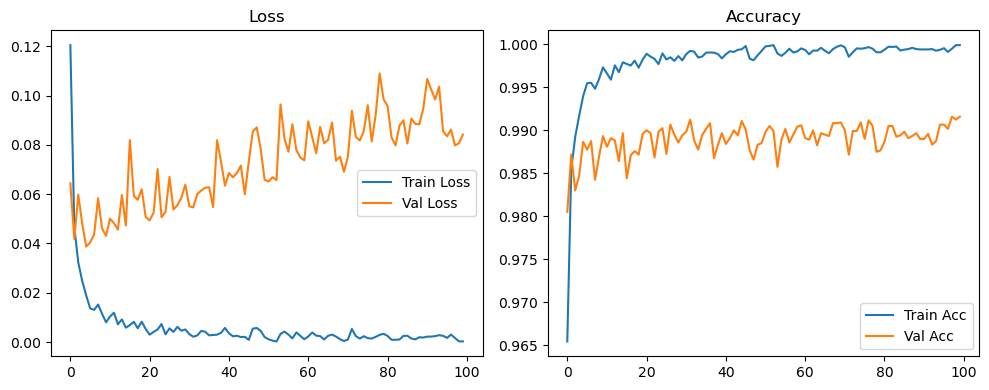

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9569 | Val Loss: 0.1095, Acc: 0.9642


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9791 | Val Loss: 0.0599, Acc: 0.9823


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 0.0681, Acc: 0.9788


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9864 | Val Loss: 0.0540, Acc: 0.9841


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0675, Acc: 0.9781


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9885 | Val Loss: 0.0569, Acc: 0.9826


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.0541, Acc: 0.9843


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0530, Acc: 0.9842


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0403, Acc: 0.9882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0476, Acc: 0.9868


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0591, Acc: 0.9830


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0515, Acc: 0.9845


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0558, Acc: 0.9842


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0428, Acc: 0.9888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0414, Acc: 0.9877


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0482, Acc: 0.9852


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0542, Acc: 0.9860


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0371, Acc: 0.9894


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9941 | Val Loss: 0.0550, Acc: 0.9846


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0442, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0557, Acc: 0.9852


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0434, Acc: 0.9881


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0465, Acc: 0.9878


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0484, Acc: 0.9872


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0468, Acc: 0.9887


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0573, Acc: 0.9853


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0451, Acc: 0.9890


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0416, Acc: 0.9895


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0531, Acc: 0.9869


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0481, Acc: 0.9875


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0434, Acc: 0.9890


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9963 | Val Loss: 0.0506, Acc: 0.9869


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0407, Acc: 0.9886


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.0462, Acc: 0.9882


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0471, Acc: 0.9882


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0567, Acc: 0.9841


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0474, Acc: 0.9875


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0516, Acc: 0.9868


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0395, Acc: 0.9906


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0515, Acc: 0.9862


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.0378, Acc: 0.9899


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0456, Acc: 0.9894


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0546, Acc: 0.9858


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0492, Acc: 0.9884


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0410, Acc: 0.9900


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0496, Acc: 0.9886


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0659, Acc: 0.9842


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0464, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0493, Acc: 0.9874


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0479, Acc: 0.9878


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9974 | Val Loss: 0.0409, Acc: 0.9892


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0613, Acc: 0.9842


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0459, Acc: 0.9887


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0420, Acc: 0.9901


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0490, Acc: 0.9876


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0462, Acc: 0.9888


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0489, Acc: 0.9883


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0472, Acc: 0.9878


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0454, Acc: 0.9883


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0409, Acc: 0.9902


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0486, Acc: 0.9888


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0439, Acc: 0.9883


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0502, Acc: 0.9871


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0492, Acc: 0.9877


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0507, Acc: 0.9866


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0438, Acc: 0.9894


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0485, Acc: 0.9872


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0476, Acc: 0.9882


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0531, Acc: 0.9888


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0509, Acc: 0.9885


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0462, Acc: 0.9898


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0382, Acc: 0.9912


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0440, Acc: 0.9899


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0465, Acc: 0.9887


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0545, Acc: 0.9877


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0515, Acc: 0.9886


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0462, Acc: 0.9896


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0495, Acc: 0.9883


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0413, Acc: 0.9897


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0540, Acc: 0.9868


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0437, Acc: 0.9898


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0471, Acc: 0.9882


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0554, Acc: 0.9875


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0485, Acc: 0.9880


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0442, Acc: 0.9886


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0442, Acc: 0.9882


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0401, Acc: 0.9911


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0463, Acc: 0.9887


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.0520, Acc: 0.9875


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0433, Acc: 0.9904


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0529, Acc: 0.9870


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0486, Acc: 0.9875


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0475, Acc: 0.9878


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0515, Acc: 0.9868


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0550, Acc: 0.9866


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0448, Acc: 0.9878


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0462, Acc: 0.9889


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0483, Acc: 0.9882


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0481, Acc: 0.9869


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0428, Acc: 0.9889


Final Test Loss: 0.0478 Accuracy: 0.9884


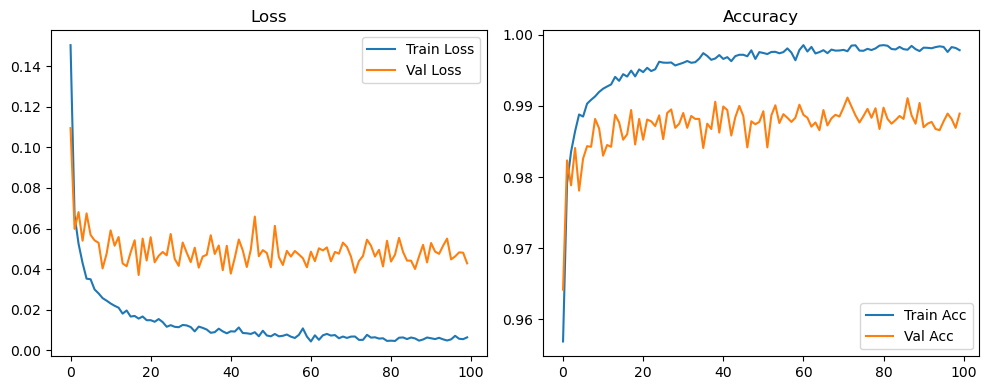

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2514, Acc: 0.9272 | Val Loss: 0.5767, Acc: 0.7949


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1333, Acc: 0.9600 | Val Loss: 0.2292, Acc: 0.9318


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1086, Acc: 0.9679 | Val Loss: 0.2757, Acc: 0.9103


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9718 | Val Loss: 0.2162, Acc: 0.9352


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9730 | Val Loss: 0.1645, Acc: 0.9503


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9747 | Val Loss: 0.1478, Acc: 0.9582


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9759 | Val Loss: 0.1305, Acc: 0.9648


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9769 | Val Loss: 0.1912, Acc: 0.9423


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9774 | Val Loss: 0.1276, Acc: 0.9656


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9781 | Val Loss: 0.2065, Acc: 0.9308


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9792 | Val Loss: 0.1767, Acc: 0.9447


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9793 | Val Loss: 0.1498, Acc: 0.9579


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9800 | Val Loss: 0.1088, Acc: 0.9698


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9802 | Val Loss: 0.1116, Acc: 0.9714


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9808 | Val Loss: 0.1091, Acc: 0.9710


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9808 | Val Loss: 0.1167, Acc: 0.9691


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9823 | Val Loss: 0.1083, Acc: 0.9698


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9818 | Val Loss: 0.1199, Acc: 0.9646


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9816 | Val Loss: 0.0811, Acc: 0.9783


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9830 | Val Loss: 0.1471, Acc: 0.9541


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9831 | Val Loss: 0.1044, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.0664, Acc: 0.9828


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9841 | Val Loss: 0.0772, Acc: 0.9810


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9844 | Val Loss: 0.1137, Acc: 0.9680


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9840 | Val Loss: 0.0957, Acc: 0.9751


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9845 | Val Loss: 0.0768, Acc: 0.9828


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9856 | Val Loss: 0.0871, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9852 | Val Loss: 0.0810, Acc: 0.9794


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9850 | Val Loss: 0.0872, Acc: 0.9758


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9841 | Val Loss: 0.0994, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.0887, Acc: 0.9795


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9867 | Val Loss: 0.1058, Acc: 0.9687


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.0938, Acc: 0.9753


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.0901, Acc: 0.9791


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.0826, Acc: 0.9782


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9863 | Val Loss: 0.0736, Acc: 0.9807


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9863 | Val Loss: 0.0802, Acc: 0.9824


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9850 | Val Loss: 0.0873, Acc: 0.9796


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.0950, Acc: 0.9792


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9858 | Val Loss: 0.0798, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9866 | Val Loss: 0.0875, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9865 | Val Loss: 0.0778, Acc: 0.9823


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9865 | Val Loss: 0.0974, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.0971, Acc: 0.9763


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.0908, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 0.0729, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.1011, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9873 | Val Loss: 0.0803, Acc: 0.9809


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0894, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9876 | Val Loss: 0.0801, Acc: 0.9831


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.0762, Acc: 0.9831


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.0955, Acc: 0.9786


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.0797, Acc: 0.9823


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 0.0711, Acc: 0.9860


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9887 | Val Loss: 0.0713, Acc: 0.9838


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9884 | Val Loss: 0.0716, Acc: 0.9846


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9884 | Val Loss: 0.0715, Acc: 0.9821


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0876, Acc: 0.9822


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9878 | Val Loss: 0.0873, Acc: 0.9802


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 0.0602, Acc: 0.9846


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.0908, Acc: 0.9790


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.0931, Acc: 0.9806


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.0780, Acc: 0.9839


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.0815, Acc: 0.9846


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9887 | Val Loss: 0.0780, Acc: 0.9821


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0785, Acc: 0.9845


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.0998, Acc: 0.9841


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0685, Acc: 0.9832


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.0983, Acc: 0.9758


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9896 | Val Loss: 0.0725, Acc: 0.9834


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9895 | Val Loss: 0.0711, Acc: 0.9864


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9895 | Val Loss: 0.1083, Acc: 0.9773


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.1052, Acc: 0.9766


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9891 | Val Loss: 0.1088, Acc: 0.9802


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0783, Acc: 0.9851


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.0903, Acc: 0.9846


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9895 | Val Loss: 0.1125, Acc: 0.9807


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.1128, Acc: 0.9766


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.0804, Acc: 0.9834


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9892 | Val Loss: 0.0857, Acc: 0.9819


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.1085, Acc: 0.9792


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9893 | Val Loss: 0.0924, Acc: 0.9799


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.1119, Acc: 0.9801


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.0726, Acc: 0.9857


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0872, Acc: 0.9856


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0920, Acc: 0.9861


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1047, Acc: 0.9828


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.0853, Acc: 0.9844


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.1107, Acc: 0.9822


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.0779, Acc: 0.9868


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9897 | Val Loss: 0.1126, Acc: 0.9845


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.1148, Acc: 0.9825


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.1061, Acc: 0.9822


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.0912, Acc: 0.9848


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.0830, Acc: 0.9862


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.0977, Acc: 0.9782


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9905 | Val Loss: 0.1057, Acc: 0.9789


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.1218, Acc: 0.9788


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.0781, Acc: 0.9860


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0804, Acc: 0.9862


Final Test Loss: 0.0728 Accuracy: 0.9863


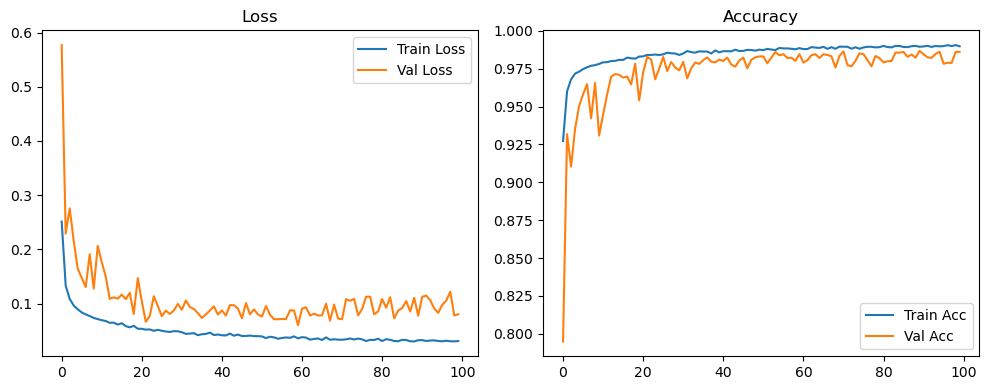

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1208, Acc: 0.9653 | Val Loss: 0.0664, Acc: 0.9788


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.0530, Acc: 0.9847


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.0531, Acc: 0.9842


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.0436, Acc: 0.9864


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0455, Acc: 0.9872


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0449, Acc: 0.9865


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0392, Acc: 0.9883


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0735, Acc: 0.9817


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9956 | Val Loss: 0.0453, Acc: 0.9877


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0511, Acc: 0.9865


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.0477, Acc: 0.9884


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0456, Acc: 0.9884


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0561, Acc: 0.9866


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0670, Acc: 0.9859


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0444, Acc: 0.9898


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0516, Acc: 0.9885


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0471, Acc: 0.9896


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0743, Acc: 0.9842


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.0546, Acc: 0.9890


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0607, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0582, Acc: 0.9882


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.0569, Acc: 0.9876


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0615, Acc: 0.9880


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0571, Acc: 0.9888


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.0515, Acc: 0.9893


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0544, Acc: 0.9895


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0494, Acc: 0.9898


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0509, Acc: 0.9898


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0533, Acc: 0.9892


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0487, Acc: 0.9909


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0519, Acc: 0.9900


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0572, Acc: 0.9893


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0506, Acc: 0.9900


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0547, Acc: 0.9901


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0601, Acc: 0.9879


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0539, Acc: 0.9903


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0540, Acc: 0.9899


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0491, Acc: 0.9914


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0616, Acc: 0.9908


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0529, Acc: 0.9898


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0670, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0591, Acc: 0.9904


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0619, Acc: 0.9900


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0609, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0619, Acc: 0.9903


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0642, Acc: 0.9893


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0801, Acc: 0.9877


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0743, Acc: 0.9877


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0634, Acc: 0.9902


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0535, Acc: 0.9908


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0505, Acc: 0.9915


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0469, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9918


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9918


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0466, Acc: 0.9918


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9922


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9921


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9919


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0727, Acc: 0.9896


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0566, Acc: 0.9909


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0570, Acc: 0.9908


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0648, Acc: 0.9901


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0627, Acc: 0.9902


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0669, Acc: 0.9905


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0640, Acc: 0.9911


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9919


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9910


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0736, Acc: 0.9902


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0671, Acc: 0.9911


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0687, Acc: 0.9903


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0666, Acc: 0.9908


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0653, Acc: 0.9908


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0621, Acc: 0.9914


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0636, Acc: 0.9908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0575, Acc: 0.9923


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0647, Acc: 0.9900


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0622, Acc: 0.9911


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9919


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0696, Acc: 0.9906


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0691, Acc: 0.9907


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0672, Acc: 0.9912


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9916


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9912


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0667, Acc: 0.9911


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9918


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9917


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9918


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9919


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9920


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0648, Acc: 0.9913


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0633, Acc: 0.9908


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9913


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9918


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9915


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0653, Acc: 0.9919


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9924


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9916


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9913


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9908


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9917


Final Test Loss: 0.0604 Accuracy: 0.9920


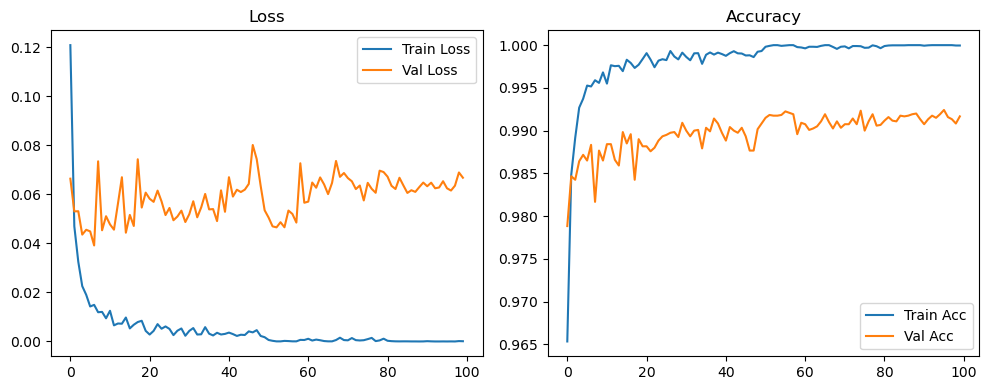

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1511, Acc: 0.9564 | Val Loss: 0.1714, Acc: 0.9442


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9788 | Val Loss: 0.0572, Acc: 0.9827


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9839 | Val Loss: 0.0592, Acc: 0.9817


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9864 | Val Loss: 0.0568, Acc: 0.9823


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9887 | Val Loss: 0.0704, Acc: 0.9778


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9893 | Val Loss: 0.0519, Acc: 0.9842


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0508, Acc: 0.9845


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9904 | Val Loss: 0.0552, Acc: 0.9831


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9907 | Val Loss: 0.0468, Acc: 0.9846


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0423, Acc: 0.9880


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9924 | Val Loss: 0.0664, Acc: 0.9815


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0566, Acc: 0.9839


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0573, Acc: 0.9832


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.0523, Acc: 0.9855


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0551, Acc: 0.9851


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0449, Acc: 0.9879


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9943 | Val Loss: 0.0619, Acc: 0.9837


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0483, Acc: 0.9872


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9940 | Val Loss: 0.0388, Acc: 0.9900


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0465, Acc: 0.9854


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0552, Acc: 0.9843


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9949 | Val Loss: 0.0496, Acc: 0.9862


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0554, Acc: 0.9857


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0445, Acc: 0.9875


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0516, Acc: 0.9852


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0499, Acc: 0.9861


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0526, Acc: 0.9868


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0571, Acc: 0.9857


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0404, Acc: 0.9890


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0424, Acc: 0.9893


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0431, Acc: 0.9889


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0447, Acc: 0.9881


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0458, Acc: 0.9878


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0544, Acc: 0.9865


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0447, Acc: 0.9887


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0435, Acc: 0.9874


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0505, Acc: 0.9873


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0464, Acc: 0.9880


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0414, Acc: 0.9889


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0535, Acc: 0.9866


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0539, Acc: 0.9858


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0391, Acc: 0.9899


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0448, Acc: 0.9882


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0624, Acc: 0.9856


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0438, Acc: 0.9894


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0399, Acc: 0.9892


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0511, Acc: 0.9872


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0482, Acc: 0.9890


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0397, Acc: 0.9897


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0618, Acc: 0.9857


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0436, Acc: 0.9898


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0476, Acc: 0.9883


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0392, Acc: 0.9899


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0414, Acc: 0.9902


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0417, Acc: 0.9893


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0401, Acc: 0.9902


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0436, Acc: 0.9905


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0490, Acc: 0.9886


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0425, Acc: 0.9908


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0531, Acc: 0.9885


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.0413, Acc: 0.9908


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0397, Acc: 0.9907


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0413, Acc: 0.9916


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0364, Acc: 0.9909


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0406, Acc: 0.9906


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0395, Acc: 0.9908


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0404, Acc: 0.9902


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0439, Acc: 0.9907


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0423, Acc: 0.9907


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0452, Acc: 0.9901


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0461, Acc: 0.9904


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0450, Acc: 0.9906


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0551, Acc: 0.9887


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0622, Acc: 0.9874


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0461, Acc: 0.9895


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0464, Acc: 0.9888


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0400, Acc: 0.9893


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0460, Acc: 0.9881


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0411, Acc: 0.9889


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0414, Acc: 0.9893


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0374, Acc: 0.9911


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0386, Acc: 0.9905


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0365, Acc: 0.9912


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0393, Acc: 0.9901


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0428, Acc: 0.9895


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0386, Acc: 0.9913


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0370, Acc: 0.9904


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0395, Acc: 0.9904


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0453, Acc: 0.9892


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0397, Acc: 0.9914


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0421, Acc: 0.9907


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0428, Acc: 0.9907


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0470, Acc: 0.9896


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0434, Acc: 0.9907


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0439, Acc: 0.9910


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0427, Acc: 0.9905


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0414, Acc: 0.9908


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0433, Acc: 0.9904


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.0413, Acc: 0.9908


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0387, Acc: 0.9915


Final Test Loss: 0.0402 Accuracy: 0.9902


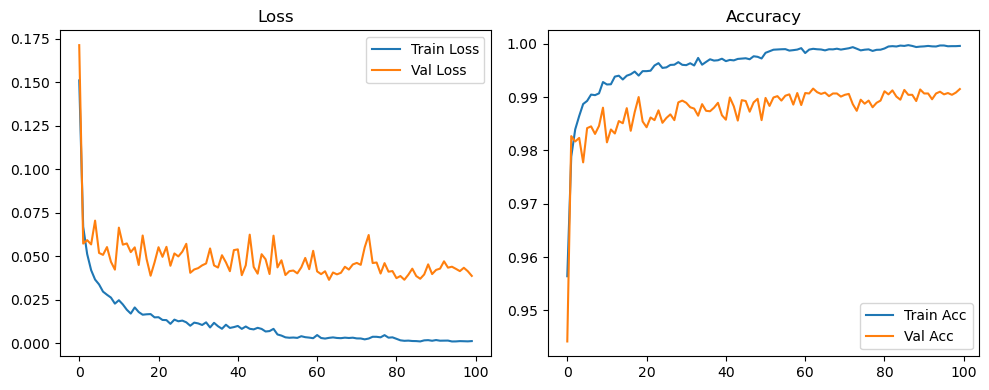

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2502, Acc: 0.9269 | Val Loss: 0.7550, Acc: 0.7055


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1322, Acc: 0.9609 | Val Loss: 0.2901, Acc: 0.9055


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9672 | Val Loss: 0.2214, Acc: 0.9343


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9712 | Val Loss: 0.2060, Acc: 0.9347


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9735 | Val Loss: 0.2169, Acc: 0.9330


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9744 | Val Loss: 0.1357, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9752 | Val Loss: 0.1760, Acc: 0.9456


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9769 | Val Loss: 0.1560, Acc: 0.9527


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9779 | Val Loss: 0.0962, Acc: 0.9775


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9789 | Val Loss: 0.2074, Acc: 0.9355


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9797 | Val Loss: 0.1363, Acc: 0.9587


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9794 | Val Loss: 0.1109, Acc: 0.9707


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9803 | Val Loss: 0.1001, Acc: 0.9721


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9804 | Val Loss: 0.1242, Acc: 0.9631


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9804 | Val Loss: 0.0895, Acc: 0.9726


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9815 | Val Loss: 0.0967, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9807 | Val Loss: 0.1032, Acc: 0.9702


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9827 | Val Loss: 0.1252, Acc: 0.9629


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9814 | Val Loss: 0.0961, Acc: 0.9732


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9832 | Val Loss: 0.1139, Acc: 0.9654


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9830 | Val Loss: 0.1153, Acc: 0.9673


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9826 | Val Loss: 0.0789, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.0756, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9845 | Val Loss: 0.0760, Acc: 0.9792


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9846 | Val Loss: 0.0739, Acc: 0.9807


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9840 | Val Loss: 0.0726, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9840 | Val Loss: 0.0977, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9849 | Val Loss: 0.0965, Acc: 0.9725


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9852 | Val Loss: 0.1187, Acc: 0.9654


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9848 | Val Loss: 0.0709, Acc: 0.9815


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9857 | Val Loss: 0.0728, Acc: 0.9794


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9856 | Val Loss: 0.0988, Acc: 0.9712


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.0831, Acc: 0.9775


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 0.0741, Acc: 0.9793


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9869 | Val Loss: 0.0891, Acc: 0.9748


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.0825, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9866 | Val Loss: 0.0736, Acc: 0.9812


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.0836, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.0896, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9865 | Val Loss: 0.0789, Acc: 0.9843


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9863 | Val Loss: 0.0734, Acc: 0.9827


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.0717, Acc: 0.9820


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9866 | Val Loss: 0.0848, Acc: 0.9775


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9873 | Val Loss: 0.0639, Acc: 0.9843


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9865 | Val Loss: 0.0704, Acc: 0.9832


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0798, Acc: 0.9812


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.0999, Acc: 0.9722


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9888 | Val Loss: 0.0735, Acc: 0.9810


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.0791, Acc: 0.9815


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 0.0985, Acc: 0.9732


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.0755, Acc: 0.9819


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9896 | Val Loss: 0.0766, Acc: 0.9821


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.0737, Acc: 0.9826


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0703, Acc: 0.9820


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.0850, Acc: 0.9745


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9898 | Val Loss: 0.0733, Acc: 0.9819


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.0653, Acc: 0.9846


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.0699, Acc: 0.9834


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9905 | Val Loss: 0.0713, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.0794, Acc: 0.9789


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.0708, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.0757, Acc: 0.9809


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9910 | Val Loss: 0.0834, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9915 | Val Loss: 0.0688, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0644, Acc: 0.9824


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.0724, Acc: 0.9808


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9904 | Val Loss: 0.0685, Acc: 0.9862


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0804, Acc: 0.9826


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9902 | Val Loss: 0.0655, Acc: 0.9865


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.0629, Acc: 0.9858


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.0674, Acc: 0.9852


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0692, Acc: 0.9828


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.0703, Acc: 0.9823


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.0808, Acc: 0.9845


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.0781, Acc: 0.9849


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0767, Acc: 0.9826


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0837, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0815, Acc: 0.9813


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0812, Acc: 0.9831


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9920 | Val Loss: 0.0708, Acc: 0.9834


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.0662, Acc: 0.9850


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.0650, Acc: 0.9854


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.0622, Acc: 0.9862


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9926 | Val Loss: 0.0679, Acc: 0.9848


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0702, Acc: 0.9854


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9930 | Val Loss: 0.0672, Acc: 0.9860


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0664, Acc: 0.9871


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0642, Acc: 0.9872


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9927 | Val Loss: 0.0647, Acc: 0.9863


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0698, Acc: 0.9879


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0682, Acc: 0.9855


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0714, Acc: 0.9868


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0730, Acc: 0.9852


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0754, Acc: 0.9847


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0678, Acc: 0.9860


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0726, Acc: 0.9838


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0769, Acc: 0.9828


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.0778, Acc: 0.9837


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0738, Acc: 0.9869


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9931 | Val Loss: 0.0672, Acc: 0.9878


Final Test Loss: 0.0643 Accuracy: 0.9864


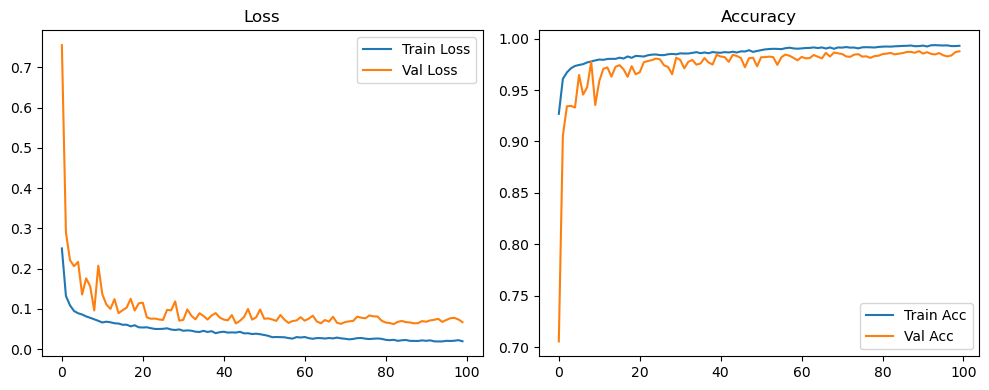

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1203, Acc: 0.9656 | Val Loss: 0.0622, Acc: 0.9815


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9849 | Val Loss: 0.0379, Acc: 0.9881


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.0416, Acc: 0.9888


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0440, Acc: 0.9863


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0410, Acc: 0.9877


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9942 | Val Loss: 0.0430, Acc: 0.9873


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9950 | Val Loss: 0.0394, Acc: 0.9902


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.0525, Acc: 0.9858


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.0439, Acc: 0.9878


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0538, Acc: 0.9866


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0470, Acc: 0.9882


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.0448, Acc: 0.9889


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0558, Acc: 0.9850


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0501, Acc: 0.9886


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0487, Acc: 0.9896


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0548, Acc: 0.9878


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.0485, Acc: 0.9883


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0480, Acc: 0.9892


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0437, Acc: 0.9904


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0471, Acc: 0.9889


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0481, Acc: 0.9903


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0497, Acc: 0.9904


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0559, Acc: 0.9888


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0618, Acc: 0.9892


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0669, Acc: 0.9866


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0651, Acc: 0.9880


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0524, Acc: 0.9891


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0524, Acc: 0.9891


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0520, Acc: 0.9893


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0538, Acc: 0.9892


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0539, Acc: 0.9897


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0538, Acc: 0.9897


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0627, Acc: 0.9885


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0504, Acc: 0.9915


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0565, Acc: 0.9907


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0607, Acc: 0.9897


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0707, Acc: 0.9877


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0672, Acc: 0.9876


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0567, Acc: 0.9894


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0552, Acc: 0.9901


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0616, Acc: 0.9902


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0670, Acc: 0.9889


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0624, Acc: 0.9894


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0633, Acc: 0.9901


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0781, Acc: 0.9880


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0732, Acc: 0.9897


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0685, Acc: 0.9892


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0794, Acc: 0.9882


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0582, Acc: 0.9912


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0718, Acc: 0.9901


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0616, Acc: 0.9912


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9922


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9912


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9918


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9916


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0671, Acc: 0.9911


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0641, Acc: 0.9916


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0585, Acc: 0.9917


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0587, Acc: 0.9915


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0609, Acc: 0.9922


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0625, Acc: 0.9922


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0620, Acc: 0.9920


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9925


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0773, Acc: 0.9904


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0644, Acc: 0.9907


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0602, Acc: 0.9910


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0631, Acc: 0.9913


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9911


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0674, Acc: 0.9916


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0589, Acc: 0.9926


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0591, Acc: 0.9927


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0763, Acc: 0.9904


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0622, Acc: 0.9922


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0638, Acc: 0.9918


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0597, Acc: 0.9918


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9921


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9926


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0686, Acc: 0.9914


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0749, Acc: 0.9910


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0832, Acc: 0.9907


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0743, Acc: 0.9914


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0695, Acc: 0.9919


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0694, Acc: 0.9920


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0703, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0669, Acc: 0.9919


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9923


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0687, Acc: 0.9922


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0688, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0709, Acc: 0.9919


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0675, Acc: 0.9924


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0648, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0677, Acc: 0.9924


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9921


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0680, Acc: 0.9922


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0664, Acc: 0.9920


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0669, Acc: 0.9924


Final Test Loss: 0.0617 Accuracy: 0.9917


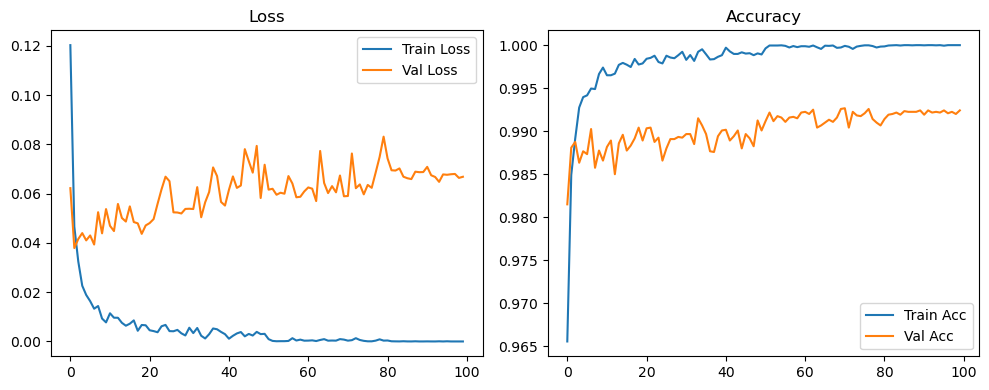

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9565 | Val Loss: 0.1057, Acc: 0.9659


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9797 | Val Loss: 0.0672, Acc: 0.9787


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0776, Acc: 0.9760


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9866 | Val Loss: 0.0465, Acc: 0.9868


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0560, Acc: 0.9811


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9889 | Val Loss: 0.0587, Acc: 0.9808


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9899 | Val Loss: 0.0632, Acc: 0.9807


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.0605, Acc: 0.9810


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0479, Acc: 0.9850


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0424, Acc: 0.9878


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.0404, Acc: 0.9870


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0462, Acc: 0.9869


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0483, Acc: 0.9852


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0576, Acc: 0.9831


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.0472, Acc: 0.9854


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0511, Acc: 0.9851


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9940 | Val Loss: 0.0477, Acc: 0.9865


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0449, Acc: 0.9880


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0460, Acc: 0.9878


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0449, Acc: 0.9876


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0484, Acc: 0.9866


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.0418, Acc: 0.9889


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0486, Acc: 0.9867


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.0405, Acc: 0.9889


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9958 | Val Loss: 0.0508, Acc: 0.9869


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0534, Acc: 0.9861


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9954 | Val Loss: 0.0622, Acc: 0.9831


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0523, Acc: 0.9859


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0444, Acc: 0.9877


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0694, Acc: 0.9831


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0461, Acc: 0.9892


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0416, Acc: 0.9883


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0525, Acc: 0.9866


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0514, Acc: 0.9872


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0536, Acc: 0.9871


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0465, Acc: 0.9878


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0538, Acc: 0.9871


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0496, Acc: 0.9882


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0436, Acc: 0.9895


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0504, Acc: 0.9886


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0475, Acc: 0.9890


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0532, Acc: 0.9866


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0517, Acc: 0.9879


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0538, Acc: 0.9877


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0555, Acc: 0.9869


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0537, Acc: 0.9870


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0592, Acc: 0.9858


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0454, Acc: 0.9900


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0437, Acc: 0.9892


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0544, Acc: 0.9878


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0453, Acc: 0.9889


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0502, Acc: 0.9884


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0420, Acc: 0.9902


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0430, Acc: 0.9892


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0470, Acc: 0.9890


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0411, Acc: 0.9907


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0484, Acc: 0.9894


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0435, Acc: 0.9913


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0456, Acc: 0.9895


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0495, Acc: 0.9886


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0487, Acc: 0.9883


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0448, Acc: 0.9899


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9896


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0429, Acc: 0.9896


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0459, Acc: 0.9890


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0457, Acc: 0.9899


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0445, Acc: 0.9898


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0472, Acc: 0.9881


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0450, Acc: 0.9901


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0478, Acc: 0.9893


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0427, Acc: 0.9912


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0452, Acc: 0.9893


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0524, Acc: 0.9878


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0468, Acc: 0.9898


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0445, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.0421, Acc: 0.9909


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0431, Acc: 0.9902


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0447, Acc: 0.9902


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0436, Acc: 0.9914


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0449, Acc: 0.9905


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0402, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0399, Acc: 0.9920


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0405, Acc: 0.9913


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0398, Acc: 0.9920


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0376, Acc: 0.9920


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0379, Acc: 0.9926


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0413, Acc: 0.9921


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0417, Acc: 0.9919


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0416, Acc: 0.9921


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0414, Acc: 0.9921


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0416, Acc: 0.9920


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0433, Acc: 0.9908


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0393, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0447, Acc: 0.9908


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0418, Acc: 0.9917


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0425, Acc: 0.9917


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0427, Acc: 0.9914


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0393, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0402, Acc: 0.9920


Final Test Loss: 0.0399 Accuracy: 0.9910


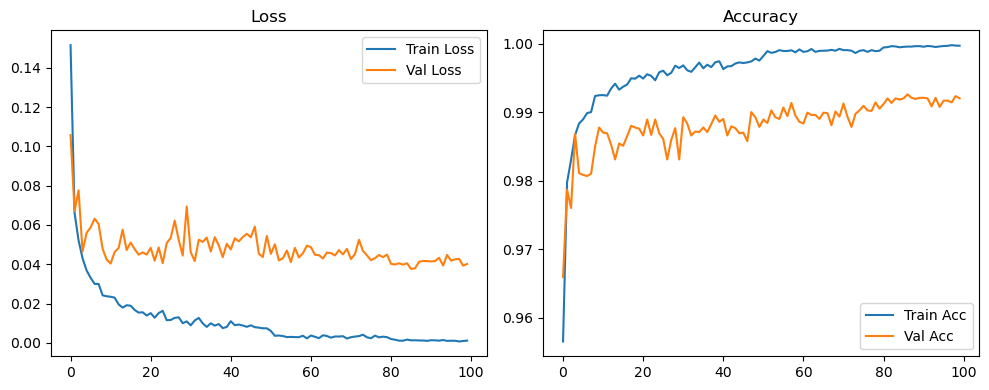

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2491, Acc: 0.9280 | Val Loss: 0.6130, Acc: 0.7615


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9605 | Val Loss: 0.4128, Acc: 0.8637


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9685 | Val Loss: 0.1647, Acc: 0.9521


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9719 | Val Loss: 0.2198, Acc: 0.9326


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9739 | Val Loss: 0.1657, Acc: 0.9499


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9736 | Val Loss: 0.2380, Acc: 0.9209


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0807, Acc: 0.9754 | Val Loss: 0.1676, Acc: 0.9483


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9764 | Val Loss: 0.1454, Acc: 0.9555


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9780 | Val Loss: 0.1125, Acc: 0.9710


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9784 | Val Loss: 0.1737, Acc: 0.9464


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9783 | Val Loss: 0.1251, Acc: 0.9634


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9796 | Val Loss: 0.0958, Acc: 0.9750


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9800 | Val Loss: 0.1165, Acc: 0.9670


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9805 | Val Loss: 0.1006, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9809 | Val Loss: 0.1151, Acc: 0.9683


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9815 | Val Loss: 0.0995, Acc: 0.9743


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9811 | Val Loss: 0.1266, Acc: 0.9637


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9826 | Val Loss: 0.1209, Acc: 0.9663


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9821 | Val Loss: 0.0951, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9826 | Val Loss: 0.1250, Acc: 0.9608


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9836 | Val Loss: 0.1163, Acc: 0.9653


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9836 | Val Loss: 0.0979, Acc: 0.9714


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9835 | Val Loss: 0.0745, Acc: 0.9811


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.0732, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.0789, Acc: 0.9778


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9833 | Val Loss: 0.0800, Acc: 0.9774


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9846 | Val Loss: 0.0799, Acc: 0.9824


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 0.0931, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9845 | Val Loss: 0.1157, Acc: 0.9657


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9839 | Val Loss: 0.1313, Acc: 0.9613


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9853 | Val Loss: 0.1053, Acc: 0.9681


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9861 | Val Loss: 0.1062, Acc: 0.9711


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9866 | Val Loss: 0.0982, Acc: 0.9747


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.0823, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.1060, Acc: 0.9692


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9851 | Val Loss: 0.0853, Acc: 0.9778


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9864 | Val Loss: 0.0950, Acc: 0.9742


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9856 | Val Loss: 0.0890, Acc: 0.9791


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 0.0949, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.1130, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9871 | Val Loss: 0.0883, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.0885, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.1415, Acc: 0.9562


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9871 | Val Loss: 0.0971, Acc: 0.9731


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9871 | Val Loss: 0.1022, Acc: 0.9728


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 0.0786, Acc: 0.9802


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.1057, Acc: 0.9707


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9871 | Val Loss: 0.1019, Acc: 0.9728


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9864 | Val Loss: 0.0903, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.0798, Acc: 0.9803


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0726, Acc: 0.9838


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9897 | Val Loss: 0.0790, Acc: 0.9848


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.0617, Acc: 0.9863


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0786, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0652, Acc: 0.9848


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0592, Acc: 0.9868


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0776, Acc: 0.9797


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.0707, Acc: 0.9832


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9909 | Val Loss: 0.0597, Acc: 0.9873


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.0741, Acc: 0.9816


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.0846, Acc: 0.9775


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9903 | Val Loss: 0.0858, Acc: 0.9780


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.0673, Acc: 0.9859


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.0759, Acc: 0.9832


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9915 | Val Loss: 0.0710, Acc: 0.9848


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.0761, Acc: 0.9805


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0696, Acc: 0.9850


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.0823, Acc: 0.9820


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9903 | Val Loss: 0.0768, Acc: 0.9837


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0867, Acc: 0.9810


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0787, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.0906, Acc: 0.9773


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0888, Acc: 0.9802


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0874, Acc: 0.9813


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0737, Acc: 0.9858


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0868, Acc: 0.9844


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.0824, Acc: 0.9815


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0816, Acc: 0.9820


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.0915, Acc: 0.9840


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0854, Acc: 0.9805


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.0823, Acc: 0.9834


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0780, Acc: 0.9846


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9928 | Val Loss: 0.0829, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0778, Acc: 0.9856


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0738, Acc: 0.9854


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0832, Acc: 0.9835


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0783, Acc: 0.9839


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0806, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0804, Acc: 0.9843


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0783, Acc: 0.9865


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0809, Acc: 0.9841


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0864, Acc: 0.9833


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0788, Acc: 0.9846


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.0748, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.0797, Acc: 0.9847


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0873, Acc: 0.9823


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0769, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.0930, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.0766, Acc: 0.9864


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0709, Acc: 0.9865


Final Test Loss: 0.0676 Accuracy: 0.9864


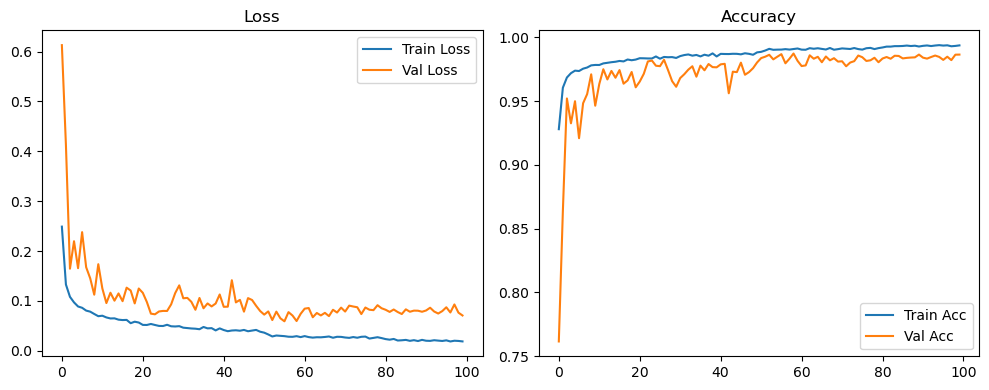

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9649 | Val Loss: 0.0590, Acc: 0.9823


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0361, Acc: 0.9893


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.0379, Acc: 0.9882


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0499, Acc: 0.9832


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0401, Acc: 0.9885


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0403, Acc: 0.9881


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0394, Acc: 0.9898


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0497, Acc: 0.9870


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0521, Acc: 0.9874


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0810, Acc: 0.9827


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0508, Acc: 0.9876


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0537, Acc: 0.9873


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0546, Acc: 0.9889


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0589, Acc: 0.9857


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0496, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0590, Acc: 0.9852


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0576, Acc: 0.9870


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0617, Acc: 0.9882


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0497, Acc: 0.9900


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0574, Acc: 0.9870


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0717, Acc: 0.9860


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0714, Acc: 0.9852


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0475, Acc: 0.9902


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0612, Acc: 0.9868


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0567, Acc: 0.9885


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0549, Acc: 0.9898


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0837, Acc: 0.9841


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0639, Acc: 0.9878


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0568, Acc: 0.9891


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.0634, Acc: 0.9881


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0590, Acc: 0.9890


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0508, Acc: 0.9905


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0494, Acc: 0.9910


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0515, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0526, Acc: 0.9892


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0510, Acc: 0.9914


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0543, Acc: 0.9899


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0697, Acc: 0.9862


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0539, Acc: 0.9896


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0680, Acc: 0.9871


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0596, Acc: 0.9899


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0596, Acc: 0.9898


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0492, Acc: 0.9910


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0596, Acc: 0.9895


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0589, Acc: 0.9913


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0772, Acc: 0.9870


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0624, Acc: 0.9899


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.0600, Acc: 0.9892


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0683, Acc: 0.9890


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0616, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0535, Acc: 0.9913


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9925


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9923


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9925


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9926


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9923


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9927


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9928


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9922


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9930


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9927


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9919


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0531, Acc: 0.9918


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0558, Acc: 0.9914


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9918


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9922


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9922


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9928


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9922


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9929


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9922


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9916


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9927


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9920


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0557, Acc: 0.9918


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9924


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0548, Acc: 0.9917


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0511, Acc: 0.9932


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9929


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9923


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9932


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9931


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9932


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9930


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9933


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9932


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9930


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9934


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9931


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9930


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9929


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9933


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9928


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9929


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9930


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9937


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9932


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9929


Final Test Loss: 0.0632 Accuracy: 0.9911


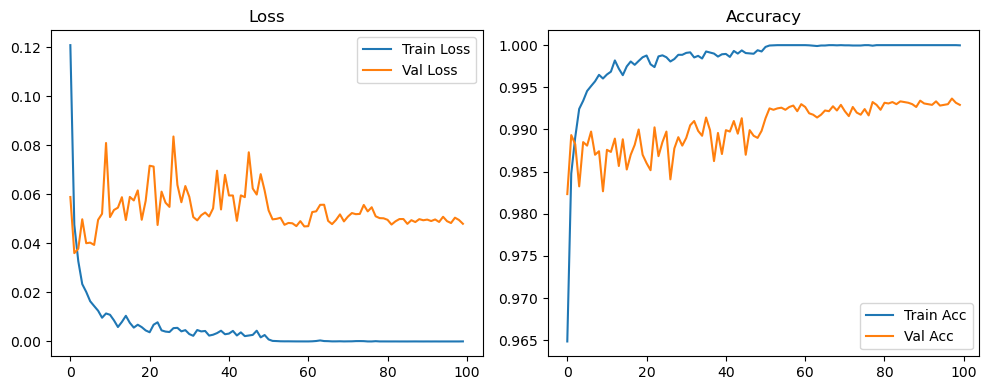

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1509, Acc: 0.9570 | Val Loss: 0.1807, Acc: 0.9413


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9788 | Val Loss: 0.0707, Acc: 0.9789


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9829 | Val Loss: 0.0677, Acc: 0.9805


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9860 | Val Loss: 0.0483, Acc: 0.9862


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9884 | Val Loss: 0.0517, Acc: 0.9838


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.0541, Acc: 0.9837


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9901 | Val Loss: 0.0562, Acc: 0.9821


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0449, Acc: 0.9852


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.0483, Acc: 0.9852


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0431, Acc: 0.9881


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0576, Acc: 0.9840


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0427, Acc: 0.9869


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0469, Acc: 0.9869


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0450, Acc: 0.9878


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0574, Acc: 0.9841


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0536, Acc: 0.9843


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.0601, Acc: 0.9827


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0523, Acc: 0.9855


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0529, Acc: 0.9846


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.0451, Acc: 0.9878


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0581, Acc: 0.9842


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0362, Acc: 0.9903


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0523, Acc: 0.9868


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0541, Acc: 0.9852


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0514, Acc: 0.9855


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0555, Acc: 0.9852


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0432, Acc: 0.9881


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0599, Acc: 0.9846


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0455, Acc: 0.9891


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0544, Acc: 0.9868


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0496, Acc: 0.9879


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0559, Acc: 0.9859


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0515, Acc: 0.9863


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0413, Acc: 0.9890


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0365, Acc: 0.9911


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0459, Acc: 0.9887


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0515, Acc: 0.9875


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0468, Acc: 0.9887


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0389, Acc: 0.9893


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0533, Acc: 0.9866


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0426, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0487, Acc: 0.9885


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0426, Acc: 0.9885


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0575, Acc: 0.9859


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.0404, Acc: 0.9895


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0435, Acc: 0.9891


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0558, Acc: 0.9862


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0433, Acc: 0.9891


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0422, Acc: 0.9892


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0467, Acc: 0.9882


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0376, Acc: 0.9909


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0410, Acc: 0.9902


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0365, Acc: 0.9916


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0367, Acc: 0.9914


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0380, Acc: 0.9912


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0375, Acc: 0.9908


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0420, Acc: 0.9906


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0393, Acc: 0.9904


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0382, Acc: 0.9910


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0374, Acc: 0.9909


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0386, Acc: 0.9913


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0386, Acc: 0.9912


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0361, Acc: 0.9921


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0395, Acc: 0.9911


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0405, Acc: 0.9908


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0390, Acc: 0.9914


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0406, Acc: 0.9915


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0391, Acc: 0.9912


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0377, Acc: 0.9914


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0360, Acc: 0.9918


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0353, Acc: 0.9914


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0403, Acc: 0.9912


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0414, Acc: 0.9908


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0404, Acc: 0.9913


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0393, Acc: 0.9913


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0429, Acc: 0.9908


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0451, Acc: 0.9902


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0386, Acc: 0.9918


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0425, Acc: 0.9906


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0449, Acc: 0.9902


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0395, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0376, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0399, Acc: 0.9909


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0387, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0407, Acc: 0.9903


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0391, Acc: 0.9922


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0373, Acc: 0.9915


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0375, Acc: 0.9914


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0406, Acc: 0.9904


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0413, Acc: 0.9911


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0389, Acc: 0.9909


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0416, Acc: 0.9909


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0422, Acc: 0.9903


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0396, Acc: 0.9910


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0454, Acc: 0.9898


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0432, Acc: 0.9906


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0404, Acc: 0.9908


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0403, Acc: 0.9914


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0400, Acc: 0.9906


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0387, Acc: 0.9918


Final Test Loss: 0.0390 Accuracy: 0.9906


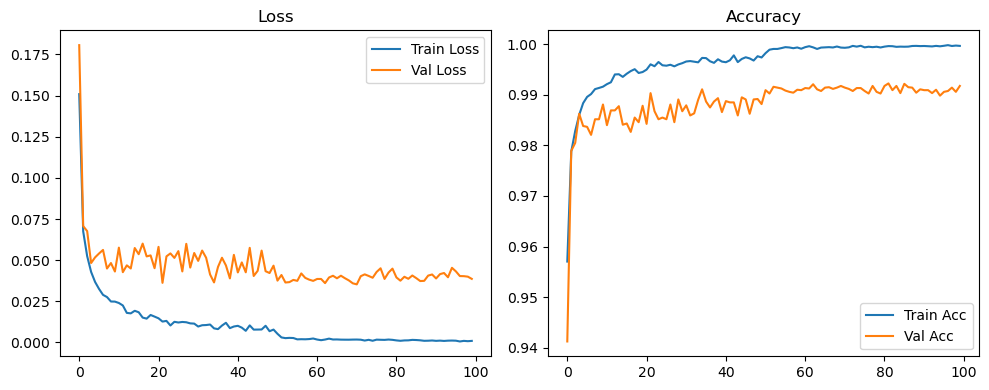

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2492, Acc: 0.9272 | Val Loss: 0.9852, Acc: 0.6168


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9608 | Val Loss: 0.2252, Acc: 0.9372


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9669 | Val Loss: 0.1623, Acc: 0.9577


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9719 | Val Loss: 0.1862, Acc: 0.9448


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9740 | Val Loss: 0.2185, Acc: 0.9284


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9743 | Val Loss: 0.1576, Acc: 0.9597


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9759 | Val Loss: 0.1643, Acc: 0.9482


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9771 | Val Loss: 0.1203, Acc: 0.9678


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9770 | Val Loss: 0.0890, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9784 | Val Loss: 0.1683, Acc: 0.9497


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9793 | Val Loss: 0.1176, Acc: 0.9662


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9791 | Val Loss: 0.1175, Acc: 0.9679


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9798 | Val Loss: 0.0916, Acc: 0.9775


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9806 | Val Loss: 0.0867, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9797 | Val Loss: 0.0982, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.0933, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9818 | Val Loss: 0.0865, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9826 | Val Loss: 0.0988, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9816 | Val Loss: 0.1063, Acc: 0.9708


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9834 | Val Loss: 0.1253, Acc: 0.9611


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9835 | Val Loss: 0.0989, Acc: 0.9747


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9834 | Val Loss: 0.1040, Acc: 0.9692


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9833 | Val Loss: 0.0931, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9840 | Val Loss: 0.0966, Acc: 0.9756


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9833 | Val Loss: 0.0903, Acc: 0.9754


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.0948, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9847 | Val Loss: 0.0751, Acc: 0.9813


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.0865, Acc: 0.9775


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9854 | Val Loss: 0.1006, Acc: 0.9758


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9836 | Val Loss: 0.0812, Acc: 0.9822


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9856 | Val Loss: 0.0888, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.0853, Acc: 0.9790


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9861 | Val Loss: 0.1037, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.0789, Acc: 0.9822


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.0910, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.0662, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9857 | Val Loss: 0.0860, Acc: 0.9808


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9857 | Val Loss: 0.0953, Acc: 0.9785


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9869 | Val Loss: 0.0769, Acc: 0.9815


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 0.0891, Acc: 0.9791


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.0868, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9866 | Val Loss: 0.0793, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.1032, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9875 | Val Loss: 0.0934, Acc: 0.9781


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9868 | Val Loss: 0.0824, Acc: 0.9848


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.0841, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.0878, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.0818, Acc: 0.9789


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.0963, Acc: 0.9745


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.0805, Acc: 0.9828


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0879, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9903 | Val Loss: 0.0914, Acc: 0.9802


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.0783, Acc: 0.9827


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9914 | Val Loss: 0.0724, Acc: 0.9840


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0749, Acc: 0.9822


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0775, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9914 | Val Loss: 0.0834, Acc: 0.9806


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0765, Acc: 0.9845


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0730, Acc: 0.9827


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.0736, Acc: 0.9844


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0764, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0702, Acc: 0.9847


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.0696, Acc: 0.9848


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9927 | Val Loss: 0.0745, Acc: 0.9842


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.0780, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0835, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0725, Acc: 0.9862


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0737, Acc: 0.9838


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.0670, Acc: 0.9865


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9915 | Val Loss: 0.0728, Acc: 0.9853


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0697, Acc: 0.9862


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.0707, Acc: 0.9837


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0763, Acc: 0.9856


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0769, Acc: 0.9839


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0689, Acc: 0.9862


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9917 | Val Loss: 0.0732, Acc: 0.9853


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0896, Acc: 0.9822


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.0713, Acc: 0.9853


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0713, Acc: 0.9860


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.0687, Acc: 0.9860


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.0680, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0666, Acc: 0.9876


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.0747, Acc: 0.9848


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.0741, Acc: 0.9836


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.0714, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.0775, Acc: 0.9848


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.0718, Acc: 0.9868


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0725, Acc: 0.9863


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0698, Acc: 0.9863


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0735, Acc: 0.9864


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0679, Acc: 0.9870


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.0766, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0728, Acc: 0.9865


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0691, Acc: 0.9866


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0751, Acc: 0.9862


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.0774, Acc: 0.9848


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0708, Acc: 0.9865


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9929 | Val Loss: 0.0736, Acc: 0.9847


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0707, Acc: 0.9862


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0671, Acc: 0.9870


Final Test Loss: 0.0618 Accuracy: 0.9884


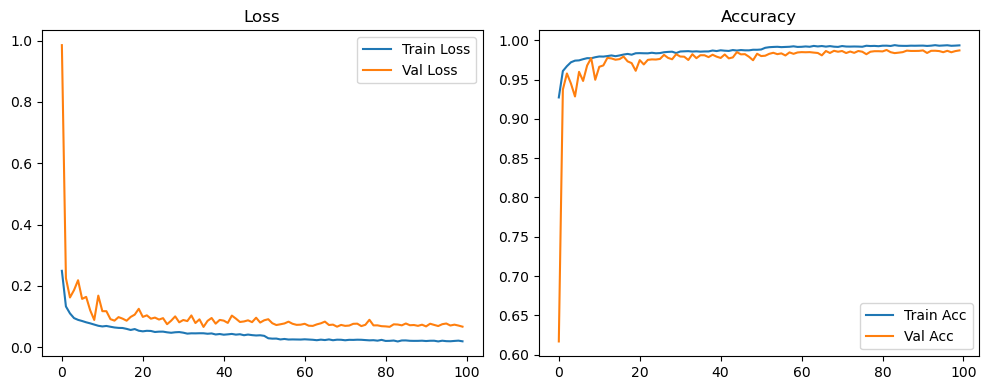

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1264, Acc: 0.9670 | Val Loss: 0.0618, Acc: 0.9808


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9859 | Val Loss: 0.0402, Acc: 0.9875


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9903 | Val Loss: 0.0416, Acc: 0.9864


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0486, Acc: 0.9845


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.0402, Acc: 0.9886


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0356, Acc: 0.9896


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0391, Acc: 0.9888


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0417, Acc: 0.9880


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0502, Acc: 0.9867


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0443, Acc: 0.9886


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0533, Acc: 0.9866


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0499, Acc: 0.9868


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0525, Acc: 0.9873


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0430, Acc: 0.9895


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0472, Acc: 0.9896


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.0557, Acc: 0.9855


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0533, Acc: 0.9872


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0534, Acc: 0.9879


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0467, Acc: 0.9893


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0447, Acc: 0.9907


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0507, Acc: 0.9889


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0555, Acc: 0.9885


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0535, Acc: 0.9878


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0466, Acc: 0.9908


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0475, Acc: 0.9908


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0476, Acc: 0.9897


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0435, Acc: 0.9911


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0526, Acc: 0.9898


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0573, Acc: 0.9879


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0497, Acc: 0.9895


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0608, Acc: 0.9886


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0489, Acc: 0.9907


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0484, Acc: 0.9905


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0560, Acc: 0.9887


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0523, Acc: 0.9884


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0390, Acc: 0.9918


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0425, Acc: 0.9907


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0512, Acc: 0.9902


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0541, Acc: 0.9891


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0544, Acc: 0.9905


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0503, Acc: 0.9903


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0535, Acc: 0.9905


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0523, Acc: 0.9900


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0541, Acc: 0.9914


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0572, Acc: 0.9902


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0517, Acc: 0.9902


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0548, Acc: 0.9902


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0611, Acc: 0.9894


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0549, Acc: 0.9901


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0480, Acc: 0.9912


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0546, Acc: 0.9896


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0525, Acc: 0.9908


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0507, Acc: 0.9920


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0494, Acc: 0.9907


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0610, Acc: 0.9902


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0517, Acc: 0.9916


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0528, Acc: 0.9908


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0605, Acc: 0.9898


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0554, Acc: 0.9902


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0700, Acc: 0.9892


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0637, Acc: 0.9892


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0565, Acc: 0.9904


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0644, Acc: 0.9904


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0596, Acc: 0.9908


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0651, Acc: 0.9901


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0719, Acc: 0.9898


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0594, Acc: 0.9898


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0559, Acc: 0.9902


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0591, Acc: 0.9899


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0641, Acc: 0.9901


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0583, Acc: 0.9892


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0519, Acc: 0.9911


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0633, Acc: 0.9898


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0685, Acc: 0.9892


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0692, Acc: 0.9897


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0662, Acc: 0.9891


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0588, Acc: 0.9908


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0738, Acc: 0.9881


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0610, Acc: 0.9909


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0611, Acc: 0.9912


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0579, Acc: 0.9913


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0665, Acc: 0.9904


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0629, Acc: 0.9902


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0702, Acc: 0.9897


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0558, Acc: 0.9912


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0524, Acc: 0.9914


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0576, Acc: 0.9903


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0552, Acc: 0.9918


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0639, Acc: 0.9898


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0596, Acc: 0.9902


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0626, Acc: 0.9894


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0609, Acc: 0.9908


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0664, Acc: 0.9892


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0699, Acc: 0.9890


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0580, Acc: 0.9906


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0555, Acc: 0.9900


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0605, Acc: 0.9898


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0595, Acc: 0.9911


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0605, Acc: 0.9908


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0535, Acc: 0.9921


Final Test Loss: 0.0574 Accuracy: 0.9917


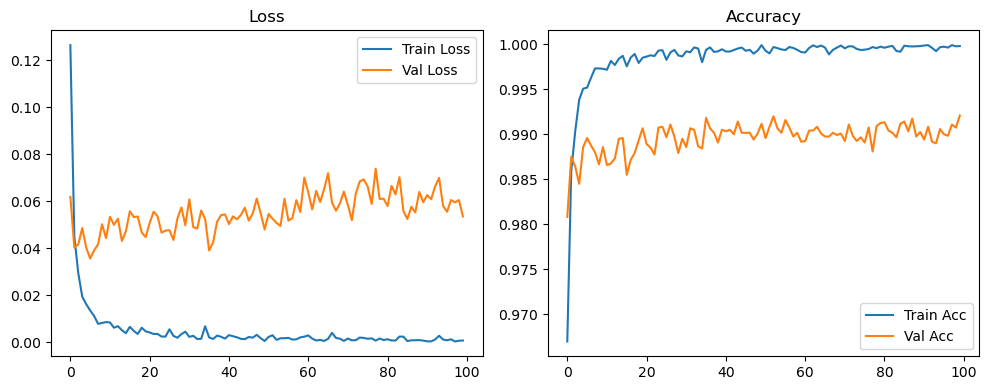

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1537, Acc: 0.9601 | Val Loss: 0.1184, Acc: 0.9617


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9794 | Val Loss: 0.0849, Acc: 0.9731


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9842 | Val Loss: 0.0524, Acc: 0.9839


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9872 | Val Loss: 0.0616, Acc: 0.9808


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9892 | Val Loss: 0.0539, Acc: 0.9829


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.0575, Acc: 0.9818


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0514, Acc: 0.9848


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0552, Acc: 0.9825


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0409, Acc: 0.9871


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0399, Acc: 0.9879


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0471, Acc: 0.9864


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0365, Acc: 0.9889


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0460, Acc: 0.9868


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0394, Acc: 0.9887


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.0374, Acc: 0.9888


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0492, Acc: 0.9860


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0399, Acc: 0.9887


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0363, Acc: 0.9888


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.0439, Acc: 0.9878


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0481, Acc: 0.9868


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0416, Acc: 0.9880


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0408, Acc: 0.9886


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0386, Acc: 0.9898


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0385, Acc: 0.9898


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0403, Acc: 0.9895


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0451, Acc: 0.9880


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0466, Acc: 0.9878


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0417, Acc: 0.9888


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0388, Acc: 0.9899


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0390, Acc: 0.9906


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9973 | Val Loss: 0.0354, Acc: 0.9907


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.0504, Acc: 0.9878


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0458, Acc: 0.9872


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0534, Acc: 0.9862


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0367, Acc: 0.9906


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0463, Acc: 0.9879


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0381, Acc: 0.9902


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0380, Acc: 0.9902


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0426, Acc: 0.9899


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0380, Acc: 0.9907


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0455, Acc: 0.9898


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0432, Acc: 0.9898


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0432, Acc: 0.9901


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0542, Acc: 0.9878


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0416, Acc: 0.9897


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0426, Acc: 0.9887


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0501, Acc: 0.9871


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0535, Acc: 0.9881


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0415, Acc: 0.9908


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9977 | Val Loss: 0.0472, Acc: 0.9900


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0417, Acc: 0.9879


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0520, Acc: 0.9869


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0525, Acc: 0.9868


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0470, Acc: 0.9895


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0467, Acc: 0.9893


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0512, Acc: 0.9885


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0566, Acc: 0.9880


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9977 | Val Loss: 0.0469, Acc: 0.9892


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0487, Acc: 0.9888


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0611, Acc: 0.9857


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0471, Acc: 0.9890


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0498, Acc: 0.9889


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0523, Acc: 0.9877


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0512, Acc: 0.9878


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0457, Acc: 0.9901


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0486, Acc: 0.9879


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0434, Acc: 0.9906


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0538, Acc: 0.9878


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0541, Acc: 0.9880


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0402, Acc: 0.9900


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0496, Acc: 0.9876


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0523, Acc: 0.9875


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0519, Acc: 0.9886


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0543, Acc: 0.9864


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0443, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0457, Acc: 0.9900


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0447, Acc: 0.9902


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0422, Acc: 0.9894


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0468, Acc: 0.9882


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0521, Acc: 0.9872


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0438, Acc: 0.9889


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0389, Acc: 0.9902


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0463, Acc: 0.9892


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0419, Acc: 0.9909


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0485, Acc: 0.9897


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0430, Acc: 0.9902


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0510, Acc: 0.9879


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0467, Acc: 0.9888


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0457, Acc: 0.9902


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0413, Acc: 0.9900


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0446, Acc: 0.9898


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0442, Acc: 0.9899


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0409, Acc: 0.9898


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0399, Acc: 0.9899


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0497, Acc: 0.9883


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0398, Acc: 0.9894


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0483, Acc: 0.9881


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0441, Acc: 0.9898


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0402, Acc: 0.9903


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0492, Acc: 0.9890


Final Test Loss: 0.0426 Accuracy: 0.9887


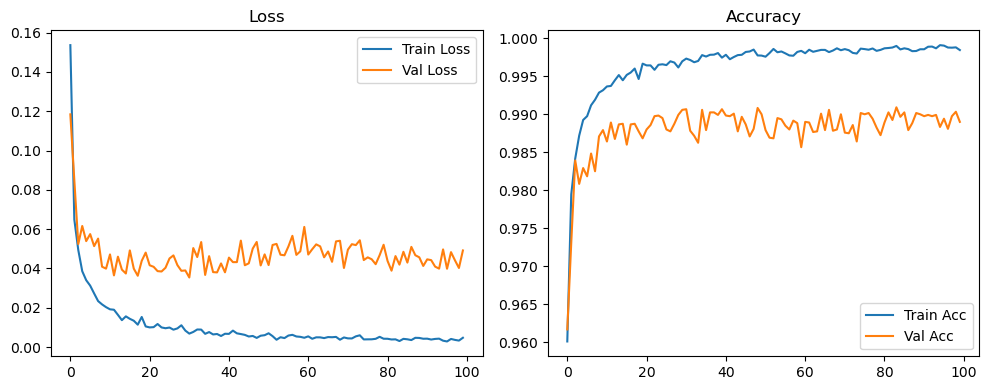

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2551, Acc: 0.9307 | Val Loss: 0.7519, Acc: 0.7195


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1258, Acc: 0.9630 | Val Loss: 0.4312, Acc: 0.8540


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1051, Acc: 0.9693 | Val Loss: 0.2079, Acc: 0.9379


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9732 | Val Loss: 0.2295, Acc: 0.9257


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0837, Acc: 0.9751 | Val Loss: 0.2588, Acc: 0.9137


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9768 | Val Loss: 0.1766, Acc: 0.9489


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9772 | Val Loss: 0.1545, Acc: 0.9537


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0705, Acc: 0.9786 | Val Loss: 0.1011, Acc: 0.9716


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9787 | Val Loss: 0.1125, Acc: 0.9693


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9799 | Val Loss: 0.1629, Acc: 0.9494


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9807 | Val Loss: 0.1285, Acc: 0.9607


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9804 | Val Loss: 0.1223, Acc: 0.9627


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9822 | Val Loss: 0.1436, Acc: 0.9533


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0599, Acc: 0.9818 | Val Loss: 0.1163, Acc: 0.9651


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9807 | Val Loss: 0.1282, Acc: 0.9628


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9829 | Val Loss: 0.1254, Acc: 0.9628


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9828 | Val Loss: 0.0928, Acc: 0.9746


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9845 | Val Loss: 0.1079, Acc: 0.9689


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9829 | Val Loss: 0.0900, Acc: 0.9712


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9844 | Val Loss: 0.1199, Acc: 0.9651


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9847 | Val Loss: 0.1000, Acc: 0.9728


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9857 | Val Loss: 0.0824, Acc: 0.9760


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9852 | Val Loss: 0.0770, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9864 | Val Loss: 0.0685, Acc: 0.9818


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9856 | Val Loss: 0.0882, Acc: 0.9755


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.0801, Acc: 0.9762


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9854 | Val Loss: 0.0954, Acc: 0.9722


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.0877, Acc: 0.9776


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.0697, Acc: 0.9812


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9864 | Val Loss: 0.0599, Acc: 0.9840


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.0742, Acc: 0.9798


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.0864, Acc: 0.9754


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9868 | Val Loss: 0.0843, Acc: 0.9771


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 0.0805, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.0769, Acc: 0.9787


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9871 | Val Loss: 0.0806, Acc: 0.9774


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 0.0614, Acc: 0.9828


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.0680, Acc: 0.9817


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.0716, Acc: 0.9820


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.0849, Acc: 0.9762


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9867 | Val Loss: 0.0972, Acc: 0.9730


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9884 | Val Loss: 0.0708, Acc: 0.9821


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9877 | Val Loss: 0.0764, Acc: 0.9802


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0687, Acc: 0.9802


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9879 | Val Loss: 0.0844, Acc: 0.9757


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.0704, Acc: 0.9821


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9881 | Val Loss: 0.0862, Acc: 0.9767


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.0753, Acc: 0.9803


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.0658, Acc: 0.9842


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0685, Acc: 0.9823


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9885 | Val Loss: 0.0804, Acc: 0.9813


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.0830, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0846, Acc: 0.9784


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0750, Acc: 0.9839


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0737, Acc: 0.9824


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0623, Acc: 0.9870


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.0821, Acc: 0.9810


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.0641, Acc: 0.9848


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9900 | Val Loss: 0.0632, Acc: 0.9850


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9901 | Val Loss: 0.0614, Acc: 0.9841


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0671, Acc: 0.9857


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9888 | Val Loss: 0.0790, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.0729, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0948, Acc: 0.9764


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.0737, Acc: 0.9823


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9895 | Val Loss: 0.0663, Acc: 0.9835


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.0876, Acc: 0.9775


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0749, Acc: 0.9805


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0844, Acc: 0.9815


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9896 | Val Loss: 0.0714, Acc: 0.9842


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0765, Acc: 0.9823


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.0836, Acc: 0.9825


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0824, Acc: 0.9805


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0817, Acc: 0.9841


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.0681, Acc: 0.9832


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0787, Acc: 0.9819


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9897 | Val Loss: 0.0972, Acc: 0.9794


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9907 | Val Loss: 0.0820, Acc: 0.9837


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.0957, Acc: 0.9827


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0818, Acc: 0.9838


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.0839, Acc: 0.9838


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.0816, Acc: 0.9838


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.0927, Acc: 0.9774


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.0705, Acc: 0.9859


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0852, Acc: 0.9809


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0845, Acc: 0.9802


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0832, Acc: 0.9848


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0893, Acc: 0.9823


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0852, Acc: 0.9832


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0917, Acc: 0.9842


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0908, Acc: 0.9803


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.0950, Acc: 0.9808


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.0782, Acc: 0.9853


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9906 | Val Loss: 0.0955, Acc: 0.9855


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9914 | Val Loss: 0.0941, Acc: 0.9802


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0909, Acc: 0.9840


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.1058, Acc: 0.9774


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0957, Acc: 0.9796


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9911 | Val Loss: 0.0764, Acc: 0.9838


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0829, Acc: 0.9858


Final Test Loss: 0.0785 Accuracy: 0.9866


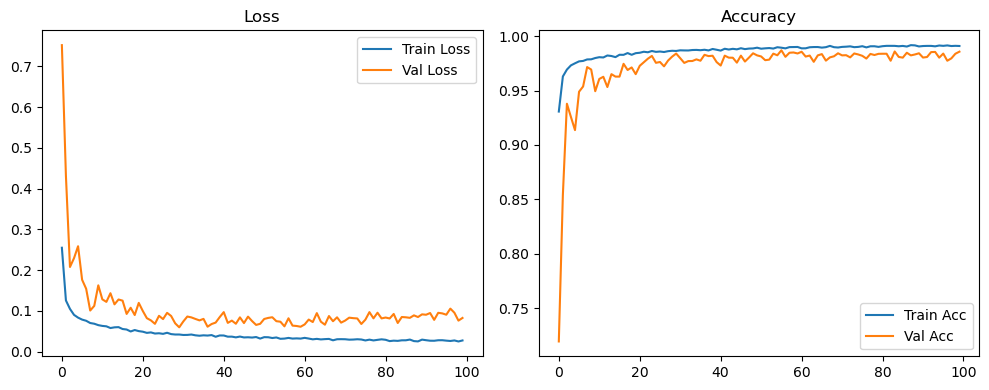

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1265, Acc: 0.9668 | Val Loss: 0.0525, Acc: 0.9839


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.0411, Acc: 0.9876


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.0471, Acc: 0.9870


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0488, Acc: 0.9852


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0495, Acc: 0.9864


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0545, Acc: 0.9842


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0391, Acc: 0.9890


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0515, Acc: 0.9861


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0427, Acc: 0.9892


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0501, Acc: 0.9866


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0493, Acc: 0.9876


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0523, Acc: 0.9869


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0508, Acc: 0.9873


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0492, Acc: 0.9877


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0403, Acc: 0.9902


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0445, Acc: 0.9901


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0411, Acc: 0.9902


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0484, Acc: 0.9893


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0578, Acc: 0.9870


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0638, Acc: 0.9852


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0451, Acc: 0.9898


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0564, Acc: 0.9873


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0538, Acc: 0.9873


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0484, Acc: 0.9894


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0438, Acc: 0.9902


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0475, Acc: 0.9900


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0471, Acc: 0.9898


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0468, Acc: 0.9898


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0602, Acc: 0.9870


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0536, Acc: 0.9899


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0440, Acc: 0.9902


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0462, Acc: 0.9908


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9905


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0582, Acc: 0.9879


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0570, Acc: 0.9878


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0493, Acc: 0.9909


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0474, Acc: 0.9906


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0515, Acc: 0.9892


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0433, Acc: 0.9904


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0631, Acc: 0.9882


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0639, Acc: 0.9880


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0537, Acc: 0.9890


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0479, Acc: 0.9902


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0456, Acc: 0.9901


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0456, Acc: 0.9912


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0436, Acc: 0.9913


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0613, Acc: 0.9899


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0553, Acc: 0.9901


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0546, Acc: 0.9899


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0518, Acc: 0.9904


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0478, Acc: 0.9902


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0458, Acc: 0.9918


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9917


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9909


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9912


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9912


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9915


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9917


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9915


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9918


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9918


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9918


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9914


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0556, Acc: 0.9901


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0535, Acc: 0.9911


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9917


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9929


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9913


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9918


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9915


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9917


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9910


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0565, Acc: 0.9905


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0541, Acc: 0.9906


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9915


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9916


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9916


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9914


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9916


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9917


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9916


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9917


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9917


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9916


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9917


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9919


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9918


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9919


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9920


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9918


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9922


Final Test Loss: 0.0522 Accuracy: 0.9920


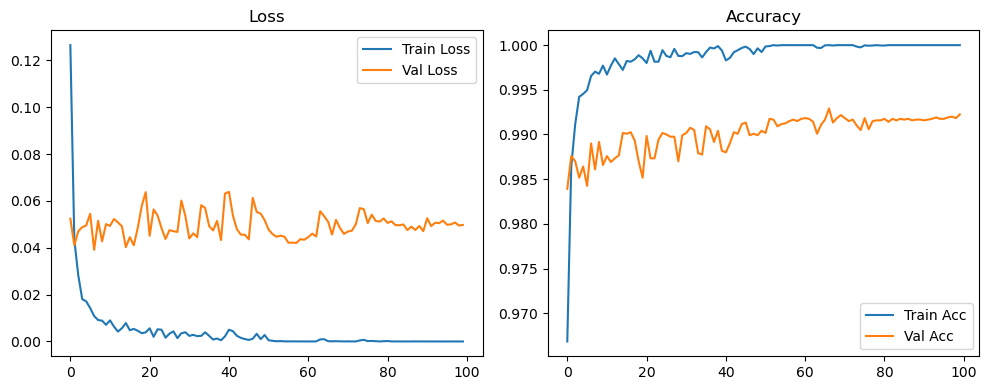

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1531, Acc: 0.9594 | Val Loss: 0.0984, Acc: 0.9698


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9802 | Val Loss: 0.0667, Acc: 0.9805


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9839 | Val Loss: 0.0609, Acc: 0.9815


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9873 | Val Loss: 0.0549, Acc: 0.9822


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0622, Acc: 0.9798


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.0487, Acc: 0.9843


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.0455, Acc: 0.9852


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9914 | Val Loss: 0.0483, Acc: 0.9844


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.0359, Acc: 0.9894


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0475, Acc: 0.9855


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.0479, Acc: 0.9861


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9934 | Val Loss: 0.0496, Acc: 0.9863


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0423, Acc: 0.9881


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9943 | Val Loss: 0.0550, Acc: 0.9835


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0414, Acc: 0.9888


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9951 | Val Loss: 0.0452, Acc: 0.9878


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0471, Acc: 0.9866


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0452, Acc: 0.9876


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0489, Acc: 0.9858


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0360, Acc: 0.9897


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9962 | Val Loss: 0.0433, Acc: 0.9888


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0459, Acc: 0.9872


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0430, Acc: 0.9888


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0426, Acc: 0.9884


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9963 | Val Loss: 0.0466, Acc: 0.9887


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0423, Acc: 0.9885


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0425, Acc: 0.9887


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0440, Acc: 0.9883


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0482, Acc: 0.9874


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0438, Acc: 0.9879


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0415, Acc: 0.9888


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0469, Acc: 0.9875


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0432, Acc: 0.9888


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0456, Acc: 0.9876


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0456, Acc: 0.9886


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9971 | Val Loss: 0.0511, Acc: 0.9873


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0494, Acc: 0.9875


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0444, Acc: 0.9893


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0415, Acc: 0.9899


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0437, Acc: 0.9896


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0445, Acc: 0.9897


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0453, Acc: 0.9889


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0376, Acc: 0.9904


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0462, Acc: 0.9886


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0326, Acc: 0.9918


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0380, Acc: 0.9904


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0462, Acc: 0.9882


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0414, Acc: 0.9898


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0568, Acc: 0.9870


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0411, Acc: 0.9904


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0345, Acc: 0.9915


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0428, Acc: 0.9897


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0351, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0367, Acc: 0.9912


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0392, Acc: 0.9906


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0339, Acc: 0.9923


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0356, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0364, Acc: 0.9912


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0334, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0435, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0410, Acc: 0.9912


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0398, Acc: 0.9909


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0440, Acc: 0.9904


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0372, Acc: 0.9921


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0382, Acc: 0.9909


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0369, Acc: 0.9910


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0365, Acc: 0.9921


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0406, Acc: 0.9912


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0408, Acc: 0.9912


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0378, Acc: 0.9918


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0366, Acc: 0.9917


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0362, Acc: 0.9919


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.0400, Acc: 0.9912


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0379, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0431, Acc: 0.9909


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9912


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0399, Acc: 0.9916


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0378, Acc: 0.9920


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0371, Acc: 0.9917


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9910


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0415, Acc: 0.9911


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0356, Acc: 0.9921


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0376, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0416, Acc: 0.9911


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0375, Acc: 0.9924


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0344, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0356, Acc: 0.9920


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0383, Acc: 0.9912


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0401, Acc: 0.9915


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0364, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0423, Acc: 0.9908


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0386, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0401, Acc: 0.9910


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0378, Acc: 0.9926


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0399, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0397, Acc: 0.9913


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0384, Acc: 0.9917


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0403, Acc: 0.9917


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0368, Acc: 0.9926


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0373, Acc: 0.9927


Final Test Loss: 0.0391 Accuracy: 0.9912


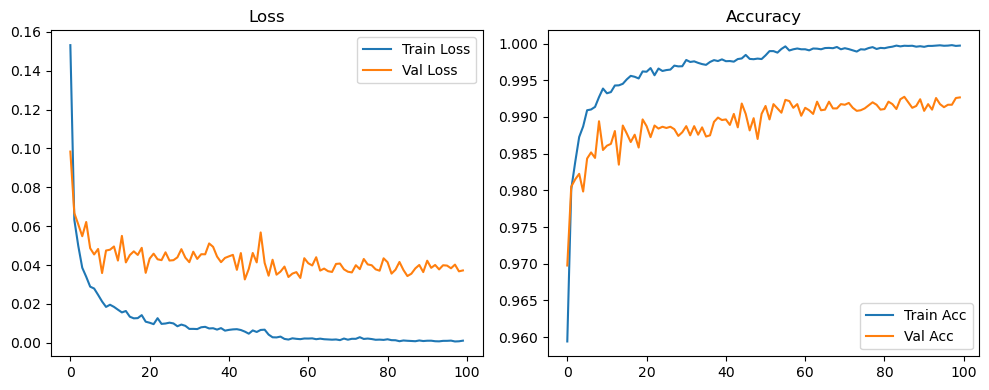

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2555, Acc: 0.9311 | Val Loss: 0.9554, Acc: 0.6302


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1253, Acc: 0.9629 | Val Loss: 0.4535, Acc: 0.8423


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1039, Acc: 0.9690 | Val Loss: 0.2639, Acc: 0.9142


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9730 | Val Loss: 0.2415, Acc: 0.9195


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0838, Acc: 0.9751 | Val Loss: 0.2079, Acc: 0.9336


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9759 | Val Loss: 0.1301, Acc: 0.9639


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9773 | Val Loss: 0.1844, Acc: 0.9423


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0713, Acc: 0.9786 | Val Loss: 0.1758, Acc: 0.9436


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9788 | Val Loss: 0.1415, Acc: 0.9568


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9808 | Val Loss: 0.1494, Acc: 0.9519


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9809 | Val Loss: 0.1091, Acc: 0.9682


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9810 | Val Loss: 0.1063, Acc: 0.9694


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9814 | Val Loss: 0.1154, Acc: 0.9647


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9824 | Val Loss: 0.1375, Acc: 0.9550


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9816 | Val Loss: 0.1274, Acc: 0.9631


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9826 | Val Loss: 0.1188, Acc: 0.9645


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9835 | Val Loss: 0.1111, Acc: 0.9663


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9840 | Val Loss: 0.0940, Acc: 0.9730


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9839 | Val Loss: 0.1014, Acc: 0.9706


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.1154, Acc: 0.9642


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9845 | Val Loss: 0.0962, Acc: 0.9720


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 0.0682, Acc: 0.9799


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9858 | Val Loss: 0.0779, Acc: 0.9790


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9864 | Val Loss: 0.0846, Acc: 0.9738


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9852 | Val Loss: 0.1010, Acc: 0.9683


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9854 | Val Loss: 0.0861, Acc: 0.9755


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9859 | Val Loss: 0.0831, Acc: 0.9782


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.0781, Acc: 0.9806


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9868 | Val Loss: 0.0908, Acc: 0.9740


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.0963, Acc: 0.9714


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9867 | Val Loss: 0.0906, Acc: 0.9740


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9866 | Val Loss: 0.1133, Acc: 0.9675


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9869 | Val Loss: 0.0796, Acc: 0.9763


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.0642, Acc: 0.9828


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0820, Acc: 0.9751


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9875 | Val Loss: 0.0773, Acc: 0.9791


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9873 | Val Loss: 0.0746, Acc: 0.9783


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.0617, Acc: 0.9844


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.0705, Acc: 0.9822


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9871 | Val Loss: 0.0864, Acc: 0.9792


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.0802, Acc: 0.9792


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9882 | Val Loss: 0.0774, Acc: 0.9809


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.0952, Acc: 0.9728


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0758, Acc: 0.9793


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.0722, Acc: 0.9821


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9877 | Val Loss: 0.0785, Acc: 0.9833


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9889 | Val Loss: 0.0792, Acc: 0.9780


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.0799, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9883 | Val Loss: 0.0978, Acc: 0.9768


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0962, Acc: 0.9752


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.0859, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9906 | Val Loss: 0.0864, Acc: 0.9802


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0779, Acc: 0.9828


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.0811, Acc: 0.9822


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.0838, Acc: 0.9791


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.0723, Acc: 0.9853


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0742, Acc: 0.9840


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.0773, Acc: 0.9824


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0783, Acc: 0.9823


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9924 | Val Loss: 0.0680, Acc: 0.9843


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0726, Acc: 0.9828


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.0711, Acc: 0.9836


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0659, Acc: 0.9862


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.0718, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0653, Acc: 0.9852


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9918 | Val Loss: 0.0723, Acc: 0.9827


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.0728, Acc: 0.9861


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.0743, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9915 | Val Loss: 0.0761, Acc: 0.9822


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0806, Acc: 0.9815


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0716, Acc: 0.9853


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0710, Acc: 0.9851


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0827, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0761, Acc: 0.9840


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0723, Acc: 0.9843


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0782, Acc: 0.9841


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.0887, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9918 | Val Loss: 0.0707, Acc: 0.9848


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0749, Acc: 0.9838


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0701, Acc: 0.9850


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9927 | Val Loss: 0.0730, Acc: 0.9854


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9930 | Val Loss: 0.0707, Acc: 0.9846


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.0745, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9934 | Val Loss: 0.0679, Acc: 0.9855


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.0742, Acc: 0.9835


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0701, Acc: 0.9850


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9934 | Val Loss: 0.0757, Acc: 0.9858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.0763, Acc: 0.9845


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0637, Acc: 0.9860


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0734, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0707, Acc: 0.9859


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0706, Acc: 0.9866


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.0762, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0687, Acc: 0.9855


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0711, Acc: 0.9844


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9933 | Val Loss: 0.0742, Acc: 0.9840


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9935 | Val Loss: 0.0747, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9932 | Val Loss: 0.0705, Acc: 0.9840


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0693, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0635, Acc: 0.9863


Final Test Loss: 0.0599 Accuracy: 0.9865


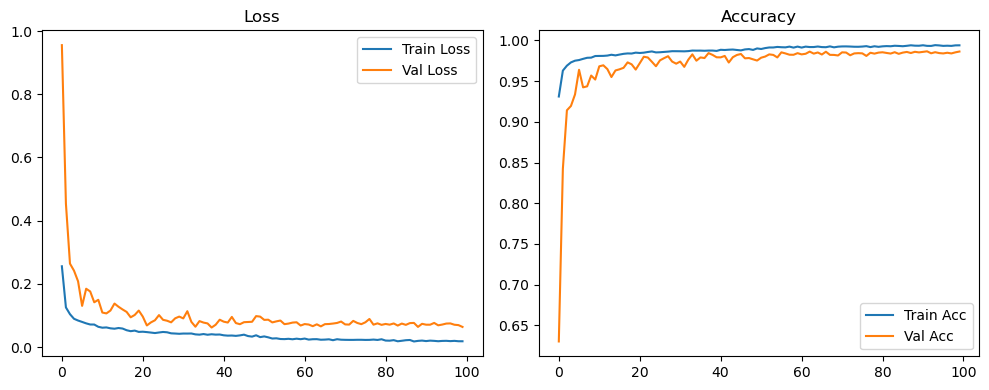

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1557, Acc: 0.9673 | Val Loss: 0.0606, Acc: 0.9826


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9871 | Val Loss: 0.0443, Acc: 0.9868


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9914 | Val Loss: 0.0421, Acc: 0.9881


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9945 | Val Loss: 0.0418, Acc: 0.9872


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.0431, Acc: 0.9868


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.0390, Acc: 0.9889


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.0360, Acc: 0.9889


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0404, Acc: 0.9888


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0412, Acc: 0.9880


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0374, Acc: 0.9901


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0479, Acc: 0.9871


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0420, Acc: 0.9888


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0389, Acc: 0.9900


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0413, Acc: 0.9899


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0400, Acc: 0.9895


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0446, Acc: 0.9888


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0497, Acc: 0.9870


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0459, Acc: 0.9888


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0500, Acc: 0.9866


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0500, Acc: 0.9881


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0530, Acc: 0.9868


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0477, Acc: 0.9896


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0444, Acc: 0.9895


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0450, Acc: 0.9895


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0479, Acc: 0.9879


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0483, Acc: 0.9895


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0483, Acc: 0.9881


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9902


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0439, Acc: 0.9899


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0507, Acc: 0.9885


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0384, Acc: 0.9909


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9921


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0376, Acc: 0.9923


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0516, Acc: 0.9878


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0566, Acc: 0.9879


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0466, Acc: 0.9901


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0480, Acc: 0.9898


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9904


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9911


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9908


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0498, Acc: 0.9899


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0504, Acc: 0.9892


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0448, Acc: 0.9907


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0447, Acc: 0.9912


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9921


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9912


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9908


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9912


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9916


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9906


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0648, Acc: 0.9866


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0505, Acc: 0.9909


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0423, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9918


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0429, Acc: 0.9915


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9919


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0439, Acc: 0.9918


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0580, Acc: 0.9884


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0527, Acc: 0.9901


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0483, Acc: 0.9908


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9910


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0502, Acc: 0.9915


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0577, Acc: 0.9902


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0511, Acc: 0.9903


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0524, Acc: 0.9908


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0504, Acc: 0.9912


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0528, Acc: 0.9909


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0576, Acc: 0.9889


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0567, Acc: 0.9907


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0519, Acc: 0.9910


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9914


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0539, Acc: 0.9898


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0584, Acc: 0.9894


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0512, Acc: 0.9906


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0495, Acc: 0.9916


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0440, Acc: 0.9919


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0480, Acc: 0.9911


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9916


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9915


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0589, Acc: 0.9900


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0567, Acc: 0.9903


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0692, Acc: 0.9889


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0580, Acc: 0.9908


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0537, Acc: 0.9900


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0496, Acc: 0.9918


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0537, Acc: 0.9905


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0488, Acc: 0.9911


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9917


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9913


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9918


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0654, Acc: 0.9895


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0575, Acc: 0.9907


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0486, Acc: 0.9916


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0474, Acc: 0.9915


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9905


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9912


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0507, Acc: 0.9917


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0585, Acc: 0.9893


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0569, Acc: 0.9902


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0593, Acc: 0.9902


Final Test Loss: 0.0479 Accuracy: 0.9905


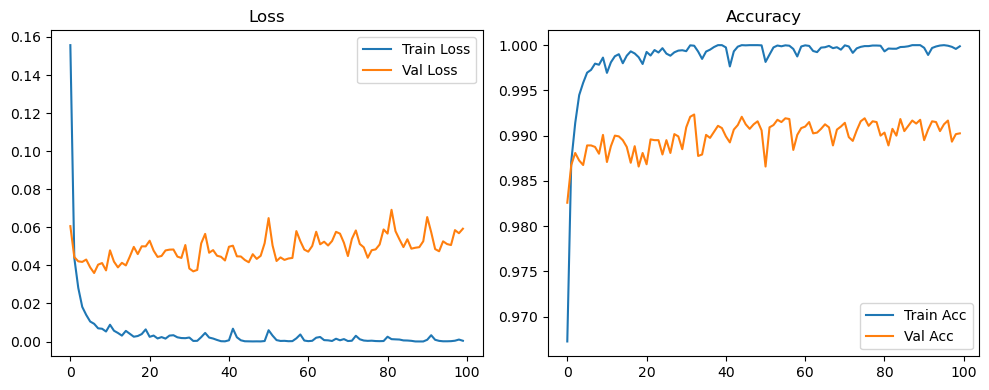

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1859, Acc: 0.9607 | Val Loss: 0.1099, Acc: 0.9700


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9806 | Val Loss: 0.0756, Acc: 0.9789


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9852 | Val Loss: 0.0789, Acc: 0.9762


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 0.0699, Acc: 0.9801


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9896 | Val Loss: 0.0625, Acc: 0.9815


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.0647, Acc: 0.9791


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0530, Acc: 0.9857


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9919 | Val Loss: 0.0517, Acc: 0.9849


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0437, Acc: 0.9868


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0470, Acc: 0.9860


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0415, Acc: 0.9888


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9934 | Val Loss: 0.0424, Acc: 0.9884


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0517, Acc: 0.9847


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0406, Acc: 0.9874


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0439, Acc: 0.9877


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0419, Acc: 0.9872


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0469, Acc: 0.9875


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9960 | Val Loss: 0.0461, Acc: 0.9877


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0418, Acc: 0.9878


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0435, Acc: 0.9889


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0415, Acc: 0.9885


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0359, Acc: 0.9900


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0454, Acc: 0.9882


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0459, Acc: 0.9881


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0400, Acc: 0.9895


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0442, Acc: 0.9886


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0470, Acc: 0.9876


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0432, Acc: 0.9892


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9969 | Val Loss: 0.0418, Acc: 0.9887


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0438, Acc: 0.9878


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0356, Acc: 0.9912


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0444, Acc: 0.9886


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0355, Acc: 0.9912


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0397, Acc: 0.9900


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0398, Acc: 0.9908


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0470, Acc: 0.9878


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0398, Acc: 0.9899


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0365, Acc: 0.9911


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0376, Acc: 0.9902


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0381, Acc: 0.9899


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0355, Acc: 0.9903


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0485, Acc: 0.9872


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0427, Acc: 0.9884


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0448, Acc: 0.9896


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0402, Acc: 0.9892


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0401, Acc: 0.9902


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0423, Acc: 0.9899


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0388, Acc: 0.9906


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0359, Acc: 0.9910


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.0415, Acc: 0.9901


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0382, Acc: 0.9903


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0472, Acc: 0.9887


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0464, Acc: 0.9892


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0433, Acc: 0.9897


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0424, Acc: 0.9898


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0380, Acc: 0.9905


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0364, Acc: 0.9910


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0378, Acc: 0.9908


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0340, Acc: 0.9911


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0366, Acc: 0.9910


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0370, Acc: 0.9912


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0348, Acc: 0.9909


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0374, Acc: 0.9907


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0367, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0398, Acc: 0.9907


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0364, Acc: 0.9912


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0362, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0429, Acc: 0.9899


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0442, Acc: 0.9899


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0413, Acc: 0.9908


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0421, Acc: 0.9904


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0440, Acc: 0.9898


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0417, Acc: 0.9916


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0402, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0382, Acc: 0.9902


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0384, Acc: 0.9914


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0340, Acc: 0.9915


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0375, Acc: 0.9904


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0332, Acc: 0.9919


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0403, Acc: 0.9896


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0373, Acc: 0.9908


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0358, Acc: 0.9913


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0374, Acc: 0.9909


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0391, Acc: 0.9906


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0370, Acc: 0.9914


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0354, Acc: 0.9919


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0361, Acc: 0.9919


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0416, Acc: 0.9908


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0399, Acc: 0.9908


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0374, Acc: 0.9919


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0333, Acc: 0.9918


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.0349, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0345, Acc: 0.9928


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0358, Acc: 0.9902


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0395, Acc: 0.9907


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0394, Acc: 0.9908


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0346, Acc: 0.9911


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0348, Acc: 0.9918


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0380, Acc: 0.9914


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0349, Acc: 0.9922


Final Test Loss: 0.0347 Accuracy: 0.9909


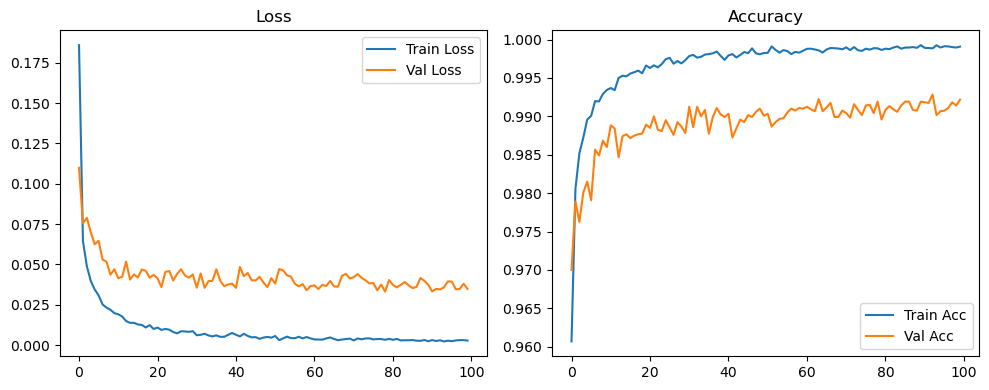

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3032, Acc: 0.9295 | Val Loss: 1.0260, Acc: 0.6202


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1305, Acc: 0.9625 | Val Loss: 0.6343, Acc: 0.7641


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1083, Acc: 0.9679 | Val Loss: 0.4232, Acc: 0.8477


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0914, Acc: 0.9735 | Val Loss: 0.2998, Acc: 0.8944


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9754 | Val Loss: 0.3279, Acc: 0.8852


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0780, Acc: 0.9769 | Val Loss: 0.2679, Acc: 0.9111


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9771 | Val Loss: 0.2397, Acc: 0.9247


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9789 | Val Loss: 0.2238, Acc: 0.9267


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9796 | Val Loss: 0.1474, Acc: 0.9559


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0633, Acc: 0.9805 | Val Loss: 0.2138, Acc: 0.9307


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0609, Acc: 0.9815 | Val Loss: 0.1348, Acc: 0.9603


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9815 | Val Loss: 0.1140, Acc: 0.9673


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9828 | Val Loss: 0.1727, Acc: 0.9458


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9833 | Val Loss: 0.1730, Acc: 0.9449


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9828 | Val Loss: 0.1633, Acc: 0.9453


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9842 | Val Loss: 0.1466, Acc: 0.9553


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9838 | Val Loss: 0.1058, Acc: 0.9696


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0476, Acc: 0.9853 | Val Loss: 0.0948, Acc: 0.9715


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9842 | Val Loss: 0.1020, Acc: 0.9695


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.1327, Acc: 0.9570


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.1002, Acc: 0.9698


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.0759, Acc: 0.9788


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9862 | Val Loss: 0.0746, Acc: 0.9790


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.0910, Acc: 0.9736


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9867 | Val Loss: 0.1036, Acc: 0.9688


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9875 | Val Loss: 0.0971, Acc: 0.9707


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9867 | Val Loss: 0.0811, Acc: 0.9763


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.0848, Acc: 0.9757


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0976, Acc: 0.9712


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9869 | Val Loss: 0.0951, Acc: 0.9729


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9878 | Val Loss: 0.1000, Acc: 0.9717


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9881 | Val Loss: 0.0892, Acc: 0.9747


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9872 | Val Loss: 0.0933, Acc: 0.9743


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9875 | Val Loss: 0.0780, Acc: 0.9781


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.0827, Acc: 0.9770


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.0954, Acc: 0.9729


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9880 | Val Loss: 0.0757, Acc: 0.9792


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.0870, Acc: 0.9740


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.0911, Acc: 0.9726


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.0901, Acc: 0.9753


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9875 | Val Loss: 0.1152, Acc: 0.9663


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.1063, Acc: 0.9690


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9894 | Val Loss: 0.0888, Acc: 0.9738


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.0852, Acc: 0.9763


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9893 | Val Loss: 0.0709, Acc: 0.9818


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0649, Acc: 0.9827


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.0799, Acc: 0.9771


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.0703, Acc: 0.9832


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.0696, Acc: 0.9823


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0768, Acc: 0.9795


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9895 | Val Loss: 0.0737, Acc: 0.9813


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9902 | Val Loss: 0.0694, Acc: 0.9833


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9896 | Val Loss: 0.0784, Acc: 0.9804


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.0957, Acc: 0.9749


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.1000, Acc: 0.9710


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0703, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.0879, Acc: 0.9781


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0954, Acc: 0.9763


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.0803, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0821, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0895, Acc: 0.9791


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0797, Acc: 0.9811


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.0745, Acc: 0.9832


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.0779, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0719, Acc: 0.9811


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.0783, Acc: 0.9807


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9900 | Val Loss: 0.0898, Acc: 0.9786


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9901 | Val Loss: 0.0958, Acc: 0.9753


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9902 | Val Loss: 0.0966, Acc: 0.9752


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.0857, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.0859, Acc: 0.9797


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.0855, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.0976, Acc: 0.9758


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9913 | Val Loss: 0.0834, Acc: 0.9813


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0770, Acc: 0.9803


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0850, Acc: 0.9818


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0932, Acc: 0.9774


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0880, Acc: 0.9799


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0824, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0964, Acc: 0.9779


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9903 | Val Loss: 0.0961, Acc: 0.9782


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0758, Acc: 0.9850


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0843, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9914 | Val Loss: 0.0761, Acc: 0.9838


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.1009, Acc: 0.9742


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1011, Acc: 0.9767


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0977, Acc: 0.9808


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.0992, Acc: 0.9774


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.1026, Acc: 0.9801


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.1016, Acc: 0.9786


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9911 | Val Loss: 0.0984, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.1154, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0896, Acc: 0.9812


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.1022, Acc: 0.9807


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.0882, Acc: 0.9827


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9911 | Val Loss: 0.0895, Acc: 0.9809


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.1056, Acc: 0.9788


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1137, Acc: 0.9764


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.1077, Acc: 0.9821


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0922, Acc: 0.9830


Final Test Loss: 0.0901 Accuracy: 0.9818


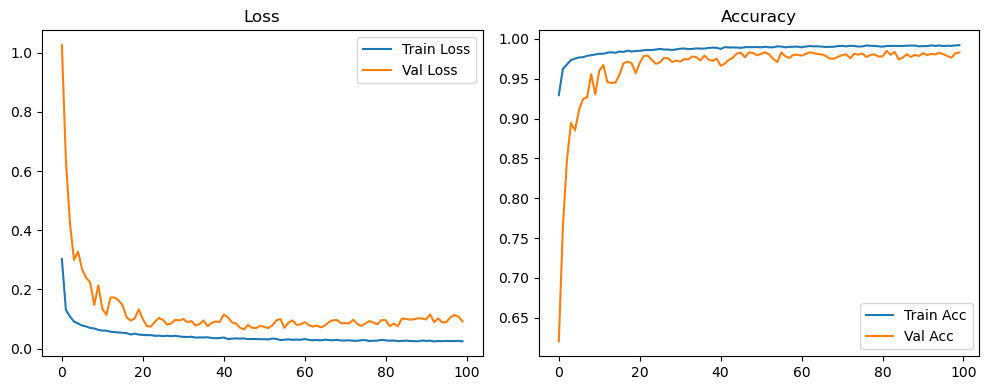

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2057, Acc: 0.9661 | Val Loss: 0.0665, Acc: 0.9822


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9874 | Val Loss: 0.0507, Acc: 0.9860


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9919 | Val Loss: 0.0442, Acc: 0.9866


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9946 | Val Loss: 0.0390, Acc: 0.9886


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9961 | Val Loss: 0.0405, Acc: 0.9874


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.0381, Acc: 0.9892


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9982 | Val Loss: 0.0350, Acc: 0.9889


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9985 | Val Loss: 0.0555, Acc: 0.9828


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0408, Acc: 0.9882


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0441, Acc: 0.9866


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0483, Acc: 0.9848


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0474, Acc: 0.9875


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0423, Acc: 0.9884


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0353, Acc: 0.9901


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0399, Acc: 0.9898


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0402, Acc: 0.9900


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0524, Acc: 0.9862


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0447, Acc: 0.9884


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0448, Acc: 0.9876


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0432, Acc: 0.9875


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0481, Acc: 0.9872


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0450, Acc: 0.9877


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0451, Acc: 0.9892


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0551, Acc: 0.9868


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0479, Acc: 0.9889


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0395, Acc: 0.9900


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9907


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0447, Acc: 0.9891


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0364, Acc: 0.9910


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9911


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0515, Acc: 0.9879


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0420, Acc: 0.9898


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0386, Acc: 0.9903


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0398, Acc: 0.9897


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0390, Acc: 0.9914


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9908


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9919


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0535, Acc: 0.9874


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0506, Acc: 0.9888


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0440, Acc: 0.9898


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0425, Acc: 0.9893


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0394, Acc: 0.9902


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0430, Acc: 0.9907


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0481, Acc: 0.9892


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0427, Acc: 0.9893


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0432, Acc: 0.9911


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0559, Acc: 0.9881


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0431, Acc: 0.9904


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0461, Acc: 0.9905


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0544, Acc: 0.9889


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0460, Acc: 0.9908


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0444, Acc: 0.9908


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0423, Acc: 0.9915


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0465, Acc: 0.9901


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0461, Acc: 0.9909


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0543, Acc: 0.9892


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0408, Acc: 0.9916


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0570, Acc: 0.9892


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0470, Acc: 0.9902


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0511, Acc: 0.9902


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0429, Acc: 0.9917


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0406, Acc: 0.9912


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0432, Acc: 0.9909


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9920


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9925


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9924


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0496, Acc: 0.9892


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0475, Acc: 0.9902


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0474, Acc: 0.9901


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9908


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9912


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9909


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0476, Acc: 0.9908


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0449, Acc: 0.9902


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0484, Acc: 0.9908


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0474, Acc: 0.9902


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0496, Acc: 0.9913


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0439, Acc: 0.9908


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0447, Acc: 0.9903


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0456, Acc: 0.9899


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0468, Acc: 0.9910


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0435, Acc: 0.9912


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0484, Acc: 0.9894


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0481, Acc: 0.9898


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0486, Acc: 0.9914


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0481, Acc: 0.9914


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0494, Acc: 0.9906


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0514, Acc: 0.9902


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0546, Acc: 0.9896


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0448, Acc: 0.9908


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0486, Acc: 0.9914


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0541, Acc: 0.9896


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0460, Acc: 0.9905


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0570, Acc: 0.9893


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0578, Acc: 0.9896


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0488, Acc: 0.9901


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9912


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9912


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9904


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9912


Final Test Loss: 0.0463 Accuracy: 0.9908


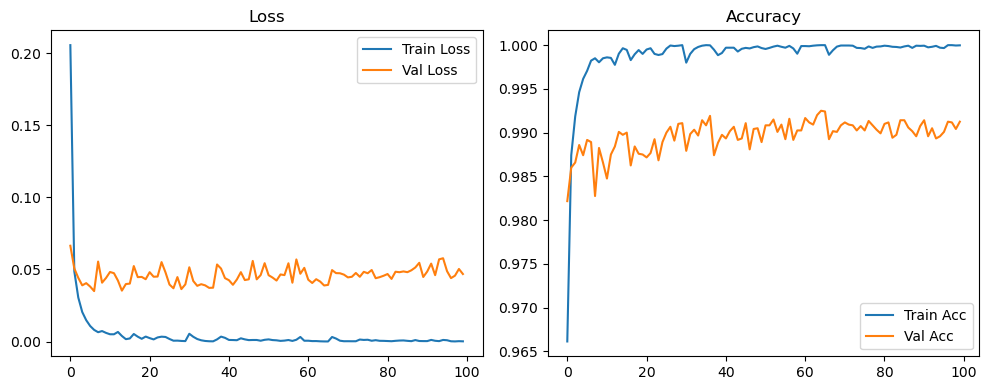

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2437, Acc: 0.9581 | Val Loss: 0.1993, Acc: 0.9490


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9811 | Val Loss: 0.0902, Acc: 0.9768


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0504, Acc: 0.9856 | Val Loss: 0.0904, Acc: 0.9742


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9876 | Val Loss: 0.0762, Acc: 0.9788


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9893 | Val Loss: 0.0652, Acc: 0.9807


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9902 | Val Loss: 0.0635, Acc: 0.9815


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9918 | Val Loss: 0.0478, Acc: 0.9861


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.0614, Acc: 0.9802


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0487, Acc: 0.9849


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9937 | Val Loss: 0.0566, Acc: 0.9821


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0487, Acc: 0.9856


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0442, Acc: 0.9870


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0552, Acc: 0.9831


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0451, Acc: 0.9868


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9943 | Val Loss: 0.0516, Acc: 0.9847


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0498, Acc: 0.9840


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0462, Acc: 0.9867


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0413, Acc: 0.9881


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0378, Acc: 0.9883


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0405, Acc: 0.9884


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0397, Acc: 0.9883


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0351, Acc: 0.9895


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0440, Acc: 0.9880


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0392, Acc: 0.9891


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0519, Acc: 0.9857


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0448, Acc: 0.9883


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0415, Acc: 0.9877


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0495, Acc: 0.9861


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0455, Acc: 0.9881


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0382, Acc: 0.9899


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0388, Acc: 0.9896


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0495, Acc: 0.9862


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0408, Acc: 0.9889


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0417, Acc: 0.9889


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0430, Acc: 0.9878


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0547, Acc: 0.9850


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0468, Acc: 0.9872


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0410, Acc: 0.9893


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0338, Acc: 0.9910


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0389, Acc: 0.9897


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0439, Acc: 0.9886


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0473, Acc: 0.9886


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0415, Acc: 0.9898


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0355, Acc: 0.9920


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0392, Acc: 0.9904


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0378, Acc: 0.9901


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0484, Acc: 0.9884


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0513, Acc: 0.9877


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.0443, Acc: 0.9887


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0437, Acc: 0.9891


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0451, Acc: 0.9884


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0397, Acc: 0.9900


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0402, Acc: 0.9899


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0423, Acc: 0.9893


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0365, Acc: 0.9905


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.0406, Acc: 0.9898


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0378, Acc: 0.9908


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0323, Acc: 0.9921


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0335, Acc: 0.9913


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0380, Acc: 0.9904


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0482, Acc: 0.9885


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0359, Acc: 0.9904


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0410, Acc: 0.9901


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0412, Acc: 0.9903


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0414, Acc: 0.9885


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0403, Acc: 0.9904


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0399, Acc: 0.9900


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0469, Acc: 0.9878


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0441, Acc: 0.9895


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0440, Acc: 0.9900


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0394, Acc: 0.9905


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0382, Acc: 0.9907


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0379, Acc: 0.9910


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0397, Acc: 0.9902


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0391, Acc: 0.9908


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0338, Acc: 0.9912


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0392, Acc: 0.9905


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0374, Acc: 0.9914


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0395, Acc: 0.9902


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0420, Acc: 0.9899


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0393, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0418, Acc: 0.9908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0417, Acc: 0.9904


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0385, Acc: 0.9906


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0426, Acc: 0.9905


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0395, Acc: 0.9906


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0364, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0395, Acc: 0.9909


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0388, Acc: 0.9902


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0372, Acc: 0.9914


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0427, Acc: 0.9899


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0410, Acc: 0.9903


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0407, Acc: 0.9900


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0419, Acc: 0.9904


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0437, Acc: 0.9898


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0428, Acc: 0.9902


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0424, Acc: 0.9898


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0409, Acc: 0.9899


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0404, Acc: 0.9909


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0384, Acc: 0.9918


Final Test Loss: 0.0358 Accuracy: 0.9908


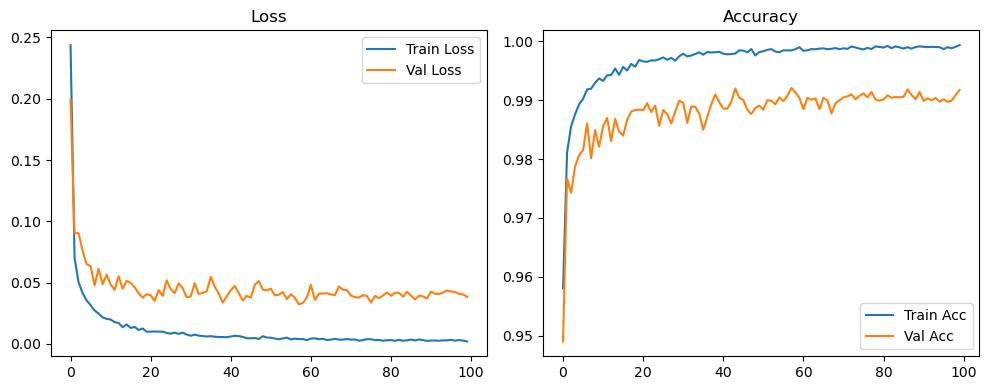

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3894, Acc: 0.9203 | Val Loss: 1.3608, Acc: 0.4854


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1463, Acc: 0.9608 | Val Loss: 0.9768, Acc: 0.6499


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1176, Acc: 0.9674 | Val Loss: 0.9592, Acc: 0.6701


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0995, Acc: 0.9721 | Val Loss: 0.7083, Acc: 0.7281


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0922, Acc: 0.9738 | Val Loss: 0.6366, Acc: 0.7635


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9754 | Val Loss: 0.4698, Acc: 0.8316


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0794, Acc: 0.9753 | Val Loss: 0.4118, Acc: 0.8501


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0756, Acc: 0.9768 | Val Loss: 0.2743, Acc: 0.9062


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0727, Acc: 0.9789 | Val Loss: 0.3117, Acc: 0.8875


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0689, Acc: 0.9789 | Val Loss: 0.2854, Acc: 0.9022


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0645, Acc: 0.9801 | Val Loss: 0.2128, Acc: 0.9303


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9805 | Val Loss: 0.1557, Acc: 0.9511


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0607, Acc: 0.9809 | Val Loss: 0.1610, Acc: 0.9493


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9821 | Val Loss: 0.1403, Acc: 0.9569


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9823 | Val Loss: 0.1708, Acc: 0.9436


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9825 | Val Loss: 0.2006, Acc: 0.9337


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0542, Acc: 0.9830 | Val Loss: 0.1559, Acc: 0.9508


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9836 | Val Loss: 0.1297, Acc: 0.9573


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9845 | Val Loss: 0.1095, Acc: 0.9676


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9849 | Val Loss: 0.1261, Acc: 0.9627


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9846 | Val Loss: 0.1346, Acc: 0.9593


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9858 | Val Loss: 0.0980, Acc: 0.9706


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9857 | Val Loss: 0.1337, Acc: 0.9596


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.1139, Acc: 0.9649


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9862 | Val Loss: 0.1264, Acc: 0.9604


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9863 | Val Loss: 0.1327, Acc: 0.9557


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9861 | Val Loss: 0.0941, Acc: 0.9722


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9863 | Val Loss: 0.0915, Acc: 0.9738


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.1029, Acc: 0.9698


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9862 | Val Loss: 0.0988, Acc: 0.9698


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9879 | Val Loss: 0.1150, Acc: 0.9643


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9885 | Val Loss: 0.1023, Acc: 0.9688


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.1055, Acc: 0.9672


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9877 | Val Loss: 0.0974, Acc: 0.9695


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9882 | Val Loss: 0.0882, Acc: 0.9738


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.1059, Acc: 0.9687


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0815, Acc: 0.9752


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0851, Acc: 0.9751


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.0686, Acc: 0.9810


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9885 | Val Loss: 0.0791, Acc: 0.9782


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.1103, Acc: 0.9650


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.0853, Acc: 0.9748


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9886 | Val Loss: 0.0921, Acc: 0.9715


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9896 | Val Loss: 0.0658, Acc: 0.9812


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0587, Acc: 0.9846


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9886 | Val Loss: 0.0753, Acc: 0.9760


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9892 | Val Loss: 0.1116, Acc: 0.9652


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9896 | Val Loss: 0.0775, Acc: 0.9784


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9898 | Val Loss: 0.0638, Acc: 0.9816


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9900 | Val Loss: 0.0735, Acc: 0.9793


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0838, Acc: 0.9769


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0791, Acc: 0.9775


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9897 | Val Loss: 0.0762, Acc: 0.9801


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.0686, Acc: 0.9842


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0904, Acc: 0.9742


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0724, Acc: 0.9804


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.0857, Acc: 0.9762


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9902 | Val Loss: 0.0760, Acc: 0.9807


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0728, Acc: 0.9804


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.0726, Acc: 0.9804


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.0818, Acc: 0.9781


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.0651, Acc: 0.9842


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.0661, Acc: 0.9852


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0841, Acc: 0.9787


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0660, Acc: 0.9826


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.0796, Acc: 0.9787


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0698, Acc: 0.9825


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9913 | Val Loss: 0.0891, Acc: 0.9764


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0939, Acc: 0.9728


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0787, Acc: 0.9788


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.0783, Acc: 0.9807


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0810, Acc: 0.9812


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9918 | Val Loss: 0.0810, Acc: 0.9796


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9903 | Val Loss: 0.0764, Acc: 0.9831


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0742, Acc: 0.9814


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0823, Acc: 0.9807


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.0886, Acc: 0.9797


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9919 | Val Loss: 0.0825, Acc: 0.9796


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.0856, Acc: 0.9792


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.0820, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0708, Acc: 0.9842


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.0678, Acc: 0.9829


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0766, Acc: 0.9823


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.0740, Acc: 0.9814


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0732, Acc: 0.9823


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0754, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0630, Acc: 0.9868


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0805, Acc: 0.9823


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.0635, Acc: 0.9859


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0791, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0700, Acc: 0.9842


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.0723, Acc: 0.9854


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0729, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0814, Acc: 0.9801


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0800, Acc: 0.9826


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0777, Acc: 0.9847


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0854, Acc: 0.9816


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.0759, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.0770, Acc: 0.9833


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0760, Acc: 0.9856


Final Test Loss: 0.0743 Accuracy: 0.9840


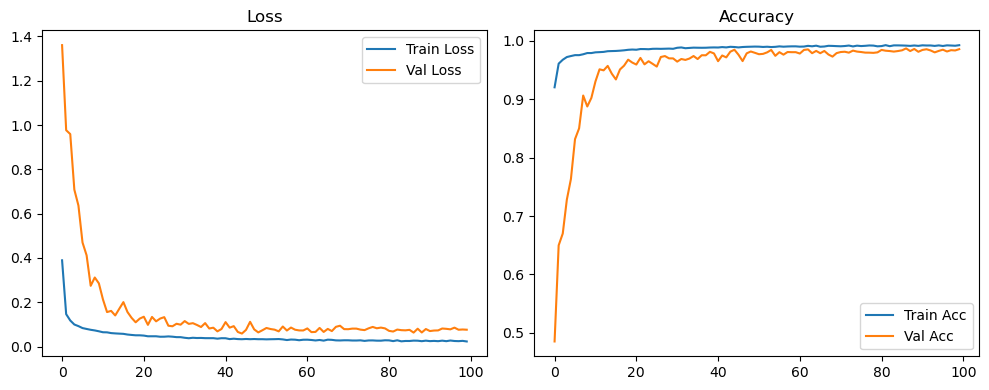

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1428, Acc: 0.9612 | Val Loss: 0.0781, Acc: 0.9752


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9860 | Val Loss: 0.0401, Acc: 0.9876


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0451, Acc: 0.9865


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0574, Acc: 0.9824


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0451, Acc: 0.9868


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0419, Acc: 0.9872


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0590, Acc: 0.9831


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0511, Acc: 0.9861


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0522, Acc: 0.9858


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0533, Acc: 0.9856


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0449, Acc: 0.9885


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0564, Acc: 0.9866


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0592, Acc: 0.9851


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0514, Acc: 0.9876


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0503, Acc: 0.9902


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0494, Acc: 0.9903


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0427, Acc: 0.9901


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0509, Acc: 0.9871


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9976 | Val Loss: 0.0728, Acc: 0.9840


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0470, Acc: 0.9899


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0562, Acc: 0.9888


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0626, Acc: 0.9865


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0481, Acc: 0.9892


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0425, Acc: 0.9917


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0430, Acc: 0.9898


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0384, Acc: 0.9912


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0543, Acc: 0.9884


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0847, Acc: 0.9817


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0576, Acc: 0.9872


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0453, Acc: 0.9908


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0534, Acc: 0.9895


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0589, Acc: 0.9876


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0508, Acc: 0.9899


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0546, Acc: 0.9887


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0457, Acc: 0.9908


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0449, Acc: 0.9914


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0444, Acc: 0.9923


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0444, Acc: 0.9913


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0875, Acc: 0.9851


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.0564, Acc: 0.9883


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0536, Acc: 0.9905


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0653, Acc: 0.9881


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0566, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0466, Acc: 0.9910


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0462, Acc: 0.9912


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0448, Acc: 0.9909


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0527, Acc: 0.9907


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0625, Acc: 0.9892


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0525, Acc: 0.9905


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0543, Acc: 0.9899


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0625, Acc: 0.9890


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0493, Acc: 0.9918


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0603, Acc: 0.9903


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9900


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0578, Acc: 0.9909


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0742, Acc: 0.9875


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0715, Acc: 0.9881


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0567, Acc: 0.9903


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.0681, Acc: 0.9881


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0573, Acc: 0.9904


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0514, Acc: 0.9902


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0546, Acc: 0.9913


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0644, Acc: 0.9893


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0798, Acc: 0.9872


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0684, Acc: 0.9886


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0668, Acc: 0.9883


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.0643, Acc: 0.9886


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0566, Acc: 0.9895


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0533, Acc: 0.9898


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0648, Acc: 0.9888


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0536, Acc: 0.9918


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0593, Acc: 0.9901


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0520, Acc: 0.9908


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0502, Acc: 0.9912


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9905


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9908


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0605, Acc: 0.9898


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0629, Acc: 0.9908


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0591, Acc: 0.9902


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0640, Acc: 0.9896


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0697, Acc: 0.9885


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0640, Acc: 0.9902


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0597, Acc: 0.9902


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0603, Acc: 0.9900


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0557, Acc: 0.9912


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0546, Acc: 0.9903


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9905


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0902, Acc: 0.9858


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0633, Acc: 0.9900


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0664, Acc: 0.9891


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0611, Acc: 0.9902


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0742, Acc: 0.9893


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0587, Acc: 0.9911


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0612, Acc: 0.9905


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0628, Acc: 0.9903


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0642, Acc: 0.9901


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0676, Acc: 0.9900


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0618, Acc: 0.9910


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0608, Acc: 0.9907


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0694, Acc: 0.9896


Final Test Loss: 0.0705 Accuracy: 0.9883


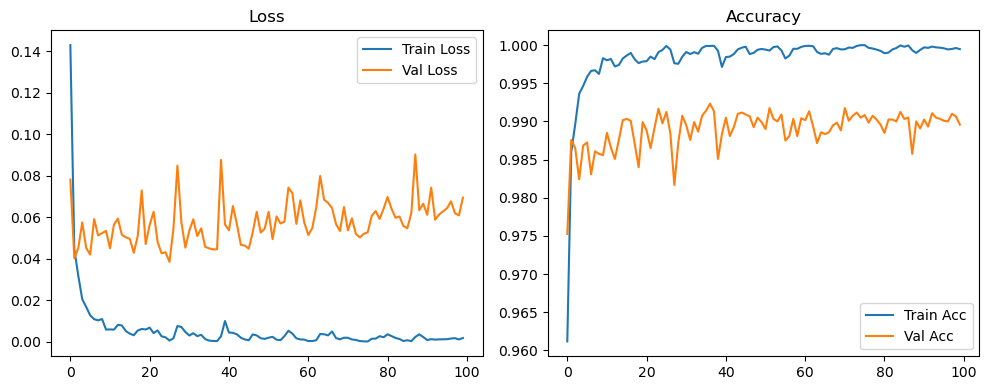

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1731, Acc: 0.9507 | Val Loss: 0.3879, Acc: 0.8719


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9792 | Val Loss: 0.0626, Acc: 0.9798


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9846 | Val Loss: 0.0531, Acc: 0.9830


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0601, Acc: 0.9812


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.0637, Acc: 0.9799


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.0744, Acc: 0.9761


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9907 | Val Loss: 0.0488, Acc: 0.9856


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0509, Acc: 0.9837


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.0405, Acc: 0.9874


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0548, Acc: 0.9835


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0384, Acc: 0.9891


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0354, Acc: 0.9899


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.0706, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.0380, Acc: 0.9892


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0457, Acc: 0.9864


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9951 | Val Loss: 0.0453, Acc: 0.9862


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0438, Acc: 0.9882


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0404, Acc: 0.9877


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0520, Acc: 0.9861


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0475, Acc: 0.9867


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0424, Acc: 0.9879


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.0399, Acc: 0.9895


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0497, Acc: 0.9868


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0498, Acc: 0.9877


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0508, Acc: 0.9867


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0406, Acc: 0.9890


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0457, Acc: 0.9876


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9963 | Val Loss: 0.0510, Acc: 0.9865


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0492, Acc: 0.9870


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0511, Acc: 0.9865


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0475, Acc: 0.9874


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0535, Acc: 0.9865


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0455, Acc: 0.9882


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0401, Acc: 0.9897


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0427, Acc: 0.9902


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0434, Acc: 0.9890


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0447, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0419, Acc: 0.9894


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0453, Acc: 0.9890


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.0418, Acc: 0.9887


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0418, Acc: 0.9895


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.0439, Acc: 0.9886


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0443, Acc: 0.9880


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0442, Acc: 0.9894


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0416, Acc: 0.9896


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0534, Acc: 0.9868


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0419, Acc: 0.9896


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0357, Acc: 0.9917


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0512, Acc: 0.9880


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0485, Acc: 0.9895


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0511, Acc: 0.9877


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0433, Acc: 0.9888


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0411, Acc: 0.9894


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0437, Acc: 0.9900


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0442, Acc: 0.9900


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0476, Acc: 0.9889


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0509, Acc: 0.9885


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0422, Acc: 0.9904


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0423, Acc: 0.9891


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0500, Acc: 0.9894


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0455, Acc: 0.9883


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9980 | Val Loss: 0.0510, Acc: 0.9876


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0597, Acc: 0.9855


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0433, Acc: 0.9890


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0539, Acc: 0.9882


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0470, Acc: 0.9881


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0462, Acc: 0.9898


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0601, Acc: 0.9845


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0410, Acc: 0.9902


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0441, Acc: 0.9893


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0423, Acc: 0.9902


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0436, Acc: 0.9898


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0566, Acc: 0.9875


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0435, Acc: 0.9908


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0403, Acc: 0.9911


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0505, Acc: 0.9882


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0442, Acc: 0.9902


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0406, Acc: 0.9907


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0425, Acc: 0.9898


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0570, Acc: 0.9882


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0414, Acc: 0.9904


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0544, Acc: 0.9877


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0441, Acc: 0.9904


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0431, Acc: 0.9908


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0406, Acc: 0.9904


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0415, Acc: 0.9911


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0476, Acc: 0.9895


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0470, Acc: 0.9912


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0592, Acc: 0.9872


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0515, Acc: 0.9892


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0536, Acc: 0.9883


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0491, Acc: 0.9892


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0436, Acc: 0.9899


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0516, Acc: 0.9888


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0429, Acc: 0.9902


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0452, Acc: 0.9899


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0433, Acc: 0.9903


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0460, Acc: 0.9899


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0450, Acc: 0.9906


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0484, Acc: 0.9891


Final Test Loss: 0.0504 Accuracy: 0.9887


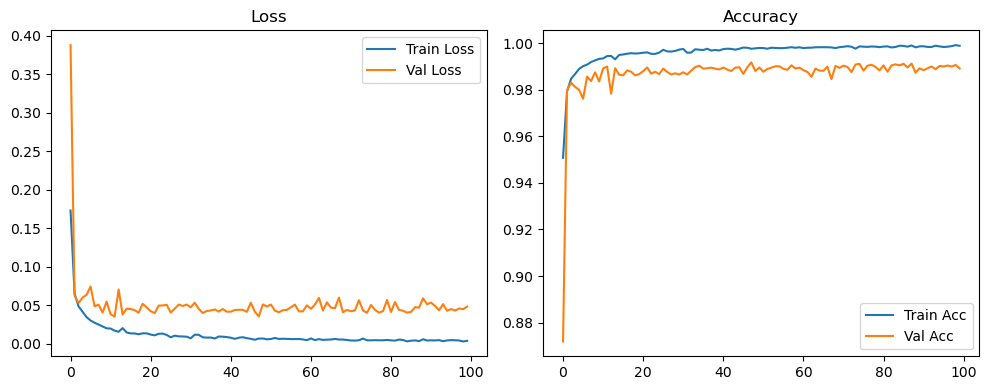

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2782, Acc: 0.9197 | Val Loss: 2.1086, Acc: 0.3633


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1308, Acc: 0.9613 | Val Loss: 0.8518, Acc: 0.6978


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9669 | Val Loss: 0.6499, Acc: 0.7669


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9727 | Val Loss: 0.3493, Acc: 0.8788


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9739 | Val Loss: 0.3480, Acc: 0.8800


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9753 | Val Loss: 0.1981, Acc: 0.9422


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9780 | Val Loss: 0.1418, Acc: 0.9567


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9776 | Val Loss: 0.2172, Acc: 0.9311


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9786 | Val Loss: 0.1977, Acc: 0.9368


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9793 | Val Loss: 0.1670, Acc: 0.9461


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9808 | Val Loss: 0.2308, Acc: 0.9255


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9809 | Val Loss: 0.1723, Acc: 0.9453


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9815 | Val Loss: 0.1107, Acc: 0.9653


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9821 | Val Loss: 0.1091, Acc: 0.9682


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9822 | Val Loss: 0.1424, Acc: 0.9571


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9832 | Val Loss: 0.1629, Acc: 0.9483


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9836 | Val Loss: 0.2344, Acc: 0.9253


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9835 | Val Loss: 0.0953, Acc: 0.9720


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9835 | Val Loss: 0.1195, Acc: 0.9620


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9828 | Val Loss: 0.1010, Acc: 0.9688


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9841 | Val Loss: 0.1195, Acc: 0.9631


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9846 | Val Loss: 0.1954, Acc: 0.9403


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.0909, Acc: 0.9704


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9847 | Val Loss: 0.1022, Acc: 0.9668


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9846 | Val Loss: 0.1023, Acc: 0.9683


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9846 | Val Loss: 0.1254, Acc: 0.9617


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.0972, Acc: 0.9710


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9854 | Val Loss: 0.0885, Acc: 0.9760


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9863 | Val Loss: 0.0831, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9856 | Val Loss: 0.0793, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.0797, Acc: 0.9769


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.0915, Acc: 0.9703


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9871 | Val Loss: 0.0851, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.0665, Acc: 0.9825


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.0751, Acc: 0.9773


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9865 | Val Loss: 0.0859, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0698, Acc: 0.9820


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 0.0819, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9873 | Val Loss: 0.0738, Acc: 0.9793


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0945, Acc: 0.9710


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.0661, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.0755, Acc: 0.9771


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.0784, Acc: 0.9752


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.0789, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.0561, Acc: 0.9834


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.0797, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9883 | Val Loss: 0.0702, Acc: 0.9802


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.0569, Acc: 0.9835


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 0.0919, Acc: 0.9718


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9883 | Val Loss: 0.0774, Acc: 0.9762


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0531, Acc: 0.9842


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0748, Acc: 0.9788


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9888 | Val Loss: 0.0671, Acc: 0.9822


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9891 | Val Loss: 0.0563, Acc: 0.9837


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9885 | Val Loss: 0.0938, Acc: 0.9692


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0621, Acc: 0.9823


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.0661, Acc: 0.9812


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9898 | Val Loss: 0.0580, Acc: 0.9838


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0670, Acc: 0.9818


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.0791, Acc: 0.9774


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0811, Acc: 0.9748


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9903 | Val Loss: 0.0507, Acc: 0.9855


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.0618, Acc: 0.9820


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0683, Acc: 0.9815


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0614, Acc: 0.9842


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9893 | Val Loss: 0.0468, Acc: 0.9880


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.0649, Acc: 0.9832


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.0596, Acc: 0.9833


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.0831, Acc: 0.9759


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.0515, Acc: 0.9862


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.0650, Acc: 0.9813


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.0655, Acc: 0.9802


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0566, Acc: 0.9837


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.0563, Acc: 0.9836


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0682, Acc: 0.9809


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.0557, Acc: 0.9859


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0587, Acc: 0.9828


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.0552, Acc: 0.9832


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9906 | Val Loss: 0.0679, Acc: 0.9795


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9901 | Val Loss: 0.0568, Acc: 0.9844


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0533, Acc: 0.9854


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9898 | Val Loss: 0.0587, Acc: 0.9844


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9906 | Val Loss: 0.0565, Acc: 0.9846


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0522, Acc: 0.9863


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0720, Acc: 0.9795


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0673, Acc: 0.9794


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.0540, Acc: 0.9853


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0684, Acc: 0.9802


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0497, Acc: 0.9872


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0683, Acc: 0.9824


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9912 | Val Loss: 0.0468, Acc: 0.9874


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0542, Acc: 0.9852


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0636, Acc: 0.9819


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9909 | Val Loss: 0.0721, Acc: 0.9807


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.0664, Acc: 0.9806


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0570, Acc: 0.9848


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0544, Acc: 0.9884


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.0697, Acc: 0.9818


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9913 | Val Loss: 0.0670, Acc: 0.9815


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.0577, Acc: 0.9846


Final Test Loss: 0.0532 Accuracy: 0.9846


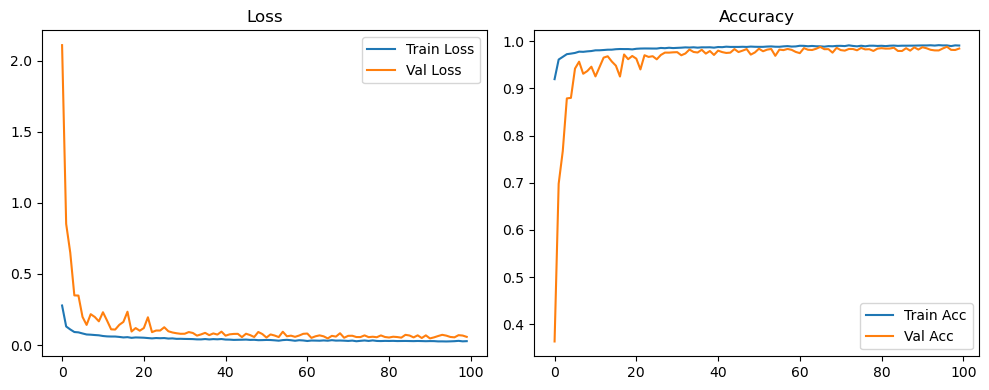

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1423, Acc: 0.9606 | Val Loss: 0.0892, Acc: 0.9723


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0498, Acc: 0.9837


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0430, Acc: 0.9883


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0526, Acc: 0.9840


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0528, Acc: 0.9848


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0487, Acc: 0.9867


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0413, Acc: 0.9879


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0459, Acc: 0.9883


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0603, Acc: 0.9825


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0495, Acc: 0.9854


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0449, Acc: 0.9880


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0456, Acc: 0.9884


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0462, Acc: 0.9889


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0672, Acc: 0.9863


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0550, Acc: 0.9876


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0474, Acc: 0.9890


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0470, Acc: 0.9882


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0567, Acc: 0.9868


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9975 | Val Loss: 0.0589, Acc: 0.9874


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0414, Acc: 0.9897


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0511, Acc: 0.9895


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0583, Acc: 0.9880


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0511, Acc: 0.9878


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0499, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0533, Acc: 0.9888


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0465, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0537, Acc: 0.9893


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0633, Acc: 0.9882


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0678, Acc: 0.9865


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0615, Acc: 0.9872


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0490, Acc: 0.9907


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0583, Acc: 0.9887


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0724, Acc: 0.9873


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0569, Acc: 0.9891


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0498, Acc: 0.9894


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0478, Acc: 0.9908


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0424, Acc: 0.9922


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0423, Acc: 0.9918


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0449, Acc: 0.9924


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0636, Acc: 0.9886


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0712, Acc: 0.9872


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0656, Acc: 0.9877


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0530, Acc: 0.9901


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0469, Acc: 0.9911


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0443, Acc: 0.9915


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0476, Acc: 0.9916


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0459, Acc: 0.9918


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0485, Acc: 0.9917


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0652, Acc: 0.9881


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0530, Acc: 0.9902


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0489, Acc: 0.9914


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0450, Acc: 0.9920


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9918


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9919


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9925


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9924


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9927


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9920


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9925


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9926


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9928


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9925


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9925


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9930


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9928


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9932


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9931


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9932


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9931


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9928


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9924


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9931


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9924


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9930


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9928


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9929


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9928


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9930


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9929


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9930


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9931


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9931


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9928


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9929


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9928


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9929


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9932


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9930


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9928


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9926


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9929


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9929


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9935


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9929


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9934


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9934


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9932


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9932


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9932


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9931


Final Test Loss: 0.0514 Accuracy: 0.9915


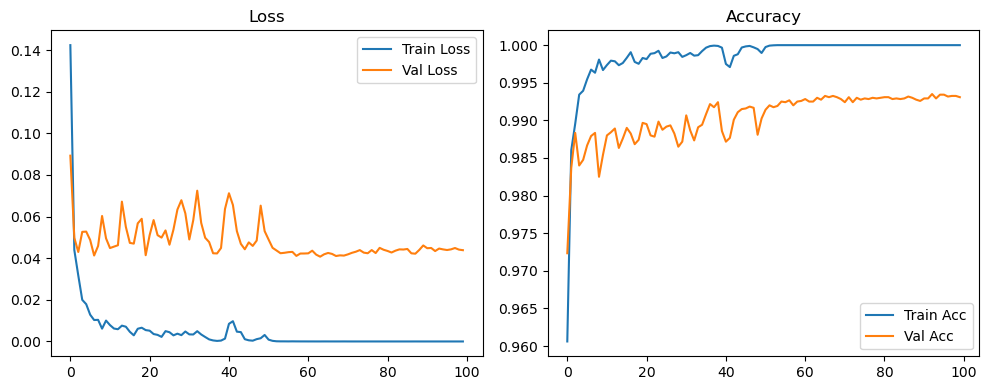

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1738, Acc: 0.9506 | Val Loss: 0.3266, Acc: 0.8958


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9801 | Val Loss: 0.0621, Acc: 0.9802


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9838 | Val Loss: 0.0765, Acc: 0.9764


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.0518, Acc: 0.9852


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.0570, Acc: 0.9819


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0582, Acc: 0.9808


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0454, Acc: 0.9858


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.0441, Acc: 0.9863


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0403, Acc: 0.9875


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.0514, Acc: 0.9848


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0472, Acc: 0.9864


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0463, Acc: 0.9870


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0512, Acc: 0.9848


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0389, Acc: 0.9889


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0388, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0631, Acc: 0.9827


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.0526, Acc: 0.9860


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0495, Acc: 0.9862


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0427, Acc: 0.9882


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0488, Acc: 0.9873


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9950 | Val Loss: 0.0630, Acc: 0.9815


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0624, Acc: 0.9832


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0461, Acc: 0.9872


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0617, Acc: 0.9839


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0383, Acc: 0.9893


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0411, Acc: 0.9887


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0516, Acc: 0.9858


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0467, Acc: 0.9878


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0464, Acc: 0.9872


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.0438, Acc: 0.9879


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0487, Acc: 0.9873


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0494, Acc: 0.9871


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0351, Acc: 0.9904


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0494, Acc: 0.9878


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0510, Acc: 0.9881


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0535, Acc: 0.9881


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0514, Acc: 0.9861


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0509, Acc: 0.9877


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0450, Acc: 0.9888


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0507, Acc: 0.9870


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0521, Acc: 0.9887


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0545, Acc: 0.9878


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0522, Acc: 0.9876


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0514, Acc: 0.9877


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0529, Acc: 0.9879


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0468, Acc: 0.9890


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0451, Acc: 0.9892


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0540, Acc: 0.9870


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0489, Acc: 0.9882


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0545, Acc: 0.9865


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0455, Acc: 0.9883


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0426, Acc: 0.9898


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0435, Acc: 0.9898


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0374, Acc: 0.9912


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0390, Acc: 0.9912


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0421, Acc: 0.9902


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0445, Acc: 0.9902


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0454, Acc: 0.9891


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0441, Acc: 0.9893


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0457, Acc: 0.9900


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0449, Acc: 0.9908


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0429, Acc: 0.9892


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0476, Acc: 0.9889


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0403, Acc: 0.9908


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0512, Acc: 0.9888


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0484, Acc: 0.9897


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0467, Acc: 0.9906


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0512, Acc: 0.9892


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0554, Acc: 0.9880


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0428, Acc: 0.9909


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9903


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0440, Acc: 0.9905


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0488, Acc: 0.9896


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0532, Acc: 0.9886


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0518, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0488, Acc: 0.9895


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0512, Acc: 0.9893


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0534, Acc: 0.9881


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0528, Acc: 0.9888


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0502, Acc: 0.9894


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0474, Acc: 0.9905


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0442, Acc: 0.9912


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0461, Acc: 0.9916


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0440, Acc: 0.9911


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0414, Acc: 0.9918


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0438, Acc: 0.9913


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0415, Acc: 0.9917


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0508, Acc: 0.9902


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0488, Acc: 0.9905


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0471, Acc: 0.9914


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0485, Acc: 0.9908


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0468, Acc: 0.9916


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0472, Acc: 0.9905


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0489, Acc: 0.9907


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0482, Acc: 0.9908


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0465, Acc: 0.9906


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0476, Acc: 0.9906


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0477, Acc: 0.9911


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0461, Acc: 0.9908


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0454, Acc: 0.9909


Final Test Loss: 0.0468 Accuracy: 0.9894


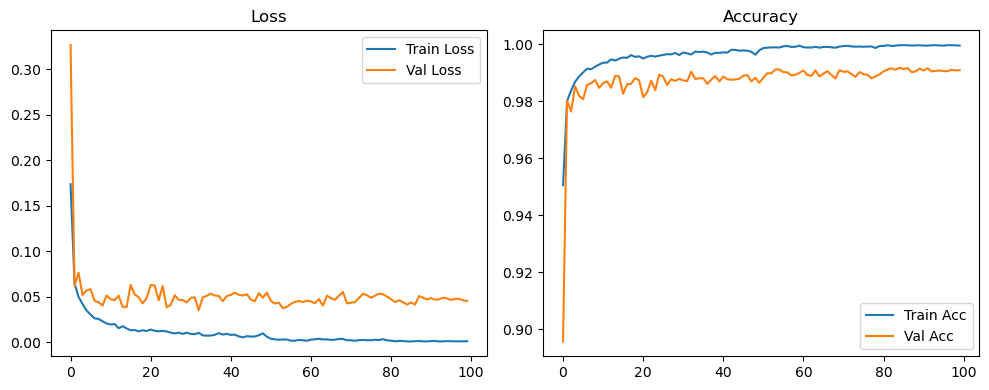

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2780, Acc: 0.9202 | Val Loss: 1.6767, Acc: 0.4597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1309, Acc: 0.9602 | Val Loss: 0.6786, Acc: 0.7703


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1092, Acc: 0.9678 | Val Loss: 0.6807, Acc: 0.7578


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9726 | Val Loss: 0.3451, Acc: 0.8821


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9737 | Val Loss: 0.3585, Acc: 0.8762


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9746 | Val Loss: 0.1939, Acc: 0.9428


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9784 | Val Loss: 0.1221, Acc: 0.9672


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9771 | Val Loss: 0.2509, Acc: 0.9198


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9789 | Val Loss: 0.2012, Acc: 0.9375


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9796 | Val Loss: 0.1922, Acc: 0.9397


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9799 | Val Loss: 0.1536, Acc: 0.9540


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9808 | Val Loss: 0.1425, Acc: 0.9553


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9812 | Val Loss: 0.1474, Acc: 0.9560


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9814 | Val Loss: 0.1101, Acc: 0.9681


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9823 | Val Loss: 0.1301, Acc: 0.9613


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9831 | Val Loss: 0.1445, Acc: 0.9551


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9834 | Val Loss: 0.1259, Acc: 0.9627


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9835 | Val Loss: 0.1315, Acc: 0.9589


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9835 | Val Loss: 0.1210, Acc: 0.9603


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9834 | Val Loss: 0.1013, Acc: 0.9710


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9840 | Val Loss: 0.0935, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.2818, Acc: 0.9050


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9852 | Val Loss: 0.0846, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9849 | Val Loss: 0.1091, Acc: 0.9669


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9847 | Val Loss: 0.1135, Acc: 0.9673


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9845 | Val Loss: 0.0667, Acc: 0.9794


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.0740, Acc: 0.9788


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9860 | Val Loss: 0.0986, Acc: 0.9732


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.0973, Acc: 0.9717


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9863 | Val Loss: 0.0749, Acc: 0.9787


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9857 | Val Loss: 0.0791, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 0.0853, Acc: 0.9743


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.0573, Acc: 0.9822


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.0546, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9867 | Val Loss: 0.0631, Acc: 0.9811


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9874 | Val Loss: 0.0745, Acc: 0.9768


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 0.0696, Acc: 0.9795


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9877 | Val Loss: 0.0805, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9867 | Val Loss: 0.0631, Acc: 0.9820


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.0904, Acc: 0.9717


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0568, Acc: 0.9844


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.0553, Acc: 0.9846


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.0562, Acc: 0.9851


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9872 | Val Loss: 0.0678, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0551, Acc: 0.9854


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9888 | Val Loss: 0.0633, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9883 | Val Loss: 0.0745, Acc: 0.9773


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.0543, Acc: 0.9850


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9879 | Val Loss: 0.0777, Acc: 0.9767


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.0541, Acc: 0.9851


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0514, Acc: 0.9857


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0615, Acc: 0.9828


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.0615, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9911 | Val Loss: 0.0542, Acc: 0.9835


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0554, Acc: 0.9833


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9903 | Val Loss: 0.0613, Acc: 0.9822


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0498, Acc: 0.9860


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9911 | Val Loss: 0.0587, Acc: 0.9831


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.0607, Acc: 0.9837


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9915 | Val Loss: 0.0526, Acc: 0.9856


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.0621, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.0563, Acc: 0.9827


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.0475, Acc: 0.9866


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.0537, Acc: 0.9850


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0579, Acc: 0.9842


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.0475, Acc: 0.9864


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.0528, Acc: 0.9872


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0550, Acc: 0.9847


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0596, Acc: 0.9829


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.0453, Acc: 0.9878


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0568, Acc: 0.9833


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.0547, Acc: 0.9843


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.0534, Acc: 0.9852


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0528, Acc: 0.9846


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0525, Acc: 0.9854


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.0499, Acc: 0.9865


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0554, Acc: 0.9853


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0511, Acc: 0.9862


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9921 | Val Loss: 0.0509, Acc: 0.9870


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0565, Acc: 0.9852


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9923 | Val Loss: 0.0508, Acc: 0.9859


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0437, Acc: 0.9875


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0479, Acc: 0.9868


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0442, Acc: 0.9870


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9934 | Val Loss: 0.0484, Acc: 0.9871


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0477, Acc: 0.9869


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0437, Acc: 0.9880


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0459, Acc: 0.9875


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9934 | Val Loss: 0.0419, Acc: 0.9881


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0489, Acc: 0.9873


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0518, Acc: 0.9862


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0487, Acc: 0.9869


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0491, Acc: 0.9862


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0434, Acc: 0.9887


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0473, Acc: 0.9872


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0463, Acc: 0.9878


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0460, Acc: 0.9872


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9931 | Val Loss: 0.0449, Acc: 0.9880


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0461, Acc: 0.9878


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0420, Acc: 0.9884


Final Test Loss: 0.0362 Accuracy: 0.9897


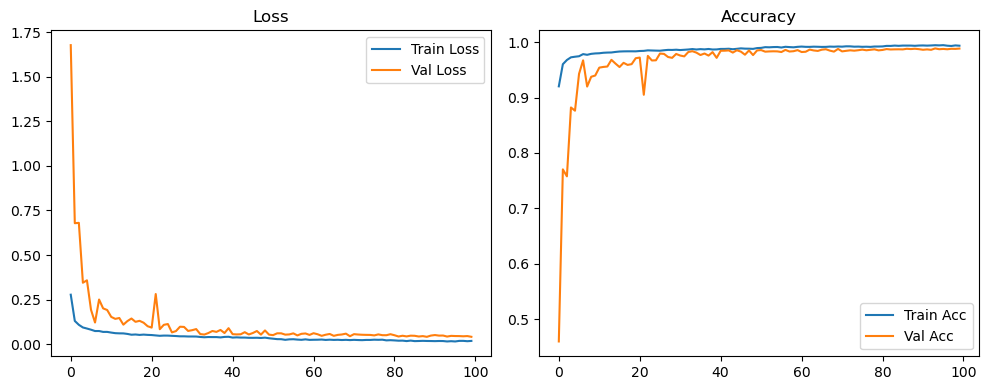

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9603 | Val Loss: 0.0801, Acc: 0.9748


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9864 | Val Loss: 0.0389, Acc: 0.9879


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0414, Acc: 0.9879


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0473, Acc: 0.9862


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.0441, Acc: 0.9874


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0417, Acc: 0.9886


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0459, Acc: 0.9884


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.0473, Acc: 0.9870


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0593, Acc: 0.9833


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0500, Acc: 0.9878


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0530, Acc: 0.9858


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0543, Acc: 0.9872


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0525, Acc: 0.9871


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0589, Acc: 0.9861


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0514, Acc: 0.9886


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0375, Acc: 0.9915


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0448, Acc: 0.9902


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0473, Acc: 0.9890


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0522, Acc: 0.9893


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0532, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0503, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0737, Acc: 0.9842


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0399, Acc: 0.9902


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0504, Acc: 0.9891


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0464, Acc: 0.9904


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0411, Acc: 0.9914


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0432, Acc: 0.9910


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0450, Acc: 0.9918


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0467, Acc: 0.9913


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0800, Acc: 0.9817


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0691, Acc: 0.9851


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0578, Acc: 0.9877


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0522, Acc: 0.9881


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0520, Acc: 0.9899


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0567, Acc: 0.9879


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0583, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0632, Acc: 0.9882


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0583, Acc: 0.9883


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0553, Acc: 0.9905


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0541, Acc: 0.9899


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0478, Acc: 0.9911


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0490, Acc: 0.9909


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0524, Acc: 0.9897


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0575, Acc: 0.9908


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0536, Acc: 0.9889


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0622, Acc: 0.9886


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0558, Acc: 0.9896


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0694, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0496, Acc: 0.9912


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0509, Acc: 0.9905


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9920


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9922


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9927


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9923


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9924


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9923


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9922


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9920


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9927


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9924


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9926


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9922


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9927


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9927


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9929


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9930


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9928


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9925


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9928


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9932


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9935


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9933


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9933


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9930


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9934


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0702, Acc: 0.9893


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.0588, Acc: 0.9900


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0603, Acc: 0.9898


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0555, Acc: 0.9912


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9914


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9914


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9914


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9913


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9917


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9917


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9913


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9917


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9914


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9912


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9915


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9913


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9919


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9918


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9914


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9918


Final Test Loss: 0.0497 Accuracy: 0.9922


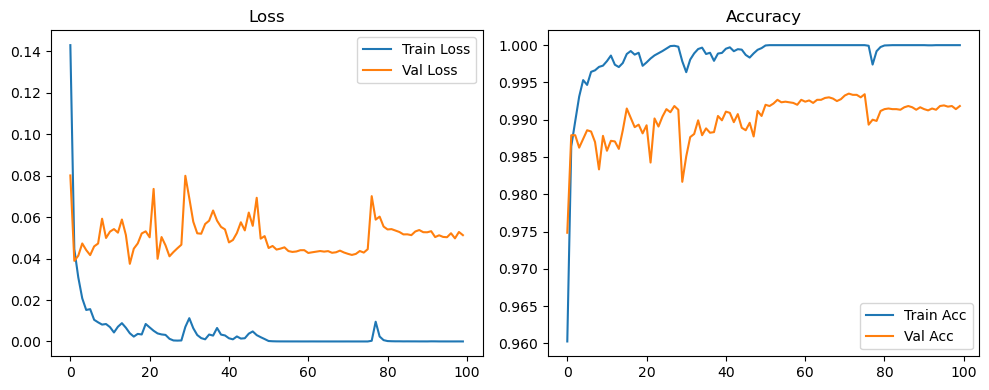

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1736, Acc: 0.9508 | Val Loss: 0.4054, Acc: 0.8642


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9799 | Val Loss: 0.0527, Acc: 0.9840


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9841 | Val Loss: 0.0744, Acc: 0.9758


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.0556, Acc: 0.9828


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0418, Acc: 0.9862


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0430, Acc: 0.9876


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.0485, Acc: 0.9846


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.0461, Acc: 0.9862


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.0362, Acc: 0.9897


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0477, Acc: 0.9856


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9929 | Val Loss: 0.0355, Acc: 0.9899


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9932 | Val Loss: 0.0536, Acc: 0.9836


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0487, Acc: 0.9867


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0447, Acc: 0.9872


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.0469, Acc: 0.9862


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0513, Acc: 0.9848


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0473, Acc: 0.9872


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0481, Acc: 0.9855


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0521, Acc: 0.9856


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0570, Acc: 0.9852


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0451, Acc: 0.9871


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0615, Acc: 0.9831


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0391, Acc: 0.9886


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0502, Acc: 0.9864


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.0510, Acc: 0.9875


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0400, Acc: 0.9888


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0425, Acc: 0.9898


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0462, Acc: 0.9873


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0442, Acc: 0.9886


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0356, Acc: 0.9908


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0485, Acc: 0.9878


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0405, Acc: 0.9888


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0419, Acc: 0.9897


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0489, Acc: 0.9882


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.0433, Acc: 0.9892


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.0361, Acc: 0.9907


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0378, Acc: 0.9900


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0483, Acc: 0.9885


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0389, Acc: 0.9900


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0424, Acc: 0.9881


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0450, Acc: 0.9885


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9973 | Val Loss: 0.0441, Acc: 0.9898


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0463, Acc: 0.9880


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0482, Acc: 0.9890


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0406, Acc: 0.9902


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0401, Acc: 0.9906


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0416, Acc: 0.9890


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0418, Acc: 0.9905


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0459, Acc: 0.9893


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0483, Acc: 0.9888


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0411, Acc: 0.9908


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0394, Acc: 0.9909


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0438, Acc: 0.9897


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0373, Acc: 0.9915


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0418, Acc: 0.9909


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0403, Acc: 0.9912


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0411, Acc: 0.9902


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0428, Acc: 0.9898


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0416, Acc: 0.9910


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0440, Acc: 0.9914


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0442, Acc: 0.9907


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0451, Acc: 0.9911


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0429, Acc: 0.9909


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0391, Acc: 0.9908


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0393, Acc: 0.9914


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0401, Acc: 0.9912


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0438, Acc: 0.9905


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0503, Acc: 0.9890


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0423, Acc: 0.9912


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0490, Acc: 0.9889


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0421, Acc: 0.9914


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0417, Acc: 0.9912


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0514, Acc: 0.9895


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0496, Acc: 0.9902


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0506, Acc: 0.9908


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0427, Acc: 0.9920


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0447, Acc: 0.9899


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0418, Acc: 0.9918


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0417, Acc: 0.9920


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0497, Acc: 0.9894


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0447, Acc: 0.9907


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0434, Acc: 0.9913


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0424, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0408, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0404, Acc: 0.9919


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0422, Acc: 0.9918


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0403, Acc: 0.9919


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0416, Acc: 0.9917


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0378, Acc: 0.9926


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0397, Acc: 0.9923


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0397, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0404, Acc: 0.9919


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0410, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0396, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0411, Acc: 0.9915


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0400, Acc: 0.9920


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0379, Acc: 0.9921


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0404, Acc: 0.9920


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0393, Acc: 0.9925


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0386, Acc: 0.9924


Final Test Loss: 0.0364 Accuracy: 0.9912


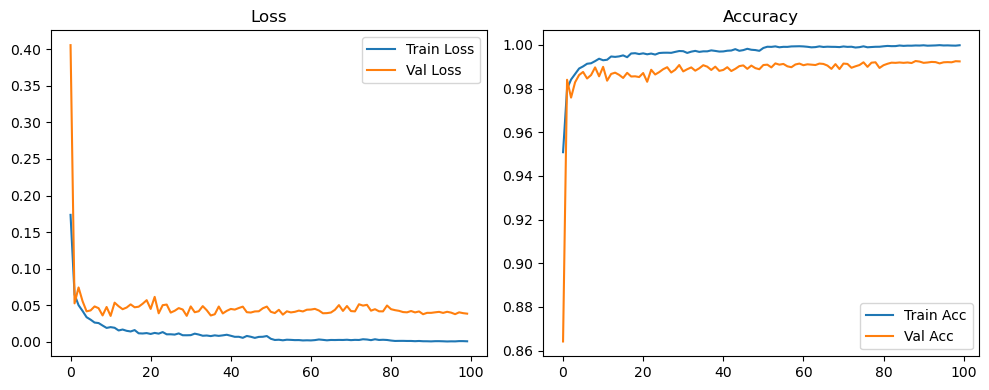

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2777, Acc: 0.9198 | Val Loss: 1.4032, Acc: 0.5182


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1314, Acc: 0.9603 | Val Loss: 0.5076, Acc: 0.8318


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1092, Acc: 0.9680 | Val Loss: 0.7960, Acc: 0.7119


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9723 | Val Loss: 0.4223, Acc: 0.8472


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9741 | Val Loss: 0.4290, Acc: 0.8575


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0835, Acc: 0.9745 | Val Loss: 0.2224, Acc: 0.9317


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9782 | Val Loss: 0.1611, Acc: 0.9531


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9782 | Val Loss: 0.2849, Acc: 0.9081


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9805 | Val Loss: 0.2471, Acc: 0.9174


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9801 | Val Loss: 0.2524, Acc: 0.9188


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9805 | Val Loss: 0.1410, Acc: 0.9570


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9803 | Val Loss: 0.1581, Acc: 0.9527


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9812 | Val Loss: 0.1846, Acc: 0.9403


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9824 | Val Loss: 0.1233, Acc: 0.9631


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9823 | Val Loss: 0.1385, Acc: 0.9570


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9830 | Val Loss: 0.2736, Acc: 0.9127


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9830 | Val Loss: 0.1182, Acc: 0.9627


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9846 | Val Loss: 0.1142, Acc: 0.9628


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9839 | Val Loss: 0.1118, Acc: 0.9646


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9829 | Val Loss: 0.0876, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9838 | Val Loss: 0.1060, Acc: 0.9653


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9835 | Val Loss: 0.1490, Acc: 0.9518


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 0.0883, Acc: 0.9732


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9845 | Val Loss: 0.0819, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9847 | Val Loss: 0.0802, Acc: 0.9762


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9846 | Val Loss: 0.1082, Acc: 0.9662


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.0967, Acc: 0.9713


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9855 | Val Loss: 0.0875, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9865 | Val Loss: 0.1398, Acc: 0.9564


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9861 | Val Loss: 0.0884, Acc: 0.9711


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9858 | Val Loss: 0.1062, Acc: 0.9659


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9863 | Val Loss: 0.0936, Acc: 0.9721


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0757, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 0.1003, Acc: 0.9672


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 0.1113, Acc: 0.9672


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9860 | Val Loss: 0.0746, Acc: 0.9781


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0864, Acc: 0.9734


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.0908, Acc: 0.9708


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9869 | Val Loss: 0.0769, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9870 | Val Loss: 0.1025, Acc: 0.9675


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 0.0864, Acc: 0.9742


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9877 | Val Loss: 0.0927, Acc: 0.9713


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9875 | Val Loss: 0.0714, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9886 | Val Loss: 0.0817, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0772, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9877 | Val Loss: 0.0667, Acc: 0.9818


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9879 | Val Loss: 0.0809, Acc: 0.9751


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9876 | Val Loss: 0.0655, Acc: 0.9804


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0629, Acc: 0.9818


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.0812, Acc: 0.9752


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.0703, Acc: 0.9780


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.0763, Acc: 0.9764


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0656, Acc: 0.9800


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0562, Acc: 0.9843


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0588, Acc: 0.9825


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0671, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0764, Acc: 0.9761


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.0740, Acc: 0.9757


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0710, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.0653, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9916 | Val Loss: 0.0698, Acc: 0.9790


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.0578, Acc: 0.9816


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.0528, Acc: 0.9848


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0507, Acc: 0.9856


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.0614, Acc: 0.9818


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0592, Acc: 0.9823


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9910 | Val Loss: 0.0621, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0698, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9912 | Val Loss: 0.0702, Acc: 0.9777


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.0571, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.0579, Acc: 0.9822


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9913 | Val Loss: 0.0550, Acc: 0.9836


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0549, Acc: 0.9838


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0598, Acc: 0.9821


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0586, Acc: 0.9828


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0507, Acc: 0.9847


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0570, Acc: 0.9822


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.0536, Acc: 0.9842


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0568, Acc: 0.9831


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.0508, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0501, Acc: 0.9858


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0499, Acc: 0.9852


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.0508, Acc: 0.9853


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.0479, Acc: 0.9865


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0489, Acc: 0.9859


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0541, Acc: 0.9843


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0480, Acc: 0.9862


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0508, Acc: 0.9862


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0490, Acc: 0.9860


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0495, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0499, Acc: 0.9851


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0479, Acc: 0.9862


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.0495, Acc: 0.9860


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0519, Acc: 0.9845


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0478, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0482, Acc: 0.9857


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9936 | Val Loss: 0.0440, Acc: 0.9877


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.0464, Acc: 0.9870


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0440, Acc: 0.9872


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0448, Acc: 0.9872


Final Test Loss: 0.0427 Accuracy: 0.9862


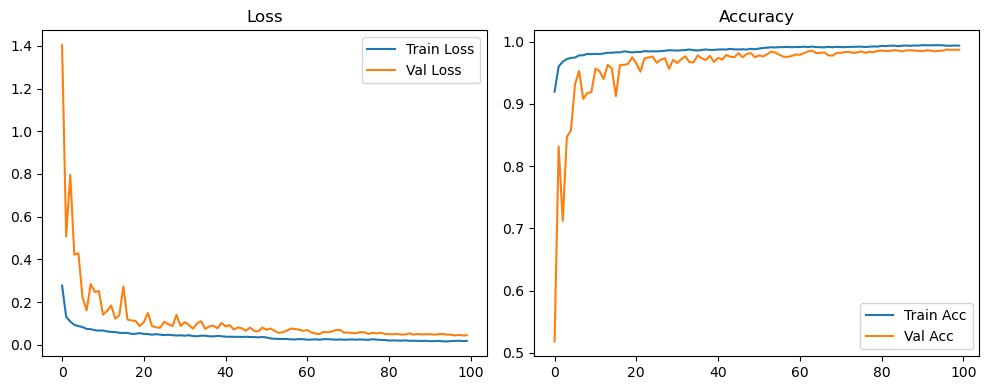

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9606 | Val Loss: 0.0743, Acc: 0.9767


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9858 | Val Loss: 0.0553, Acc: 0.9828


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.0409, Acc: 0.9878


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.0484, Acc: 0.9848


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0497, Acc: 0.9849


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0471, Acc: 0.9855


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0409, Acc: 0.9877


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.0390, Acc: 0.9890


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0611, Acc: 0.9825


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0393, Acc: 0.9888


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0446, Acc: 0.9878


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0927, Acc: 0.9770


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0506, Acc: 0.9888


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.0505, Acc: 0.9882


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0672, Acc: 0.9844


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0516, Acc: 0.9883


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0574, Acc: 0.9870


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0468, Acc: 0.9896


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0408, Acc: 0.9914


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0482, Acc: 0.9891


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0653, Acc: 0.9853


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0447, Acc: 0.9898


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0453, Acc: 0.9898


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0436, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0459, Acc: 0.9888


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0499, Acc: 0.9898


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0546, Acc: 0.9880


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0541, Acc: 0.9886


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0643, Acc: 0.9850


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0425, Acc: 0.9896


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0536, Acc: 0.9877


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0466, Acc: 0.9917


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0496, Acc: 0.9902


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0517, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0570, Acc: 0.9888


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0518, Acc: 0.9898


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0628, Acc: 0.9879


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0551, Acc: 0.9894


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0534, Acc: 0.9898


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0497, Acc: 0.9905


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0552, Acc: 0.9890


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0558, Acc: 0.9896


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0548, Acc: 0.9898


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0550, Acc: 0.9905


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0426, Acc: 0.9915


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9917


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0500, Acc: 0.9908


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0800, Acc: 0.9852


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.0597, Acc: 0.9880


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0512, Acc: 0.9905


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0484, Acc: 0.9914


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9911


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9913


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9916


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9918


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9915


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9921


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9921


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9916


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9916


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9919


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9917


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9916


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9921


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9917


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9923


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9922


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9925


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9923


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9921


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9915


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9917


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9918


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9920


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9917


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9919


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9916


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9919


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9921


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9921


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9916


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9920


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9918


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9921


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9924


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9926


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9918


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9920


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9919


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9920


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9921


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9922


Final Test Loss: 0.0550 Accuracy: 0.9908


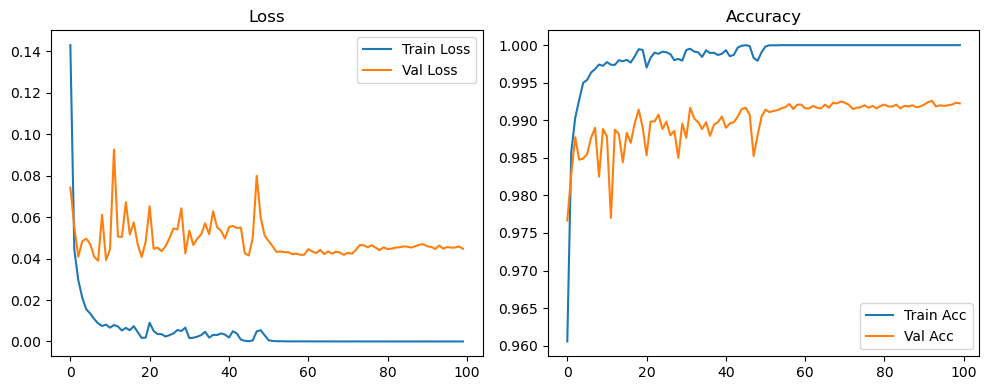

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1741, Acc: 0.9511 | Val Loss: 0.3380, Acc: 0.8907


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9800 | Val Loss: 0.0604, Acc: 0.9805


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9840 | Val Loss: 0.0919, Acc: 0.9712


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.0585, Acc: 0.9814


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9892 | Val Loss: 0.0675, Acc: 0.9784


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0477, Acc: 0.9858


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0507, Acc: 0.9852


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.0425, Acc: 0.9871


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0435, Acc: 0.9876


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0492, Acc: 0.9855


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0386, Acc: 0.9893


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.0684, Acc: 0.9799


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0601, Acc: 0.9836


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0456, Acc: 0.9867


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.0406, Acc: 0.9882


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0602, Acc: 0.9823


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0402, Acc: 0.9883


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9955 | Val Loss: 0.0505, Acc: 0.9861


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0511, Acc: 0.9860


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0426, Acc: 0.9886


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0361, Acc: 0.9900


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0490, Acc: 0.9882


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0629, Acc: 0.9845


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0510, Acc: 0.9872


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0439, Acc: 0.9885


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0449, Acc: 0.9881


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0557, Acc: 0.9838


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0560, Acc: 0.9868


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0529, Acc: 0.9866


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.0479, Acc: 0.9875


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0609, Acc: 0.9861


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0610, Acc: 0.9855


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0585, Acc: 0.9853


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0633, Acc: 0.9847


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0453, Acc: 0.9901


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0450, Acc: 0.9887


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0514, Acc: 0.9881


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0450, Acc: 0.9890


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0602, Acc: 0.9843


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0477, Acc: 0.9884


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0481, Acc: 0.9880


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0417, Acc: 0.9901


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0613, Acc: 0.9858


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0574, Acc: 0.9874


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0400, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0488, Acc: 0.9884


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0576, Acc: 0.9864


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0471, Acc: 0.9891


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9972 | Val Loss: 0.0494, Acc: 0.9887


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0476, Acc: 0.9889


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0472, Acc: 0.9897


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0514, Acc: 0.9897


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0438, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0490, Acc: 0.9886


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0460, Acc: 0.9894


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0443, Acc: 0.9909


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0464, Acc: 0.9899


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0468, Acc: 0.9904


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0477, Acc: 0.9898


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0476, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0466, Acc: 0.9904


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0500, Acc: 0.9890


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0436, Acc: 0.9908


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0440, Acc: 0.9916


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0482, Acc: 0.9903


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0460, Acc: 0.9903


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0450, Acc: 0.9908


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0468, Acc: 0.9903


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0482, Acc: 0.9908


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0433, Acc: 0.9918


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0483, Acc: 0.9902


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0501, Acc: 0.9898


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0487, Acc: 0.9909


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0475, Acc: 0.9902


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0532, Acc: 0.9899


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0481, Acc: 0.9908


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0484, Acc: 0.9903


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0468, Acc: 0.9904


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0495, Acc: 0.9911


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0468, Acc: 0.9910


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0452, Acc: 0.9919


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0433, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0456, Acc: 0.9919


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0449, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0448, Acc: 0.9916


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0481, Acc: 0.9915


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0474, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0477, Acc: 0.9914


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0466, Acc: 0.9914


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0449, Acc: 0.9913


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0484, Acc: 0.9913


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0493, Acc: 0.9912


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0494, Acc: 0.9908


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0513, Acc: 0.9906


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0486, Acc: 0.9912


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0476, Acc: 0.9908


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0494, Acc: 0.9908


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0520, Acc: 0.9911


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0475, Acc: 0.9912


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0453, Acc: 0.9914


Final Test Loss: 0.0375 Accuracy: 0.9914


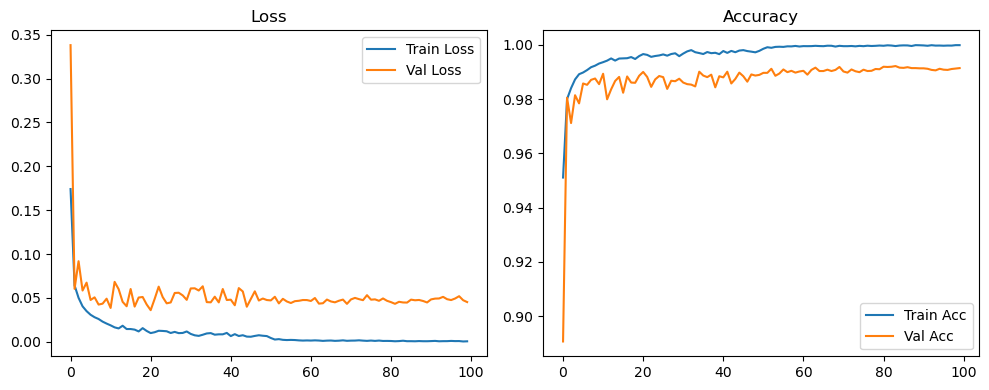

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2776, Acc: 0.9206 | Val Loss: 1.7416, Acc: 0.4436


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1324, Acc: 0.9610 | Val Loss: 0.6483, Acc: 0.7734


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9663 | Val Loss: 0.7254, Acc: 0.7366


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9716 | Val Loss: 0.3662, Acc: 0.8701


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9738 | Val Loss: 0.4354, Acc: 0.8451


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9751 | Val Loss: 0.1876, Acc: 0.9426


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9780 | Val Loss: 0.1471, Acc: 0.9566


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9780 | Val Loss: 0.2597, Acc: 0.9132


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9786 | Val Loss: 0.1563, Acc: 0.9503


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9791 | Val Loss: 0.1675, Acc: 0.9442


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9794 | Val Loss: 0.1600, Acc: 0.9505


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9806 | Val Loss: 0.1039, Acc: 0.9703


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9824 | Val Loss: 0.1157, Acc: 0.9653


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9822 | Val Loss: 0.0943, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9820 | Val Loss: 0.1080, Acc: 0.9654


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9834 | Val Loss: 0.1139, Acc: 0.9633


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9826 | Val Loss: 0.1032, Acc: 0.9679


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9837 | Val Loss: 0.1035, Acc: 0.9669


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9841 | Val Loss: 0.1057, Acc: 0.9667


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9828 | Val Loss: 0.0850, Acc: 0.9770


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9836 | Val Loss: 0.0906, Acc: 0.9737


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9842 | Val Loss: 0.1356, Acc: 0.9567


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9842 | Val Loss: 0.1172, Acc: 0.9639


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9849 | Val Loss: 0.1381, Acc: 0.9535


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.1095, Acc: 0.9659


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9855 | Val Loss: 0.1522, Acc: 0.9513


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9862 | Val Loss: 0.0987, Acc: 0.9690


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9854 | Val Loss: 0.0981, Acc: 0.9693


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9864 | Val Loss: 0.1088, Acc: 0.9660


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9861 | Val Loss: 0.0787, Acc: 0.9764


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9867 | Val Loss: 0.0998, Acc: 0.9687


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.0848, Acc: 0.9737


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.0661, Acc: 0.9797


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9869 | Val Loss: 0.0647, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9871 | Val Loss: 0.0633, Acc: 0.9809


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0826, Acc: 0.9749


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9872 | Val Loss: 0.0739, Acc: 0.9777


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.0700, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.0642, Acc: 0.9812


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0890, Acc: 0.9716


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.1033, Acc: 0.9673


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 0.1028, Acc: 0.9685


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9881 | Val Loss: 0.0591, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9880 | Val Loss: 0.0713, Acc: 0.9776


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 0.0639, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0882, Acc: 0.9734


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.0823, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.0815, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.0717, Acc: 0.9798


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.0583, Acc: 0.9832


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.0549, Acc: 0.9844


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0549, Acc: 0.9841


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0608, Acc: 0.9828


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0540, Acc: 0.9838


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0602, Acc: 0.9820


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.0610, Acc: 0.9820


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0584, Acc: 0.9824


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0585, Acc: 0.9823


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.0607, Acc: 0.9818


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0602, Acc: 0.9820


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0619, Acc: 0.9809


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0544, Acc: 0.9848


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0538, Acc: 0.9837


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0555, Acc: 0.9837


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.0532, Acc: 0.9841


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9925 | Val Loss: 0.0522, Acc: 0.9843


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.0551, Acc: 0.9834


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0548, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0520, Acc: 0.9855


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.0441, Acc: 0.9876


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0535, Acc: 0.9837


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9925 | Val Loss: 0.0510, Acc: 0.9848


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0539, Acc: 0.9835


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0515, Acc: 0.9848


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0524, Acc: 0.9852


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9920 | Val Loss: 0.0469, Acc: 0.9871


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9923 | Val Loss: 0.0516, Acc: 0.9852


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.0464, Acc: 0.9855


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0446, Acc: 0.9878


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0486, Acc: 0.9858


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0465, Acc: 0.9862


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0449, Acc: 0.9869


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0488, Acc: 0.9851


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.0436, Acc: 0.9867


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0476, Acc: 0.9859


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0502, Acc: 0.9853


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.0510, Acc: 0.9848


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0553, Acc: 0.9830


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0527, Acc: 0.9840


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9939 | Val Loss: 0.0516, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0476, Acc: 0.9868


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0457, Acc: 0.9873


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0483, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.0457, Acc: 0.9855


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9940 | Val Loss: 0.0439, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0435, Acc: 0.9866


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0405, Acc: 0.9878


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0460, Acc: 0.9862


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0417, Acc: 0.9875


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0430, Acc: 0.9869


Final Test Loss: 0.0387 Accuracy: 0.9876


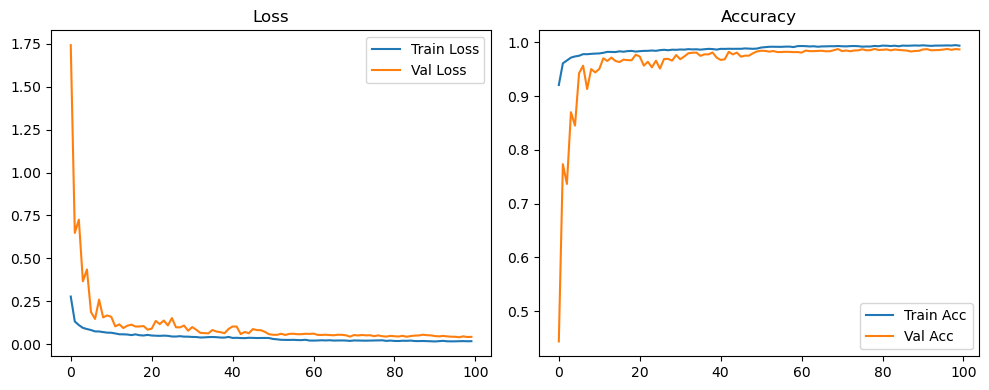

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1567, Acc: 0.9625 | Val Loss: 0.0784, Acc: 0.9758


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9870 | Val Loss: 0.0464, Acc: 0.9846


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.0498, Acc: 0.9838


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9942 | Val Loss: 0.0463, Acc: 0.9852


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.0520, Acc: 0.9842


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0374, Acc: 0.9892


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0441, Acc: 0.9879


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0376, Acc: 0.9886


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0455, Acc: 0.9878


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0546, Acc: 0.9838


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0381, Acc: 0.9890


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0479, Acc: 0.9867


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0466, Acc: 0.9890


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0380, Acc: 0.9902


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0462, Acc: 0.9881


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0502, Acc: 0.9871


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0496, Acc: 0.9883


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0447, Acc: 0.9885


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0460, Acc: 0.9894


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0439, Acc: 0.9888


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0638, Acc: 0.9853


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0575, Acc: 0.9872


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0541, Acc: 0.9857


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0492, Acc: 0.9906


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0417, Acc: 0.9906


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0462, Acc: 0.9894


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0592, Acc: 0.9868


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0530, Acc: 0.9881


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0559, Acc: 0.9874


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0499, Acc: 0.9885


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0478, Acc: 0.9899


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0455, Acc: 0.9897


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0537, Acc: 0.9887


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0469, Acc: 0.9895


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0499, Acc: 0.9892


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0500, Acc: 0.9896


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0503, Acc: 0.9895


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0579, Acc: 0.9876


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0515, Acc: 0.9900


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9907


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0496, Acc: 0.9907


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9899


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0524, Acc: 0.9892


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0617, Acc: 0.9879


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0554, Acc: 0.9882


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0554, Acc: 0.9895


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0660, Acc: 0.9885


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0604, Acc: 0.9891


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0555, Acc: 0.9888


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0557, Acc: 0.9897


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0514, Acc: 0.9908


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0494, Acc: 0.9915


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9918


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9917


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9919


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9920


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9922


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9916


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9920


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9912


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9918


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9915


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9917


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9920


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9916


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9918


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9919


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0494, Acc: 0.9917


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9920


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9922


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9921


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9917


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9922


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9922


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9923


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9920


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9922


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0494, Acc: 0.9924


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9926


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9922


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9916


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9922


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9923


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9920


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9912


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9916


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9922


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9964 | Val Loss: 0.0876, Acc: 0.9844


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0490, Acc: 0.9894


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0484, Acc: 0.9905


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0490, Acc: 0.9911


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9913


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9917


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9910


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9913


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9917


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9922


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9920


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9920


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9922


Final Test Loss: 0.0428 Accuracy: 0.9915


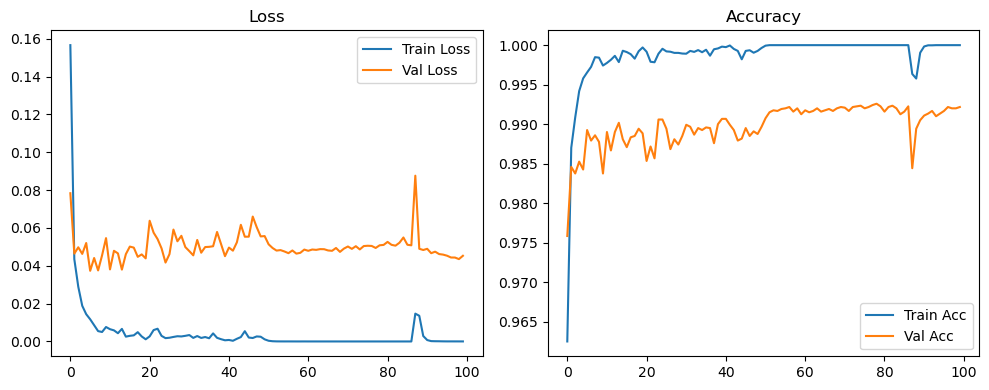

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1864, Acc: 0.9542 | Val Loss: 0.3388, Acc: 0.8924


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0630, Acc: 0.9808 | Val Loss: 0.0577, Acc: 0.9832


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9847 | Val Loss: 0.0538, Acc: 0.9831


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.0589, Acc: 0.9821


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9899 | Val Loss: 0.0626, Acc: 0.9797


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9910 | Val Loss: 0.0526, Acc: 0.9850


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0494, Acc: 0.9843


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0531, Acc: 0.9842


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0455, Acc: 0.9867


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.0472, Acc: 0.9850


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0457, Acc: 0.9870


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0480, Acc: 0.9862


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0469, Acc: 0.9864


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9951 | Val Loss: 0.0474, Acc: 0.9873


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0384, Acc: 0.9882


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0535, Acc: 0.9849


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0477, Acc: 0.9866


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0432, Acc: 0.9877


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0528, Acc: 0.9856


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0471, Acc: 0.9874


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0488, Acc: 0.9869


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0415, Acc: 0.9886


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0421, Acc: 0.9887


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0453, Acc: 0.9881


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0439, Acc: 0.9883


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0416, Acc: 0.9884


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0356, Acc: 0.9907


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0523, Acc: 0.9863


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0469, Acc: 0.9872


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0460, Acc: 0.9877


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0407, Acc: 0.9884


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0401, Acc: 0.9902


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0458, Acc: 0.9884


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0504, Acc: 0.9881


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9971 | Val Loss: 0.0371, Acc: 0.9901


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0363, Acc: 0.9899


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0439, Acc: 0.9891


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0429, Acc: 0.9895


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0399, Acc: 0.9888


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.0493, Acc: 0.9872


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0371, Acc: 0.9906


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0427, Acc: 0.9895


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0410, Acc: 0.9902


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0428, Acc: 0.9877


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0385, Acc: 0.9901


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0429, Acc: 0.9892


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0553, Acc: 0.9857


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0404, Acc: 0.9883


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0452, Acc: 0.9905


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0446, Acc: 0.9888


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0478, Acc: 0.9871


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0473, Acc: 0.9897


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0485, Acc: 0.9884


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0412, Acc: 0.9903


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0429, Acc: 0.9889


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0435, Acc: 0.9894


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9980 | Val Loss: 0.0369, Acc: 0.9903


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0394, Acc: 0.9908


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0350, Acc: 0.9917


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0499, Acc: 0.9895


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0439, Acc: 0.9901


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0444, Acc: 0.9908


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0458, Acc: 0.9896


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0398, Acc: 0.9909


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0435, Acc: 0.9899


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0408, Acc: 0.9914


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0400, Acc: 0.9910


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0417, Acc: 0.9908


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0435, Acc: 0.9890


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0475, Acc: 0.9898


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0400, Acc: 0.9907


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0459, Acc: 0.9898


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0549, Acc: 0.9891


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0451, Acc: 0.9898


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0478, Acc: 0.9898


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0435, Acc: 0.9907


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.0428, Acc: 0.9901


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0410, Acc: 0.9893


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0467, Acc: 0.9889


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0532, Acc: 0.9874


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0412, Acc: 0.9918


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0419, Acc: 0.9912


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0568, Acc: 0.9872


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0404, Acc: 0.9909


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0448, Acc: 0.9894


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0448, Acc: 0.9892


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0380, Acc: 0.9907


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0505, Acc: 0.9882


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0480, Acc: 0.9892


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0424, Acc: 0.9902


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0490, Acc: 0.9895


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0515, Acc: 0.9897


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0424, Acc: 0.9899


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0485, Acc: 0.9898


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0445, Acc: 0.9898


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0464, Acc: 0.9898


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0484, Acc: 0.9897


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0463, Acc: 0.9898


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0404, Acc: 0.9897


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0375, Acc: 0.9899


Final Test Loss: 0.0376 Accuracy: 0.9906


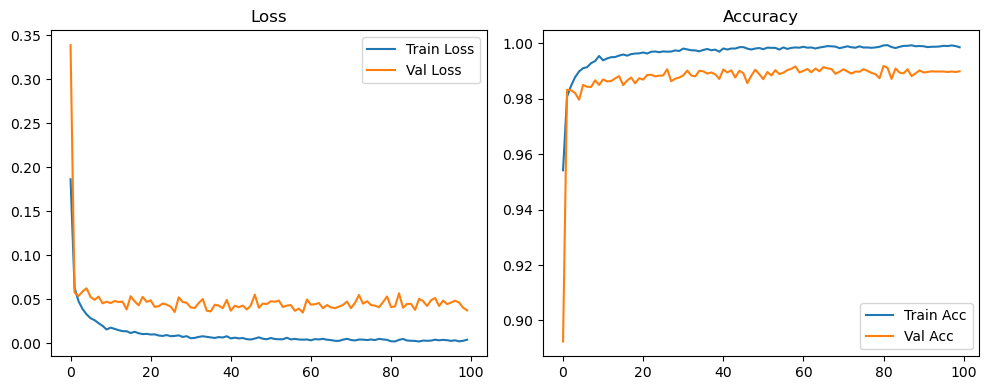

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2960, Acc: 0.9223 | Val Loss: 1.4158, Acc: 0.5042


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1302, Acc: 0.9611 | Val Loss: 0.5545, Acc: 0.8060


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1085, Acc: 0.9684 | Val Loss: 0.5772, Acc: 0.7868


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9724 | Val Loss: 0.3933, Acc: 0.8609


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0837, Acc: 0.9746 | Val Loss: 0.2963, Acc: 0.8952


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9761 | Val Loss: 0.2634, Acc: 0.9107


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9789 | Val Loss: 0.1736, Acc: 0.9447


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9789 | Val Loss: 0.2703, Acc: 0.9059


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9798 | Val Loss: 0.2080, Acc: 0.9300


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9807 | Val Loss: 0.1760, Acc: 0.9462


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9815 | Val Loss: 0.1275, Acc: 0.9619


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9823 | Val Loss: 0.1435, Acc: 0.9578


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9831 | Val Loss: 0.1759, Acc: 0.9448


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9833 | Val Loss: 0.2103, Acc: 0.9300


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9838 | Val Loss: 0.1751, Acc: 0.9410


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9846 | Val Loss: 0.1537, Acc: 0.9507


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9844 | Val Loss: 0.0976, Acc: 0.9702


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9862 | Val Loss: 0.1300, Acc: 0.9590


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9848 | Val Loss: 0.1005, Acc: 0.9680


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 0.0978, Acc: 0.9714


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9861 | Val Loss: 0.0991, Acc: 0.9693


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9858 | Val Loss: 0.1351, Acc: 0.9585


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9863 | Val Loss: 0.1017, Acc: 0.9697


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0919, Acc: 0.9720


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.1192, Acc: 0.9627


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9867 | Val Loss: 0.0988, Acc: 0.9698


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9865 | Val Loss: 0.0932, Acc: 0.9722


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9871 | Val Loss: 0.1024, Acc: 0.9692


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.0913, Acc: 0.9742


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 0.0748, Acc: 0.9775


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.0929, Acc: 0.9720


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9873 | Val Loss: 0.0993, Acc: 0.9692


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.1085, Acc: 0.9673


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.0902, Acc: 0.9740


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9870 | Val Loss: 0.0834, Acc: 0.9749


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.1027, Acc: 0.9683


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.0791, Acc: 0.9768


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 0.0790, Acc: 0.9777


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0732, Acc: 0.9776


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0797, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.0610, Acc: 0.9818


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.0785, Acc: 0.9752


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.0648, Acc: 0.9817


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.0650, Acc: 0.9809


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.0529, Acc: 0.9848


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.0570, Acc: 0.9836


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.0656, Acc: 0.9804


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.0526, Acc: 0.9852


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9900 | Val Loss: 0.0470, Acc: 0.9858


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.0471, Acc: 0.9862


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0570, Acc: 0.9826


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.0561, Acc: 0.9843


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0651, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0505, Acc: 0.9855


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.0548, Acc: 0.9849


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0539, Acc: 0.9849


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0549, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.0529, Acc: 0.9838


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0554, Acc: 0.9837


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9897 | Val Loss: 0.0538, Acc: 0.9835


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0606, Acc: 0.9819


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.0448, Acc: 0.9879


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0420, Acc: 0.9881


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0517, Acc: 0.9853


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9899 | Val Loss: 0.0621, Acc: 0.9814


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9907 | Val Loss: 0.0551, Acc: 0.9841


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0490, Acc: 0.9871


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.0611, Acc: 0.9820


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0550, Acc: 0.9836


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0455, Acc: 0.9877


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0501, Acc: 0.9862


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.0537, Acc: 0.9842


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.0480, Acc: 0.9863


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0527, Acc: 0.9854


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.0498, Acc: 0.9866


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0492, Acc: 0.9862


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0463, Acc: 0.9868


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.0493, Acc: 0.9865


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0433, Acc: 0.9879


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9904 | Val Loss: 0.0562, Acc: 0.9850


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9919 | Val Loss: 0.0552, Acc: 0.9838


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0514, Acc: 0.9866


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9915 | Val Loss: 0.0428, Acc: 0.9877


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.0557, Acc: 0.9837


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.0566, Acc: 0.9832


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9911 | Val Loss: 0.0642, Acc: 0.9801


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0503, Acc: 0.9854


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0454, Acc: 0.9878


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0535, Acc: 0.9858


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.0488, Acc: 0.9877


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0549, Acc: 0.9858


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.0540, Acc: 0.9852


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.0525, Acc: 0.9857


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9918 | Val Loss: 0.0508, Acc: 0.9873


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.0525, Acc: 0.9848


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0609, Acc: 0.9829


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.0586, Acc: 0.9849


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0559, Acc: 0.9864


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.0494, Acc: 0.9868


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.0522, Acc: 0.9855


Final Test Loss: 0.0476 Accuracy: 0.9856


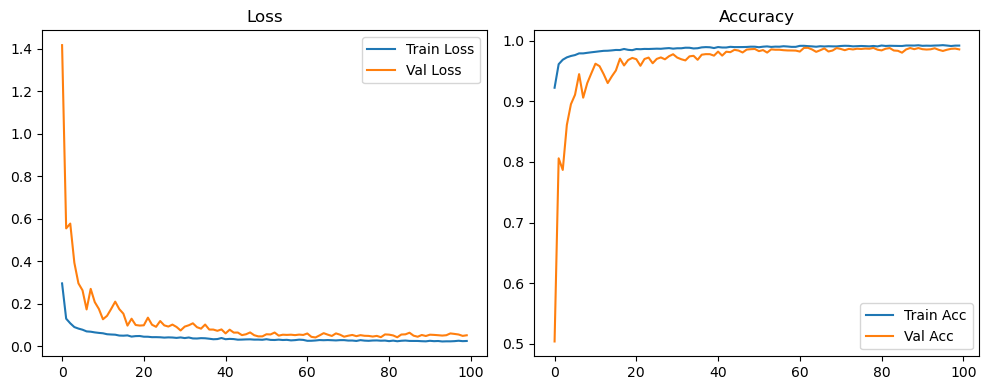

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1566, Acc: 0.9630 | Val Loss: 0.0901, Acc: 0.9722


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9865 | Val Loss: 0.0445, Acc: 0.9866


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.0431, Acc: 0.9873


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9945 | Val Loss: 0.0451, Acc: 0.9864


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.0436, Acc: 0.9871


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0487, Acc: 0.9851


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0378, Acc: 0.9884


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0388, Acc: 0.9894


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0418, Acc: 0.9882


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0473, Acc: 0.9866


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0488, Acc: 0.9872


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0442, Acc: 0.9887


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0468, Acc: 0.9886


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0457, Acc: 0.9893


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0542, Acc: 0.9864


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0529, Acc: 0.9886


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0572, Acc: 0.9864


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0522, Acc: 0.9870


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0407, Acc: 0.9901


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0420, Acc: 0.9901


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0497, Acc: 0.9888


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0571, Acc: 0.9870


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0601, Acc: 0.9871


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0445, Acc: 0.9899


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0481, Acc: 0.9897


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0433, Acc: 0.9902


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0484, Acc: 0.9902


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0571, Acc: 0.9869


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0653, Acc: 0.9859


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0428, Acc: 0.9896


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0476, Acc: 0.9897


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0420, Acc: 0.9900


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0416, Acc: 0.9914


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9921


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9915


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9925


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9925


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9922


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9922


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9929


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9926


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9931


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9929


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9931


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9927


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9928


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9926


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9928


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9926


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9924


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9923


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9923


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9923


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9931


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9925


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9929


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9923


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9929


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9932


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0806, Acc: 0.9849


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0507, Acc: 0.9898


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0526, Acc: 0.9888


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0427, Acc: 0.9908


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0450, Acc: 0.9906


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9917


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9916


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9919


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9919


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9915


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9916


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0457, Acc: 0.9912


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0609, Acc: 0.9884


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0482, Acc: 0.9907


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0506, Acc: 0.9908


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9912


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9913


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9913


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9917


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9919


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9920


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9919


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9915


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9915


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9919


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9918


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9912


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9917


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9914


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9920


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9917


Final Test Loss: 0.0446 Accuracy: 0.9921


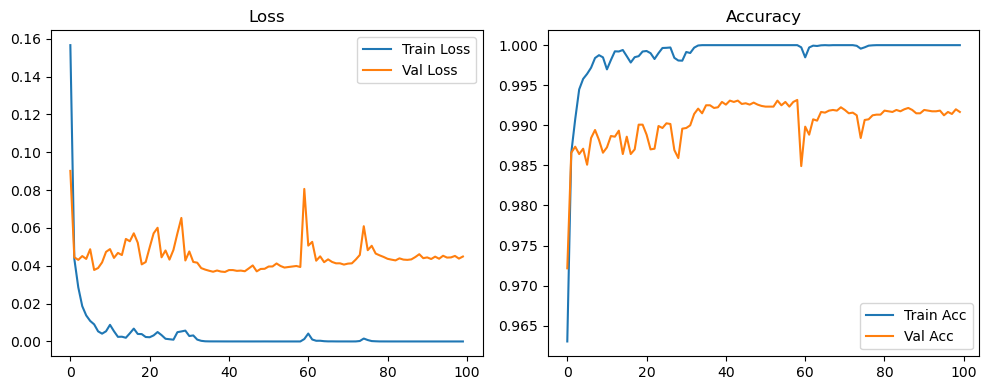

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1862, Acc: 0.9545 | Val Loss: 0.2597, Acc: 0.9155


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9807 | Val Loss: 0.0716, Acc: 0.9791


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 0.0635, Acc: 0.9791


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0512, Acc: 0.9840


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0487, Acc: 0.9848


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9916 | Val Loss: 0.0423, Acc: 0.9873


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9922 | Val Loss: 0.0417, Acc: 0.9864


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.0428, Acc: 0.9871


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0369, Acc: 0.9884


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0390, Acc: 0.9882


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0372, Acc: 0.9885


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.0395, Acc: 0.9880


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0532, Acc: 0.9837


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0378, Acc: 0.9894


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0475, Acc: 0.9859


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0586, Acc: 0.9831


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0419, Acc: 0.9885


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0362, Acc: 0.9904


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0480, Acc: 0.9855


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0426, Acc: 0.9889


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.0542, Acc: 0.9850


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0368, Acc: 0.9892


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0420, Acc: 0.9882


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9961 | Val Loss: 0.0442, Acc: 0.9899


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0386, Acc: 0.9899


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0410, Acc: 0.9888


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0440, Acc: 0.9883


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0442, Acc: 0.9886


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0426, Acc: 0.9895


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0401, Acc: 0.9891


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0481, Acc: 0.9865


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0476, Acc: 0.9876


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0400, Acc: 0.9894


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0466, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0445, Acc: 0.9890


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0489, Acc: 0.9883


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0414, Acc: 0.9895


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0442, Acc: 0.9882


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0431, Acc: 0.9890


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0422, Acc: 0.9888


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0443, Acc: 0.9892


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0443, Acc: 0.9888


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0541, Acc: 0.9863


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0436, Acc: 0.9895


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0371, Acc: 0.9900


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0529, Acc: 0.9872


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0537, Acc: 0.9882


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0418, Acc: 0.9898


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0442, Acc: 0.9895


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0523, Acc: 0.9875


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0447, Acc: 0.9893


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0416, Acc: 0.9907


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0430, Acc: 0.9898


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0396, Acc: 0.9910


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0398, Acc: 0.9908


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0404, Acc: 0.9906


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0452, Acc: 0.9898


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0385, Acc: 0.9911


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0371, Acc: 0.9913


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0418, Acc: 0.9908


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0422, Acc: 0.9897


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0426, Acc: 0.9912


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9917


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0369, Acc: 0.9926


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0388, Acc: 0.9919


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0445, Acc: 0.9908


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0413, Acc: 0.9910


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0419, Acc: 0.9909


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9908


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0379, Acc: 0.9919


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0416, Acc: 0.9911


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0444, Acc: 0.9902


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0494, Acc: 0.9903


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0450, Acc: 0.9909


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0441, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0420, Acc: 0.9916


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0483, Acc: 0.9902


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0454, Acc: 0.9906


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0416, Acc: 0.9913


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0409, Acc: 0.9910


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0433, Acc: 0.9910


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0405, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0408, Acc: 0.9913


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0387, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0422, Acc: 0.9912


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0394, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0403, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0432, Acc: 0.9912


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0439, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0448, Acc: 0.9910


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0467, Acc: 0.9903


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0466, Acc: 0.9908


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0452, Acc: 0.9912


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0428, Acc: 0.9916


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0444, Acc: 0.9913


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0411, Acc: 0.9916


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0474, Acc: 0.9905


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0448, Acc: 0.9915


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0411, Acc: 0.9922


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0405, Acc: 0.9922


Final Test Loss: 0.0376 Accuracy: 0.9912


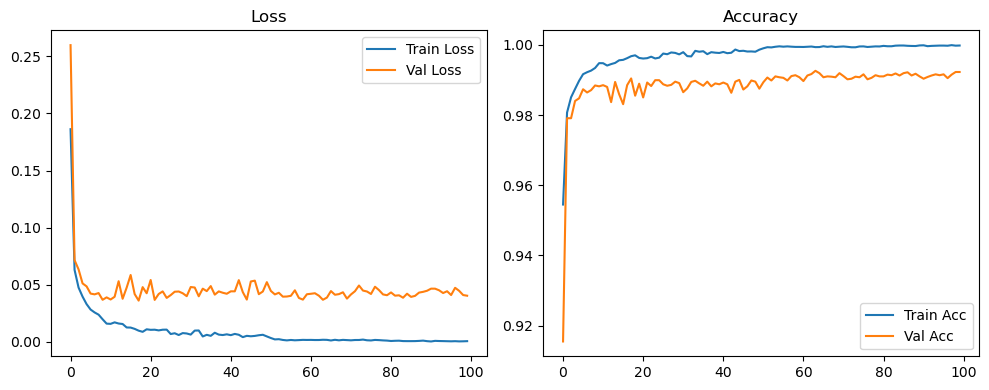

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2967, Acc: 0.9213 | Val Loss: 1.1821, Acc: 0.5797


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1302, Acc: 0.9613 | Val Loss: 0.5889, Acc: 0.7918


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1069, Acc: 0.9691 | Val Loss: 0.6342, Acc: 0.7688


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9732 | Val Loss: 0.4824, Acc: 0.8245


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9749 | Val Loss: 0.2134, Acc: 0.9303


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9767 | Val Loss: 0.1384, Acc: 0.9621


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9785 | Val Loss: 0.2577, Acc: 0.9113


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9790 | Val Loss: 0.2319, Acc: 0.9215


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9803 | Val Loss: 0.1675, Acc: 0.9501


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9811 | Val Loss: 0.1928, Acc: 0.9394


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9807 | Val Loss: 0.1919, Acc: 0.9419


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9819 | Val Loss: 0.1106, Acc: 0.9692


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9828 | Val Loss: 0.1398, Acc: 0.9587


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9836 | Val Loss: 0.1593, Acc: 0.9507


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9837 | Val Loss: 0.1353, Acc: 0.9579


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9844 | Val Loss: 0.1655, Acc: 0.9493


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9841 | Val Loss: 0.0901, Acc: 0.9727


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 0.0992, Acc: 0.9726


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9852 | Val Loss: 0.0878, Acc: 0.9743


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9847 | Val Loss: 0.0809, Acc: 0.9772


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9855 | Val Loss: 0.0924, Acc: 0.9734


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.1601, Acc: 0.9502


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9862 | Val Loss: 0.0775, Acc: 0.9779


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.0804, Acc: 0.9770


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.0748, Acc: 0.9777


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 0.0793, Acc: 0.9779


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9872 | Val Loss: 0.0970, Acc: 0.9717


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9869 | Val Loss: 0.0906, Acc: 0.9736


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.0682, Acc: 0.9807


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9873 | Val Loss: 0.0840, Acc: 0.9754


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.0607, Acc: 0.9827


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0750, Acc: 0.9772


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.0714, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9886 | Val Loss: 0.0650, Acc: 0.9808


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 0.0731, Acc: 0.9776


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9885 | Val Loss: 0.0671, Acc: 0.9803


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.0681, Acc: 0.9802


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0936, Acc: 0.9719


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.0678, Acc: 0.9800


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.0703, Acc: 0.9791


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9878 | Val Loss: 0.0563, Acc: 0.9847


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9900 | Val Loss: 0.0750, Acc: 0.9790


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0689, Acc: 0.9791


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0881, Acc: 0.9722


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9896 | Val Loss: 0.0620, Acc: 0.9818


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0625, Acc: 0.9812


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9891 | Val Loss: 0.0764, Acc: 0.9772


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.0640, Acc: 0.9821


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0688, Acc: 0.9793


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.0734, Acc: 0.9773


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.0553, Acc: 0.9842


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0587, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.0597, Acc: 0.9828


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0623, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.0685, Acc: 0.9795


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.0527, Acc: 0.9846


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.0476, Acc: 0.9863


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0460, Acc: 0.9869


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0524, Acc: 0.9853


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.0543, Acc: 0.9841


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.0512, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.0559, Acc: 0.9832


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0443, Acc: 0.9873


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0471, Acc: 0.9872


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0453, Acc: 0.9881


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0528, Acc: 0.9850


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0519, Acc: 0.9852


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.0498, Acc: 0.9865


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0561, Acc: 0.9836


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.0447, Acc: 0.9874


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0479, Acc: 0.9857


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0603, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.0533, Acc: 0.9846


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0510, Acc: 0.9847


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9923 | Val Loss: 0.0522, Acc: 0.9851


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9925 | Val Loss: 0.0508, Acc: 0.9843


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0539, Acc: 0.9848


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0452, Acc: 0.9882


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9928 | Val Loss: 0.0477, Acc: 0.9873


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9934 | Val Loss: 0.0520, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0461, Acc: 0.9868


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0470, Acc: 0.9865


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0472, Acc: 0.9870


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.0436, Acc: 0.9873


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0448, Acc: 0.9870


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0485, Acc: 0.9868


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0435, Acc: 0.9869


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0461, Acc: 0.9875


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9934 | Val Loss: 0.0480, Acc: 0.9869


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0461, Acc: 0.9869


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.0481, Acc: 0.9866


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0439, Acc: 0.9879


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0476, Acc: 0.9878


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9943 | Val Loss: 0.0429, Acc: 0.9878


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0466, Acc: 0.9868


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0412, Acc: 0.9882


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0419, Acc: 0.9897


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9938 | Val Loss: 0.0458, Acc: 0.9875


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0377, Acc: 0.9894


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9937 | Val Loss: 0.0387, Acc: 0.9896


Final Test Loss: 0.0372 Accuracy: 0.9887


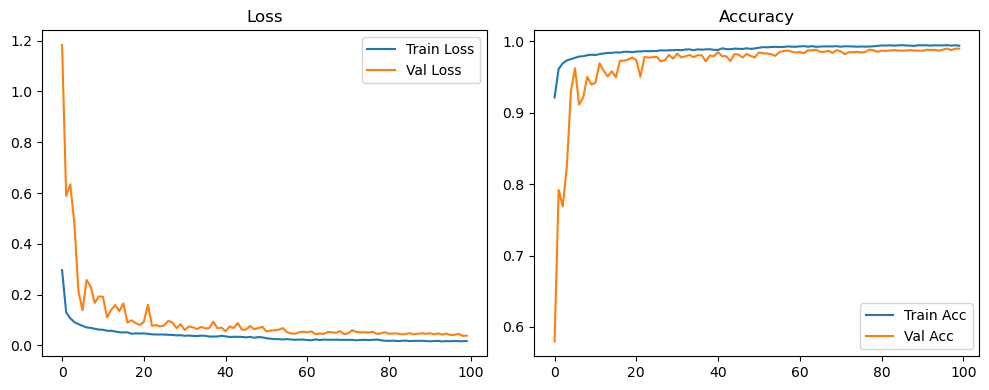

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2097, Acc: 0.9631 | Val Loss: 0.0698, Acc: 0.9823


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9877 | Val Loss: 0.0448, Acc: 0.9878


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9912 | Val Loss: 0.0427, Acc: 0.9874


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9946 | Val Loss: 0.0432, Acc: 0.9863


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9962 | Val Loss: 0.0375, Acc: 0.9885


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9977 | Val Loss: 0.0425, Acc: 0.9866


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9986 | Val Loss: 0.0368, Acc: 0.9892


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9993 | Val Loss: 0.0340, Acc: 0.9906


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9997 | Val Loss: 0.0392, Acc: 0.9878


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9998 | Val Loss: 0.0398, Acc: 0.9886


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.0483, Acc: 0.9853


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0504, Acc: 0.9858


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0463, Acc: 0.9871


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0400, Acc: 0.9884


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.0385, Acc: 0.9892


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9905


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9905


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9919


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9914


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9917


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9914


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9916


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9918


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9914


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9920


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9915


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9918


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9913


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9915


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9914


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9918


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9917


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.0567, Acc: 0.9842


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0409, Acc: 0.9878


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.0365, Acc: 0.9899


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9999 | Val Loss: 0.0362, Acc: 0.9902


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9908


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9912


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9913


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9914


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9914


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9914


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9912


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9917


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9908


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9917


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9920


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9918


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9910


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9915


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9909


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9912


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9916


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9920


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9917


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9916


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9914


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9920


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9913


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1237, Acc: 0.9722


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0458, Acc: 0.9872


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0397, Acc: 0.9899


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0345, Acc: 0.9910


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9914


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9913


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9914


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9905


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9912


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9914


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9910


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9917


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9919


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9913


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9912


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9911


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9917


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9917


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9918


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9918


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9924


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1740, Acc: 0.9616


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0574, Acc: 0.9867


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0493, Acc: 0.9887


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0436, Acc: 0.9898


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9910


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9904


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9909


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9908


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9908


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9913


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9909


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9908


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9909


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9907


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9913


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9908


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9909


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9909


Final Test Loss: 0.0380 Accuracy: 0.9913


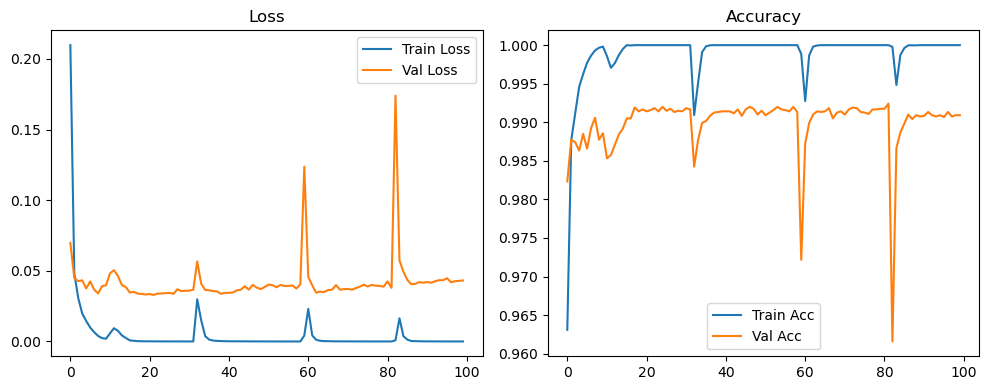

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2457, Acc: 0.9543 | Val Loss: 0.2048, Acc: 0.9439


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0668, Acc: 0.9817 | Val Loss: 0.0726, Acc: 0.9827


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9852 | Val Loss: 0.0932, Acc: 0.9736


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9879 | Val Loss: 0.0566, Acc: 0.9830


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9904 | Val Loss: 0.0634, Acc: 0.9814


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.0591, Acc: 0.9833


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.0455, Acc: 0.9853


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9929 | Val Loss: 0.0510, Acc: 0.9842


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0374, Acc: 0.9890


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0463, Acc: 0.9858


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0413, Acc: 0.9879


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0418, Acc: 0.9870


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0426, Acc: 0.9872


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0412, Acc: 0.9881


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0460, Acc: 0.9867


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0559, Acc: 0.9846


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0472, Acc: 0.9853


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0445, Acc: 0.9869


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0455, Acc: 0.9866


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0387, Acc: 0.9893


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0472, Acc: 0.9866


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0459, Acc: 0.9864


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0448, Acc: 0.9879


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0424, Acc: 0.9886


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0509, Acc: 0.9848


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0353, Acc: 0.9896


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0376, Acc: 0.9900


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0390, Acc: 0.9901


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0417, Acc: 0.9892


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0409, Acc: 0.9877


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0360, Acc: 0.9907


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0402, Acc: 0.9894


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0366, Acc: 0.9902


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0406, Acc: 0.9896


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0355, Acc: 0.9905


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0405, Acc: 0.9899


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0431, Acc: 0.9888


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0399, Acc: 0.9902


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0485, Acc: 0.9881


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0393, Acc: 0.9895


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0419, Acc: 0.9893


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0495, Acc: 0.9860


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0482, Acc: 0.9883


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0397, Acc: 0.9897


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0390, Acc: 0.9895


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0408, Acc: 0.9891


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0445, Acc: 0.9884


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0440, Acc: 0.9893


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0396, Acc: 0.9903


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0444, Acc: 0.9888


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0412, Acc: 0.9896


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0421, Acc: 0.9899


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0441, Acc: 0.9893


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0428, Acc: 0.9890


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0419, Acc: 0.9896


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0397, Acc: 0.9910


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0426, Acc: 0.9898


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0489, Acc: 0.9876


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.0399, Acc: 0.9905


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0394, Acc: 0.9908


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0431, Acc: 0.9902


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0409, Acc: 0.9910


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0381, Acc: 0.9912


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0403, Acc: 0.9903


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0432, Acc: 0.9899


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0393, Acc: 0.9912


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0435, Acc: 0.9898


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0422, Acc: 0.9903


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0376, Acc: 0.9910


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9886


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0397, Acc: 0.9909


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0346, Acc: 0.9922


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0506, Acc: 0.9888


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0404, Acc: 0.9903


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0470, Acc: 0.9890


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9986 | Val Loss: 0.0358, Acc: 0.9919


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0424, Acc: 0.9908


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0412, Acc: 0.9906


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0425, Acc: 0.9892


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0416, Acc: 0.9890


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0436, Acc: 0.9902


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0396, Acc: 0.9917


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0373, Acc: 0.9912


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0423, Acc: 0.9902


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0423, Acc: 0.9902


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0369, Acc: 0.9918


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0410, Acc: 0.9906


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0383, Acc: 0.9913


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0363, Acc: 0.9923


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0457, Acc: 0.9901


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0444, Acc: 0.9901


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0456, Acc: 0.9897


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0413, Acc: 0.9912


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0400, Acc: 0.9899


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0382, Acc: 0.9907


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0398, Acc: 0.9912


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0371, Acc: 0.9916


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0415, Acc: 0.9907


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0364, Acc: 0.9919


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0406, Acc: 0.9909


Final Test Loss: 0.0370 Accuracy: 0.9901


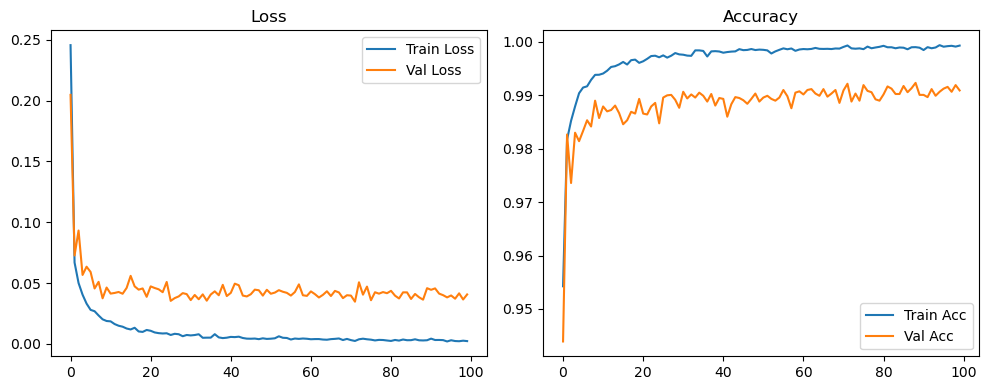

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3721, Acc: 0.9189 | Val Loss: 1.6082, Acc: 0.4130


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1397, Acc: 0.9612 | Val Loss: 0.8502, Acc: 0.6908


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1132, Acc: 0.9683 | Val Loss: 0.6309, Acc: 0.7668


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0964, Acc: 0.9730 | Val Loss: 0.5736, Acc: 0.7795


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0887, Acc: 0.9741 | Val Loss: 0.4721, Acc: 0.8225


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0833, Acc: 0.9751 | Val Loss: 0.3792, Acc: 0.8589


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9776 | Val Loss: 0.2504, Acc: 0.9160


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0728, Acc: 0.9785 | Val Loss: 0.3846, Acc: 0.8642


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0662, Acc: 0.9805 | Val Loss: 0.2165, Acc: 0.9271


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9811 | Val Loss: 0.2670, Acc: 0.9122


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9807 | Val Loss: 0.2000, Acc: 0.9323


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9819 | Val Loss: 0.1554, Acc: 0.9522


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9837 | Val Loss: 0.1525, Acc: 0.9533


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9832 | Val Loss: 0.2236, Acc: 0.9247


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9831 | Val Loss: 0.1780, Acc: 0.9413


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9839 | Val Loss: 0.2638, Acc: 0.9142


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9844 | Val Loss: 0.1634, Acc: 0.9482


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9851 | Val Loss: 0.1508, Acc: 0.9532


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9853 | Val Loss: 0.1318, Acc: 0.9589


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9853 | Val Loss: 0.1346, Acc: 0.9574


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9839 | Val Loss: 0.1452, Acc: 0.9559


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.1435, Acc: 0.9546


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9864 | Val Loss: 0.1134, Acc: 0.9647


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9858 | Val Loss: 0.0982, Acc: 0.9702


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.1203, Acc: 0.9622


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9871 | Val Loss: 0.0964, Acc: 0.9702


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9861 | Val Loss: 0.1074, Acc: 0.9682


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1019, Acc: 0.9694


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.0951, Acc: 0.9713


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9879 | Val Loss: 0.0983, Acc: 0.9685


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0877, Acc: 0.9742


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.1254, Acc: 0.9601


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.1091, Acc: 0.9666


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.0805, Acc: 0.9763


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9876 | Val Loss: 0.0776, Acc: 0.9758


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0704, Acc: 0.9790


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9890 | Val Loss: 0.0657, Acc: 0.9810


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.0998, Acc: 0.9685


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.0759, Acc: 0.9769


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9883 | Val Loss: 0.0756, Acc: 0.9760


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.0870, Acc: 0.9729


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.1060, Acc: 0.9661


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0812, Acc: 0.9755


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9895 | Val Loss: 0.0696, Acc: 0.9802


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.0842, Acc: 0.9749


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0711, Acc: 0.9786


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.0812, Acc: 0.9761


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0628, Acc: 0.9814


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0640, Acc: 0.9807


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0654, Acc: 0.9802


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0732, Acc: 0.9790


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.0669, Acc: 0.9807


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0826, Acc: 0.9745


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0609, Acc: 0.9824


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.0882, Acc: 0.9722


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0797, Acc: 0.9762


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0591, Acc: 0.9830


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.0528, Acc: 0.9841


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.0768, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.0686, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.0637, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0584, Acc: 0.9829


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0515, Acc: 0.9857


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0539, Acc: 0.9848


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0973, Acc: 0.9684


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0691, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9897 | Val Loss: 0.0587, Acc: 0.9834


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0656, Acc: 0.9802


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9911 | Val Loss: 0.0761, Acc: 0.9766


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9919 | Val Loss: 0.0567, Acc: 0.9838


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0675, Acc: 0.9797


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.0639, Acc: 0.9807


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0664, Acc: 0.9794


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.0947, Acc: 0.9707


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0775, Acc: 0.9768


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.0676, Acc: 0.9801


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0760, Acc: 0.9769


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0587, Acc: 0.9824


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0660, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0654, Acc: 0.9796


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.0685, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0731, Acc: 0.9779


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0598, Acc: 0.9812


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0633, Acc: 0.9801


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0757, Acc: 0.9755


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0601, Acc: 0.9818


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.0785, Acc: 0.9757


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0624, Acc: 0.9823


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0540, Acc: 0.9843


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.0738, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0583, Acc: 0.9841


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0599, Acc: 0.9832


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.0650, Acc: 0.9805


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0575, Acc: 0.9819


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.0563, Acc: 0.9828


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0619, Acc: 0.9831


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.0510, Acc: 0.9862


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0705, Acc: 0.9793


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.0620, Acc: 0.9832


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0703, Acc: 0.9786


Final Test Loss: 0.0694 Accuracy: 0.9783


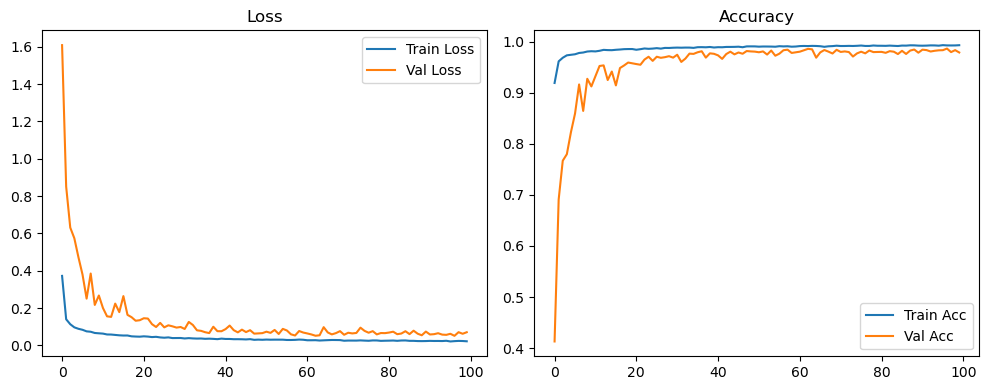

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2921, Acc: 0.9590 | Val Loss: 0.0886, Acc: 0.9837


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0626, Acc: 0.9869 | Val Loss: 0.0655, Acc: 0.9847


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9917 | Val Loss: 0.0609, Acc: 0.9829


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9945 | Val Loss: 0.0469, Acc: 0.9864


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9962 | Val Loss: 0.0430, Acc: 0.9874


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9975 | Val Loss: 0.0391, Acc: 0.9884


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9988 | Val Loss: 0.0337, Acc: 0.9900


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9993 | Val Loss: 0.0336, Acc: 0.9902


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9996 | Val Loss: 0.0416, Acc: 0.9879


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9996 | Val Loss: 0.0395, Acc: 0.9879


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9998 | Val Loss: 0.0412, Acc: 0.9884


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9999 | Val Loss: 0.0366, Acc: 0.9897


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9906


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0600, Acc: 0.9838


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0663, Acc: 0.9826


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0530, Acc: 0.9839


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.0390, Acc: 0.9887


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9996 | Val Loss: 0.0335, Acc: 0.9902


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9909


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9912


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9921


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9917


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9908


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9912


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9916


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9912


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9907


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9908


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9911


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9912


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9904


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9908


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9907


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9908


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9909


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9910


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9912


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9910


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9902


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9916


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9906


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9903


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9905


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9895 | Val Loss: 0.0471, Acc: 0.9875


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0368, Acc: 0.9892


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0340, Acc: 0.9907


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0355, Acc: 0.9907


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9911


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9916


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9911


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9918


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9911


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9908


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9917


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9908


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9917


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9912


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9909


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9914


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9911


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9912


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9905


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9908


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9912


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9910


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9909


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9909


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9912


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9914


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9914


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9916


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9911


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9912


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.0752, Acc: 0.9813


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0465, Acc: 0.9878


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0438, Acc: 0.9897


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0397, Acc: 0.9903


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9903


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9915


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9914


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9917


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9911


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9912


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9913


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9911


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9913


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9914


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9912


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9913


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9911


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9912


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9911


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9918


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9916


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9912


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9915


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9911


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9911


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9917


Final Test Loss: 0.0405 Accuracy: 0.9903


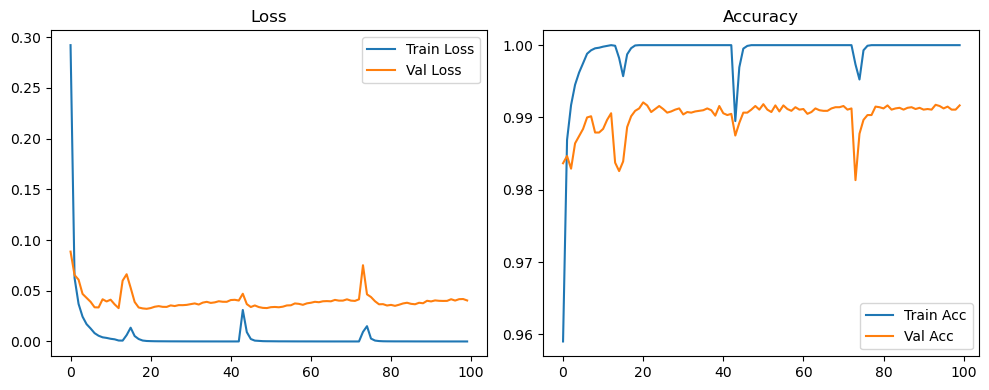

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3399, Acc: 0.9480 | Val Loss: 0.2556, Acc: 0.9460


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0835, Acc: 0.9821 | Val Loss: 0.1174, Acc: 0.9761


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9845 | Val Loss: 0.1053, Acc: 0.9736


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9875 | Val Loss: 0.0839, Acc: 0.9792


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9899 | Val Loss: 0.0761, Acc: 0.9779


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9908 | Val Loss: 0.0744, Acc: 0.9796


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9918 | Val Loss: 0.0525, Acc: 0.9847


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9926 | Val Loss: 0.0520, Acc: 0.9846


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9932 | Val Loss: 0.0514, Acc: 0.9858


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9939 | Val Loss: 0.0459, Acc: 0.9858


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9942 | Val Loss: 0.0537, Acc: 0.9841


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.0527, Acc: 0.9848


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9951 | Val Loss: 0.0441, Acc: 0.9877


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9955 | Val Loss: 0.0489, Acc: 0.9858


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0443, Acc: 0.9865


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.0441, Acc: 0.9870


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0495, Acc: 0.9851


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0427, Acc: 0.9876


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0384, Acc: 0.9888


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0444, Acc: 0.9879


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0476, Acc: 0.9870


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0478, Acc: 0.9858


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0459, Acc: 0.9882


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0404, Acc: 0.9888


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0448, Acc: 0.9876


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0392, Acc: 0.9891


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0395, Acc: 0.9898


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0433, Acc: 0.9884


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0466, Acc: 0.9874


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0404, Acc: 0.9886


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0387, Acc: 0.9904


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0480, Acc: 0.9859


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0421, Acc: 0.9887


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0437, Acc: 0.9888


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0357, Acc: 0.9898


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0425, Acc: 0.9898


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0362, Acc: 0.9904


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0475, Acc: 0.9873


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0428, Acc: 0.9894


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0398, Acc: 0.9898


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0418, Acc: 0.9901


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0394, Acc: 0.9893


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0442, Acc: 0.9888


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0434, Acc: 0.9891


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0525, Acc: 0.9858


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0406, Acc: 0.9899


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0408, Acc: 0.9899


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0436, Acc: 0.9890


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0405, Acc: 0.9898


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0428, Acc: 0.9894


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0369, Acc: 0.9911


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0432, Acc: 0.9897


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0419, Acc: 0.9902


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0394, Acc: 0.9907


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0404, Acc: 0.9900


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0414, Acc: 0.9899


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0458, Acc: 0.9898


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0456, Acc: 0.9894


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0434, Acc: 0.9891


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0371, Acc: 0.9910


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0411, Acc: 0.9898


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0424, Acc: 0.9903


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0369, Acc: 0.9914


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0363, Acc: 0.9912


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0369, Acc: 0.9909


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0388, Acc: 0.9910


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0373, Acc: 0.9911


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0343, Acc: 0.9918


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0393, Acc: 0.9904


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0431, Acc: 0.9893


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0480, Acc: 0.9894


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0458, Acc: 0.9890


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0444, Acc: 0.9906


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0404, Acc: 0.9904


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0411, Acc: 0.9911


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0413, Acc: 0.9903


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0429, Acc: 0.9900


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0448, Acc: 0.9903


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0399, Acc: 0.9907


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0379, Acc: 0.9903


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0391, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0398, Acc: 0.9908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0387, Acc: 0.9911


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0409, Acc: 0.9907


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0430, Acc: 0.9904


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0415, Acc: 0.9904


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0388, Acc: 0.9914


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0426, Acc: 0.9900


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0400, Acc: 0.9908


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0381, Acc: 0.9911


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0391, Acc: 0.9916


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0438, Acc: 0.9901


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0408, Acc: 0.9912


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0470, Acc: 0.9898


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0391, Acc: 0.9913


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0483, Acc: 0.9895


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0436, Acc: 0.9904


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0382, Acc: 0.9916


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0371, Acc: 0.9914


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0420, Acc: 0.9909


Final Test Loss: 0.0376 Accuracy: 0.9905


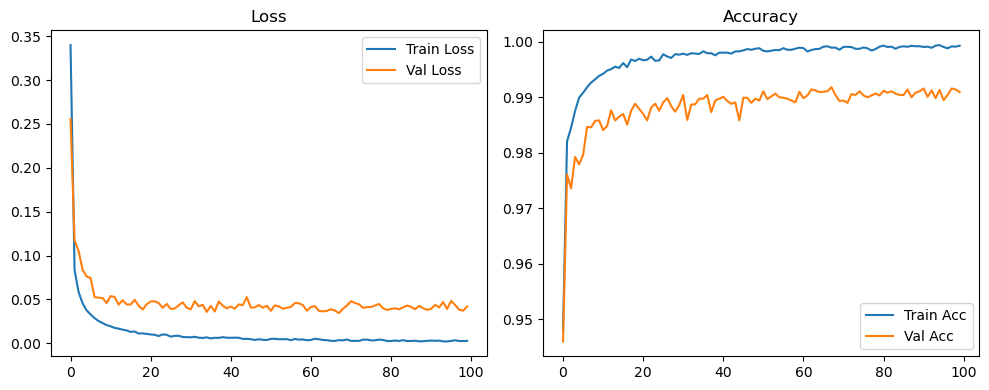

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4959, Acc: 0.9059 | Val Loss: 1.6909, Acc: 0.3088


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1698, Acc: 0.9602 | Val Loss: 1.1163, Acc: 0.5905


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1290, Acc: 0.9670 | Val Loss: 0.9668, Acc: 0.6303


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1099, Acc: 0.9706 | Val Loss: 0.6826, Acc: 0.7307


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0991, Acc: 0.9721 | Val Loss: 0.5670, Acc: 0.7864


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0933, Acc: 0.9740 | Val Loss: 0.5049, Acc: 0.8123


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0828, Acc: 0.9760 | Val Loss: 0.3381, Acc: 0.8798


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0791, Acc: 0.9773 | Val Loss: 0.4394, Acc: 0.8353


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0724, Acc: 0.9793 | Val Loss: 0.2305, Acc: 0.9217


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0709, Acc: 0.9796 | Val Loss: 0.3283, Acc: 0.8857


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0704, Acc: 0.9794 | Val Loss: 0.2584, Acc: 0.9133


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9808 | Val Loss: 0.1988, Acc: 0.9390


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0626, Acc: 0.9814 | Val Loss: 0.1961, Acc: 0.9361


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0629, Acc: 0.9812 | Val Loss: 0.2756, Acc: 0.9040


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9828 | Val Loss: 0.2267, Acc: 0.9218


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9827 | Val Loss: 0.2355, Acc: 0.9238


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9837 | Val Loss: 0.1470, Acc: 0.9522


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9835 | Val Loss: 0.2065, Acc: 0.9308


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9845 | Val Loss: 0.1775, Acc: 0.9407


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9845 | Val Loss: 0.1234, Acc: 0.9612


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9839 | Val Loss: 0.1330, Acc: 0.9583


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.1523, Acc: 0.9507


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9856 | Val Loss: 0.1303, Acc: 0.9590


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9842 | Val Loss: 0.1430, Acc: 0.9557


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9856 | Val Loss: 0.1565, Acc: 0.9487


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9862 | Val Loss: 0.1076, Acc: 0.9654


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.1065, Acc: 0.9664


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9867 | Val Loss: 0.1286, Acc: 0.9590


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1352, Acc: 0.9589


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.1140, Acc: 0.9634


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0956, Acc: 0.9692


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.1130, Acc: 0.9634


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9881 | Val Loss: 0.1020, Acc: 0.9684


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9878 | Val Loss: 0.0851, Acc: 0.9742


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0928, Acc: 0.9708


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9880 | Val Loss: 0.0962, Acc: 0.9702


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9882 | Val Loss: 0.0881, Acc: 0.9730


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.0932, Acc: 0.9709


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.0696, Acc: 0.9802


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9885 | Val Loss: 0.0689, Acc: 0.9794


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9892 | Val Loss: 0.0743, Acc: 0.9783


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.0818, Acc: 0.9745


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.0656, Acc: 0.9818


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9884 | Val Loss: 0.0798, Acc: 0.9765


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9893 | Val Loss: 0.0571, Acc: 0.9841


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0795, Acc: 0.9754


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9892 | Val Loss: 0.0826, Acc: 0.9742


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0617, Acc: 0.9816


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0857, Acc: 0.9731


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9906 | Val Loss: 0.0693, Acc: 0.9785


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0701, Acc: 0.9800


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.0759, Acc: 0.9768


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.0695, Acc: 0.9792


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0593, Acc: 0.9838


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.0671, Acc: 0.9799


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0588, Acc: 0.9826


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0609, Acc: 0.9829


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9905 | Val Loss: 0.0614, Acc: 0.9818


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0636, Acc: 0.9809


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0641, Acc: 0.9812


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.0766, Acc: 0.9772


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0635, Acc: 0.9818


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9913 | Val Loss: 0.0680, Acc: 0.9800


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9911 | Val Loss: 0.0553, Acc: 0.9848


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0758, Acc: 0.9782


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9906 | Val Loss: 0.0724, Acc: 0.9780


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0742, Acc: 0.9800


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.0627, Acc: 0.9825


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.0631, Acc: 0.9823


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0587, Acc: 0.9828


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0587, Acc: 0.9832


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.0749, Acc: 0.9758


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.0713, Acc: 0.9787


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0800, Acc: 0.9757


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0640, Acc: 0.9815


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0586, Acc: 0.9830


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0701, Acc: 0.9782


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0602, Acc: 0.9826


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0689, Acc: 0.9779


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0647, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0608, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0591, Acc: 0.9829


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0677, Acc: 0.9794


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.0708, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0569, Acc: 0.9829


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.0573, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0595, Acc: 0.9823


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0565, Acc: 0.9851


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0495, Acc: 0.9863


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0610, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0577, Acc: 0.9837


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0523, Acc: 0.9853


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0607, Acc: 0.9836


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9925 | Val Loss: 0.0545, Acc: 0.9848


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9925 | Val Loss: 0.0572, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9935 | Val Loss: 0.0560, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0522, Acc: 0.9859


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.0558, Acc: 0.9853


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9917 | Val Loss: 0.0522, Acc: 0.9868


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0540, Acc: 0.9861


Final Test Loss: 0.0536 Accuracy: 0.9829


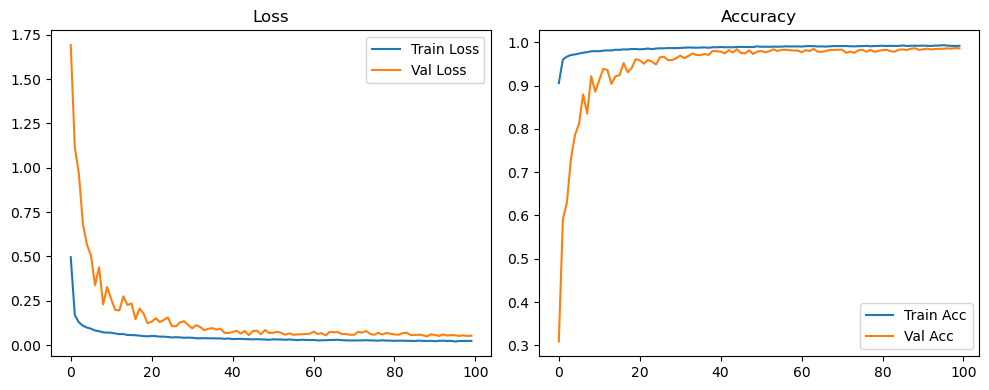

🏆 Best Config: batch64_lr0.005_0.002_0.001_dp0.0 Accuracy: 0.9922


In [8]:
root_path = "TCV_4bit_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)